In [1]:
# This is for compatibility with google colab
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MultiOmicsIntegration/comp-401

Mounted at /content/drive
/content/drive/MyDrive/MultiOmicsIntegration/comp-401


In [2]:
from multi_omics_integration.func import *
from multi_omics_integration.classification_pipeline import *
from multi_omics_integration.processing import *
from multi_omics_integration.evaluation import *
import json
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import warnings
from pandas.errors import SettingWithCopyWarning
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)
warnings.filterwarnings('ignore', 'Solver terminated early.*')

In [3]:
%cd /content/drive/MyDrive/MultiOmicsIntegration/comp-401/notebooks

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/notebooks


# Staging (RNA, CNV, RPPA)

## Preprocessing

### Removing low-variance + null features

In [ ]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold(X, percentage=0.10):
    var_thr = VarianceThreshold(threshold=percentage) #Removing both constant and quasi-constant (less than 1% variance)

    X_new = var_thr.fit_transform(X)

    column_names = X.columns[var_thr.get_support()]

    return pd.DataFrame(X_new, columns=column_names)

In [ ]:
new_data = {}
for modality in data:
    new_data[modality] = variance_threshold(data[modality])
    print(modality, new_data[modality].shape)

rna (736, 19042)
cnv (736, 5003)
rppa (736, 91)


In [ ]:
import pandas as pd

X = {}

# Convert numpy array to DataFrame
for modality in new_data:
    X[modality] = pd.DataFrame(new_data[modality])
    X[modality] = X[modality].dropna(axis=1)
    print(modality, X[modality].shape)

rna (736, 19042)
cnv (736, 5003)
rppa (736, 75)


In [ ]:
stages = pd.read_csv(labels, index_col=0)['pathologic_stage']
stages.value_counts()

stagei      375
stageiii    170
stageiv     100
stageii      91
Name: pathologic_stage, dtype: int64

In [ ]:
enc = LabelEncoder()
y = enc.fit_transform(stages)
enc.inverse_transform([0, 1, 2, 3])

array(['stagei', 'stageii', 'stageiii', 'stageiv'], dtype=object)

In [ ]:
# Assuming your array is named 'arr'
y = np.where(np.logical_or(y == 0, y == 1), 0, 1)

## Base Learners

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

estimators = [
    ("logistic", make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=1000, n_jobs=-1))),
    ("balanced_random_forest", BalancedRandomForestClassifier(random_state=0, n_jobs=-1, sampling_strategy='all', replacement=True)),
    ("deep_nn", make_pipeline(StandardScaler(), MLPClassifier(random_state=0))),
    ("svc", make_pipeline(StandardScaler(), SVC(random_state=0, kernel='linear', max_iter=1000)))
]

estimator_names = [estimator[0] for estimator in estimators]

In [ ]:
kipan_stage_scoring = {"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (early)': make_scorer(recall_multiclass, label=0), 'recall (late)': make_scorer(recall_multiclass, label=1)}

In [ ]:
base_scores = {}
base_metrics_df = {}
base_metrics_df_train = {}

for modality in datasets:
    base_scores[modality], base_metrics_df[modality] = get_individual_scores(X[modality], y, estimators, scoring=kipan_stage_scoring)

 25%|██▌       | 1/4 [00:38<01:56, 38.97s/it]

logistic                  accuracy balanced_accuracy               f1   recall (early)  \
logistic  0.701 +/- 0.048   0.659 +/- 0.065  0.686 +/- 0.060  0.818 +/- 0.087   

            recall (late)  
logistic  0.500 +/- 0.173  


 50%|█████     | 2/4 [01:09<01:07, 33.87s/it]

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.689 +/- 0.041   0.658 +/- 0.038  0.679 +/- 0.040   

                         recall (early)    recall (late)  
balanced_random_forest  0.772 +/- 0.128  0.544 +/- 0.159  


 75%|███████▌  | 3/4 [03:02<01:10, 70.04s/it]

deep_nn                 accuracy balanced_accuracy               f1   recall (early)  \
deep_nn  0.685 +/- 0.027   0.644 +/- 0.042  0.671 +/- 0.038  0.796 +/- 0.093   

           recall (late)  
deep_nn  0.493 +/- 0.155  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn

svc             accuracy balanced_accuracy               f1   recall (early)  \
svc  0.702 +/- 0.037   0.661 +/- 0.059  0.687 +/- 0.055  0.818 +/- 0.082   

       recall (late)  
svc  0.504 +/- 0.177  


 25%|██▌       | 1/4 [00:21<01:04, 21.50s/it]

logistic                  accuracy balanced_accuracy               f1   recall (early)  \
logistic  0.602 +/- 0.054   0.542 +/- 0.037  0.581 +/- 0.037  0.766 +/- 0.113   

            recall (late)  
logistic  0.319 +/- 0.076  


 50%|█████     | 2/4 [00:30<00:28, 14.22s/it]

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.626 +/- 0.060   0.608 +/- 0.035  0.613 +/- 0.051   

                         recall (early)    recall (late)  
balanced_random_forest  0.678 +/- 0.194  0.537 +/- 0.198  


 75%|███████▌  | 3/4 [01:14<00:27, 27.97s/it]

deep_nn                 accuracy balanced_accuracy               f1   recall (early)  \
deep_nn  0.575 +/- 0.048   0.522 +/- 0.049  0.555 +/- 0.037  0.719 +/- 0.123   

           recall (late)  
deep_nn  0.326 +/- 0.160  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn

svc             accuracy balanced_accuracy               f1   recall (early)  \
svc  0.499 +/- 0.074   0.536 +/- 0.061  0.488 +/- 0.087  0.397 +/- 0.154   

       recall (late)  
svc  0.674 +/- 0.144  


 25%|██▌       | 1/4 [00:00<00:00,  3.92it/s]

logistic                  accuracy balanced_accuracy               f1   recall (early)  \
logistic  0.664 +/- 0.038   0.605 +/- 0.037  0.647 +/- 0.038  0.828 +/- 0.041   

            recall (late)  
logistic  0.381 +/- 0.038  


 50%|█████     | 2/4 [00:02<00:02,  1.42s/it]

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.682 +/- 0.027   0.647 +/- 0.041  0.674 +/- 0.031   

                         recall (early)    recall (late)  
balanced_random_forest  0.779 +/- 0.066  0.515 +/- 0.127  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

deep_nn                 accuracy balanced_accuracy               f1   recall (early)  \
deep_nn  0.670 +/- 0.038   0.632 +/- 0.033  0.663 +/- 0.035  0.774 +/- 0.073   

           recall (late)  
deep_nn  0.489 +/- 0.072  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


svc             accuracy balanced_accuracy               f1   recall (early)  \
svc  0.529 +/- 0.036   0.507 +/- 0.028  0.531 +/- 0.033  0.588 +/- 0.080   

       recall (late)  
svc  0.426 +/- 0.071  


In [ ]:
display(base_metrics_df['rna']), display(base_metrics_df['cnv']), display(base_metrics_df['rppa'])

accuracy balanced_accuracy               f1  \
logistic                0.701 +/- 0.048   0.659 +/- 0.065  0.686 +/- 0.060   
balanced_random_forest  0.689 +/- 0.041   0.658 +/- 0.038  0.679 +/- 0.040   
deep_nn                 0.685 +/- 0.027   0.644 +/- 0.042  0.671 +/- 0.038   
svc                     0.702 +/- 0.037   0.661 +/- 0.059  0.687 +/- 0.055   

                         recall (early)    recall (late)  
logistic                0.818 +/- 0.087  0.500 +/- 0.173  
balanced_random_forest  0.772 +/- 0.128  0.544 +/- 0.159  
deep_nn                 0.796 +/- 0.093  0.493 +/- 0.155  
svc                     0.818 +/- 0.082  0.504 +/- 0.177

accuracy balanced_accuracy               f1  \
logistic                0.602 +/- 0.054   0.542 +/- 0.037  0.581 +/- 0.037   
balanced_random_forest  0.626 +/- 0.060   0.608 +/- 0.035  0.613 +/- 0.051   
deep_nn                 0.575 +/- 0.048   0.522 +/- 0.049  0.555 +/- 0.037   
svc                     0.499 +/- 0.074   0.536 +/- 0.061  0.488 +/- 0.087   

                         recall (early)    recall (late)  
logistic                0.766 +/- 0.113  0.319 +/- 0.076  
balanced_random_forest  0.678 +/- 0.194  0.537 +/- 0.198  
deep_nn                 0.719 +/- 0.123  0.326 +/- 0.160  
svc                     0.397 +/- 0.154  0.674 +/- 0.144

accuracy balanced_accuracy               f1  \
logistic                0.664 +/- 0.038   0.605 +/- 0.037  0.647 +/- 0.038   
balanced_random_forest  0.682 +/- 0.027   0.647 +/- 0.041  0.674 +/- 0.031   
deep_nn                 0.670 +/- 0.038   0.632 +/- 0.033  0.663 +/- 0.035   
svc                     0.529 +/- 0.036   0.507 +/- 0.028  0.531 +/- 0.033   

                         recall (early)    recall (late)  
logistic                0.828 +/- 0.041  0.381 +/- 0.038  
balanced_random_forest  0.779 +/- 0.066  0.515 +/- 0.127  
deep_nn                 0.774 +/- 0.073  0.489 +/- 0.072  
svc                     0.588 +/- 0.080  0.426 +/- 0.071

(None, None, None)

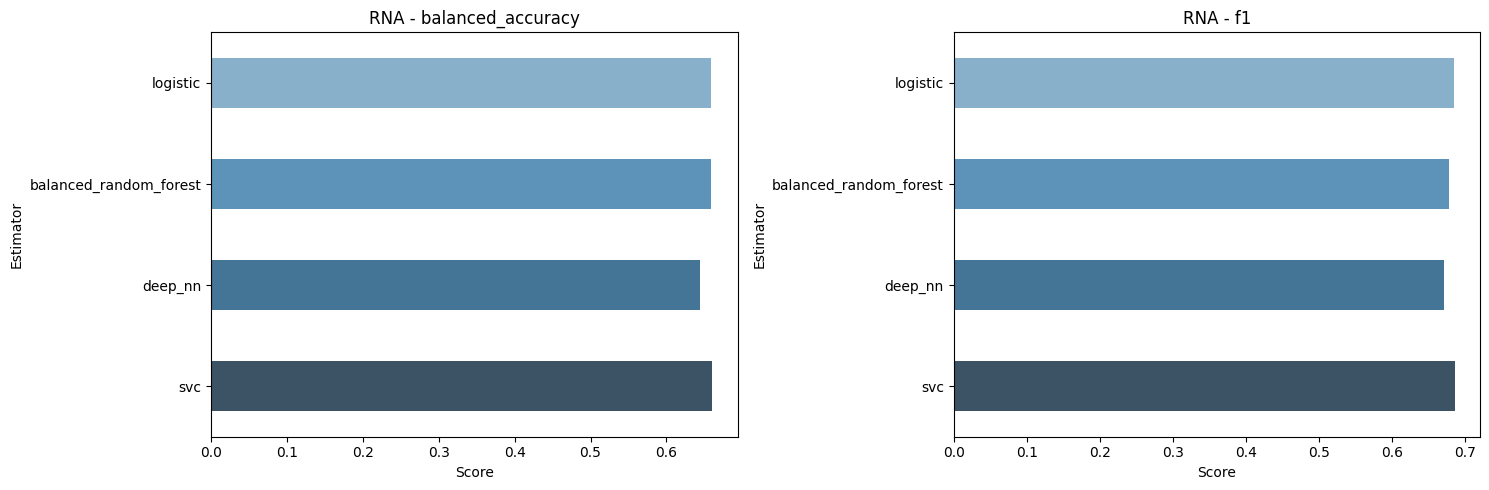

In [ ]:
plot_bar_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

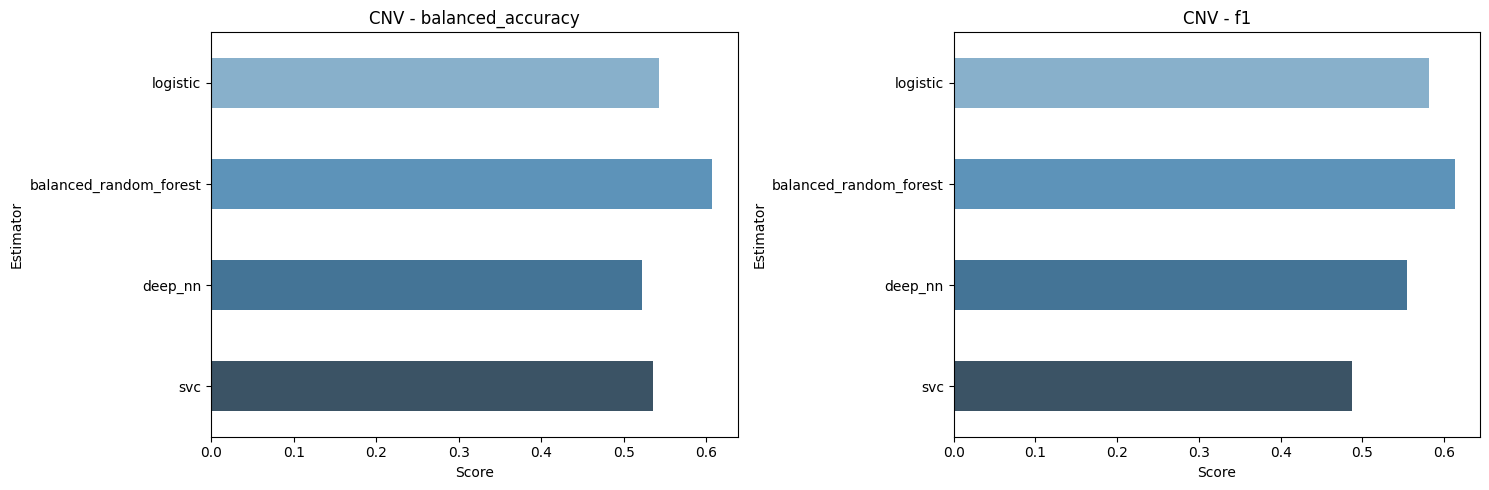

In [ ]:
plot_bar_scores(estimator_names, base_scores['cnv'], 'CNV', metrics=['balanced_accuracy', 'f1'])

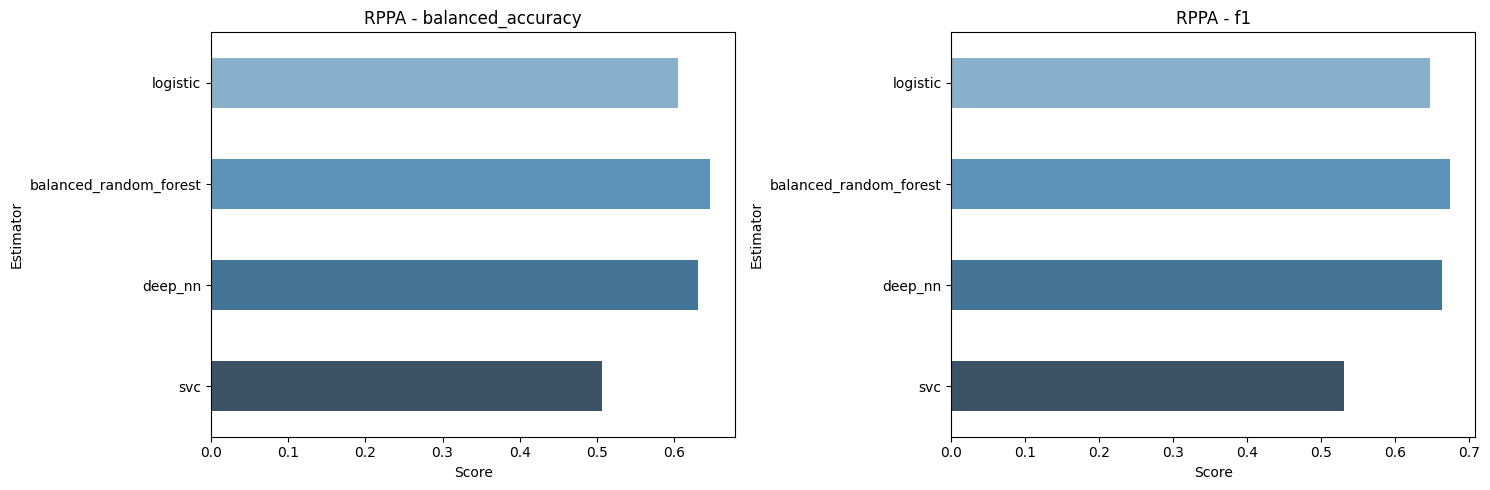

In [ ]:
plot_bar_scores(estimator_names, base_scores['rppa'], 'RPPA', metrics=['balanced_accuracy', 'f1'])

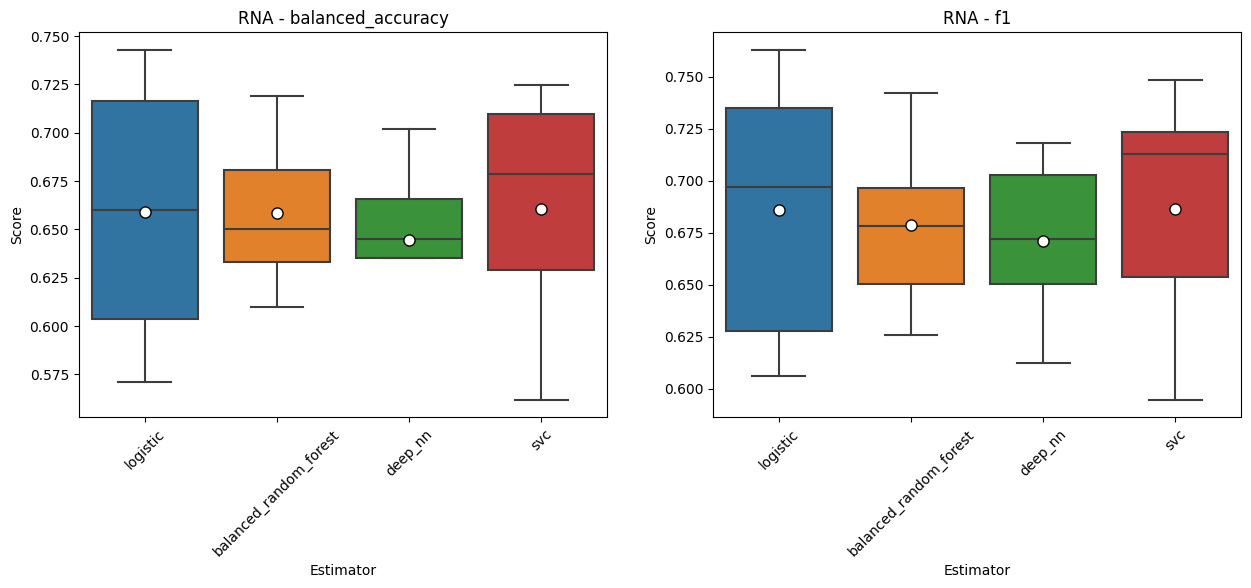

In [ ]:
plot_box_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

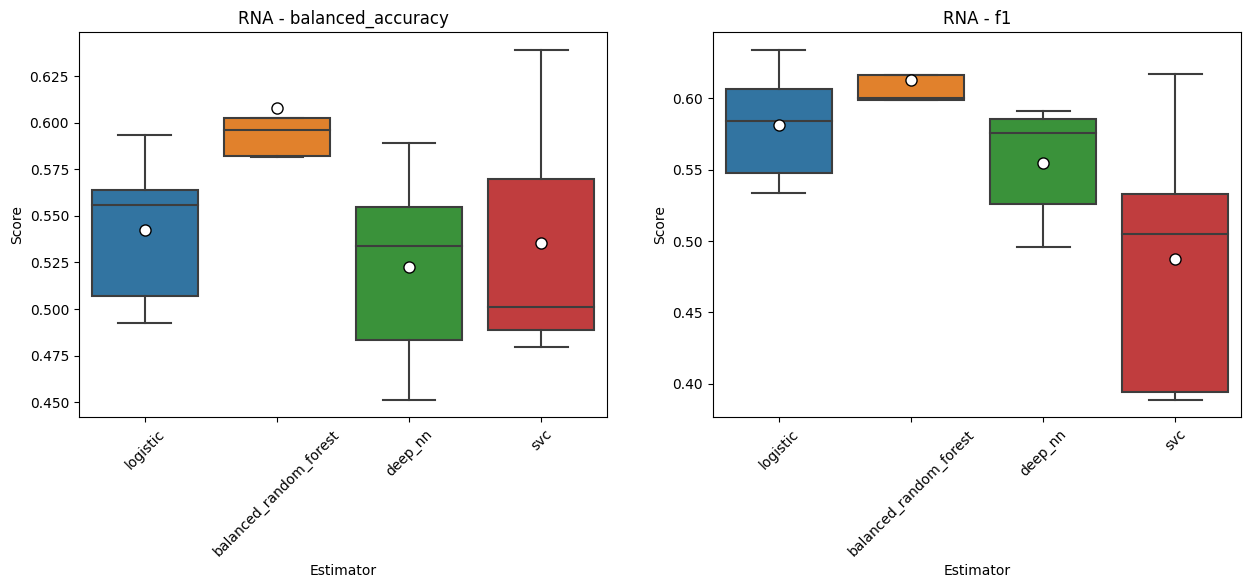

In [ ]:
plot_box_scores(estimator_names, base_scores['cnv'], 'RNA', metrics=['balanced_accuracy', 'f1'])

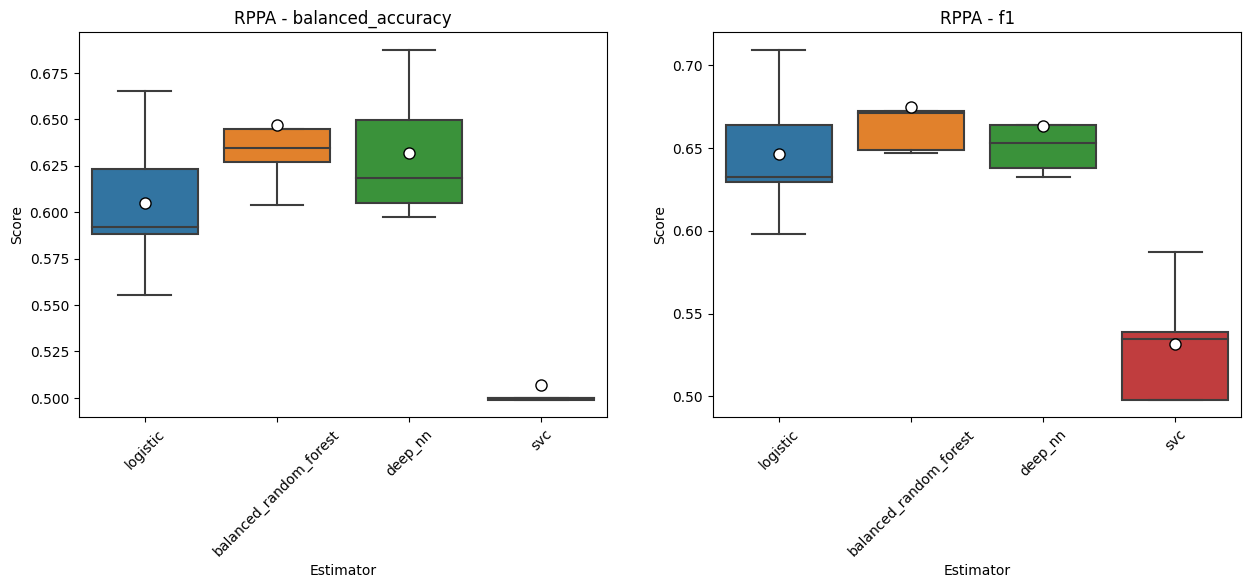

In [ ]:
plot_box_scores(estimator_names, base_scores['rppa'], 'RPPA', metrics=['balanced_accuracy', 'f1'])

## Modality Ensembles

In [ ]:
classifiers = {}

for modality in datasets:
    classifiers[modality] = ModalityPipeline(estimators, cv=3)

In [ ]:
modality_metrics = pd.DataFrame()
scores = {}

for modality in tqdm(datasets):
    scores[modality], df = get_cross_metrics(classifiers[modality], X[modality], y, modality, scoring=kipan_stage_scoring)
    modality_metrics = pd.concat([modality_metrics, df])

  0%|          | 0/3 [00:00<?, ?it/s]/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.w

In [ ]:
modality_metrics

accuracy balanced_accuracy               f1   recall (early)  \
rna   0.751 +/- 0.033   0.715 +/- 0.025  0.746 +/- 0.032  0.843 +/- 0.035   
cnv   0.633 +/- 0.066   0.549 +/- 0.022  0.590 +/- 0.056  0.850 +/- 0.104   
rppa  0.705 +/- 0.037   0.648 +/- 0.033  0.689 +/- 0.042  0.868 +/- 0.032   

        recall (late)  
rna   0.586 +/- 0.054  
cnv   0.247 +/- 0.101  
rppa  0.429 +/- 0.047

In [ ]:
import json
import numpy as np

# Convert and write JSON object to file
with open("results/kipan_modality_results.json", "w") as outfile:
    json.dump(scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)


In [ ]:
estimator_names = [
    "logistic",
    "balanced_random_forest",
    "deep_nn",
    "svc",
    "stacking"
]
all_scores = {}

for modality in base_scores:
    all_scores[modality] = {}
    for i in range(len(base_scores[modality])):
        all_scores[modality][estimator_names[i]] = base_scores[modality][i]

    all_scores[modality]['stacking'] = scores[modality]


In [ ]:
# Convert and write JSON object to file
with open("results/kipan_base_learner_modality_results.json", "w") as outfile:
    json.dump(all_scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

### Scoring

In [ ]:
all_metrics = {}

for modality in datasets:
    all_metrics[modality] = pd.concat([base_metrics_df[modality], modality_metrics.loc[[modality]]])
    all_metrics[modality].rename_axis(index={modality: 'stacking'}, inplace=True)

In [ ]:
display(all_metrics['rna'], all_metrics['cnv'], all_metrics['rppa'])

accuracy balanced_accuracy               f1  \
logistic                0.701 +/- 0.048   0.659 +/- 0.065  0.686 +/- 0.060   
balanced_random_forest  0.689 +/- 0.041   0.658 +/- 0.038  0.679 +/- 0.040   
deep_nn                 0.685 +/- 0.027   0.644 +/- 0.042  0.671 +/- 0.038   
svc                     0.702 +/- 0.037   0.661 +/- 0.059  0.687 +/- 0.055   
rna                     0.751 +/- 0.033   0.715 +/- 0.025  0.746 +/- 0.032   

                         recall (early)    recall (late)  
logistic                0.818 +/- 0.087  0.500 +/- 0.173  
balanced_random_forest  0.772 +/- 0.128  0.544 +/- 0.159  
deep_nn                 0.796 +/- 0.093  0.493 +/- 0.155  
svc                     0.818 +/- 0.082  0.504 +/- 0.177  
rna                     0.843 +/- 0.035  0.586 +/- 0.054

accuracy balanced_accuracy               f1  \
logistic                0.602 +/- 0.054   0.542 +/- 0.037  0.581 +/- 0.037   
balanced_random_forest  0.626 +/- 0.060   0.608 +/- 0.035  0.613 +/- 0.051   
deep_nn                 0.575 +/- 0.048   0.522 +/- 0.049  0.555 +/- 0.037   
svc                     0.499 +/- 0.074   0.536 +/- 0.061  0.488 +/- 0.087   
cnv                     0.633 +/- 0.066   0.549 +/- 0.022  0.590 +/- 0.056   

                         recall (early)    recall (late)  
logistic                0.766 +/- 0.113  0.319 +/- 0.076  
balanced_random_forest  0.678 +/- 0.194  0.537 +/- 0.198  
deep_nn                 0.719 +/- 0.123  0.326 +/- 0.160  
svc                     0.397 +/- 0.154  0.674 +/- 0.144  
cnv                     0.850 +/- 0.104  0.247 +/- 0.101

accuracy balanced_accuracy               f1  \
logistic                0.664 +/- 0.038   0.605 +/- 0.037  0.647 +/- 0.038   
balanced_random_forest  0.682 +/- 0.027   0.647 +/- 0.041  0.674 +/- 0.031   
deep_nn                 0.670 +/- 0.038   0.632 +/- 0.033  0.663 +/- 0.035   
svc                     0.529 +/- 0.036   0.507 +/- 0.028  0.531 +/- 0.033   
rppa                    0.705 +/- 0.037   0.648 +/- 0.033  0.689 +/- 0.042   

                         recall (early)    recall (late)  
logistic                0.828 +/- 0.041  0.381 +/- 0.038  
balanced_random_forest  0.779 +/- 0.066  0.515 +/- 0.127  
deep_nn                 0.774 +/- 0.073  0.489 +/- 0.072  
svc                     0.588 +/- 0.080  0.426 +/- 0.071  
rppa                    0.868 +/- 0.032  0.429 +/- 0.047

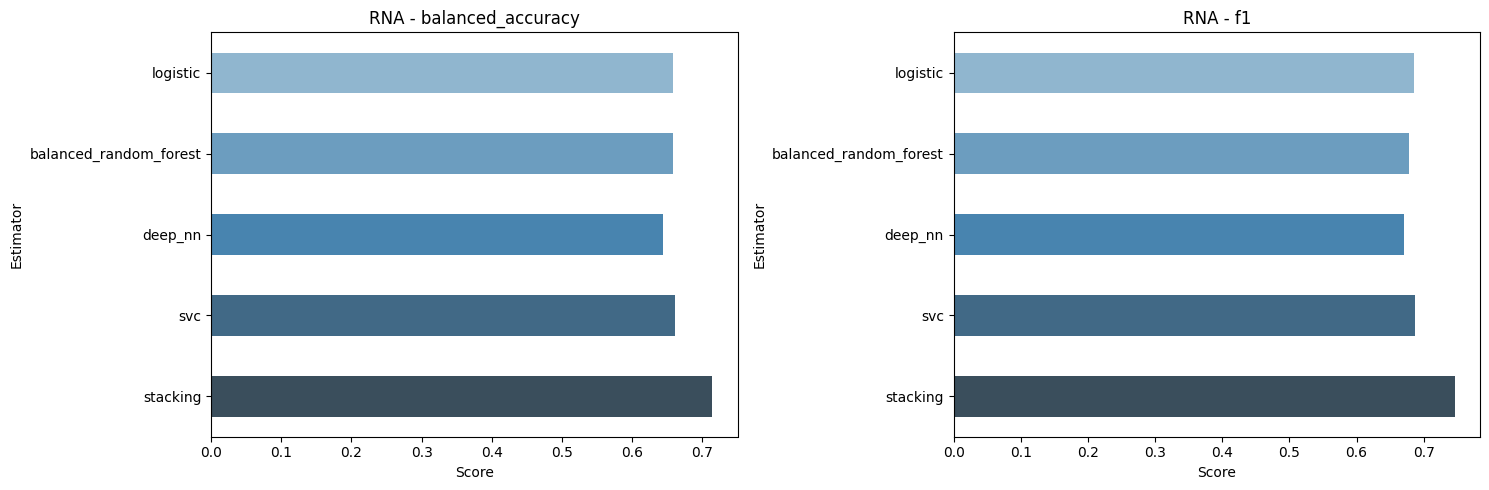

In [ ]:
plot_bar_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

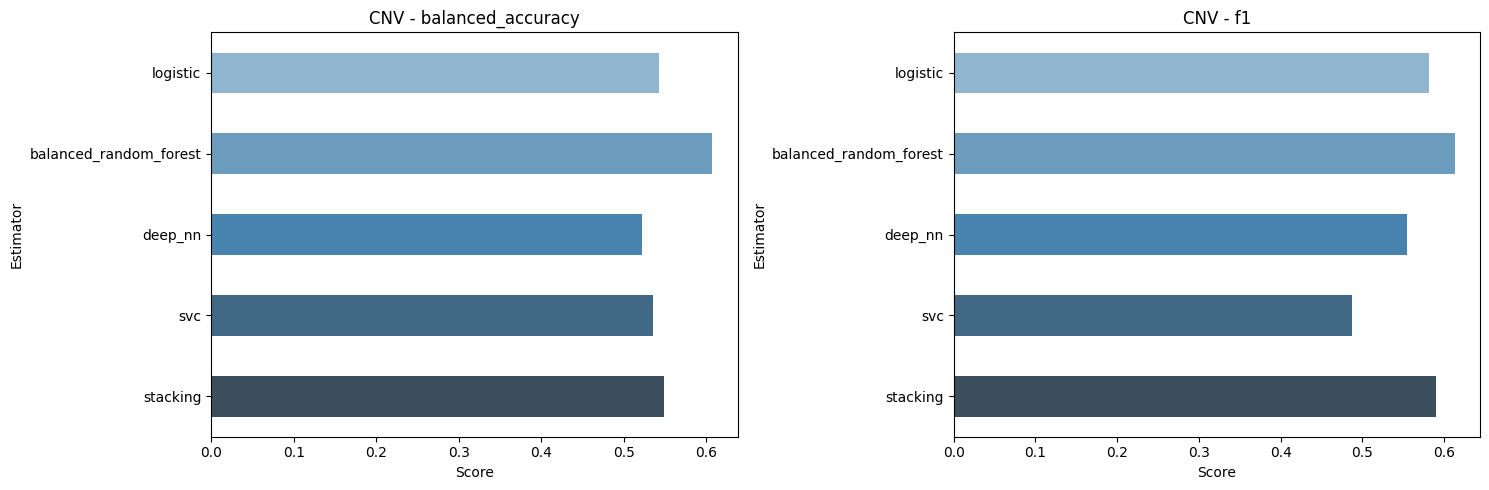

In [ ]:
plot_bar_scores(estimator_names, base_scores['cnv'], 'CNV', metrics=['balanced_accuracy', 'f1'])

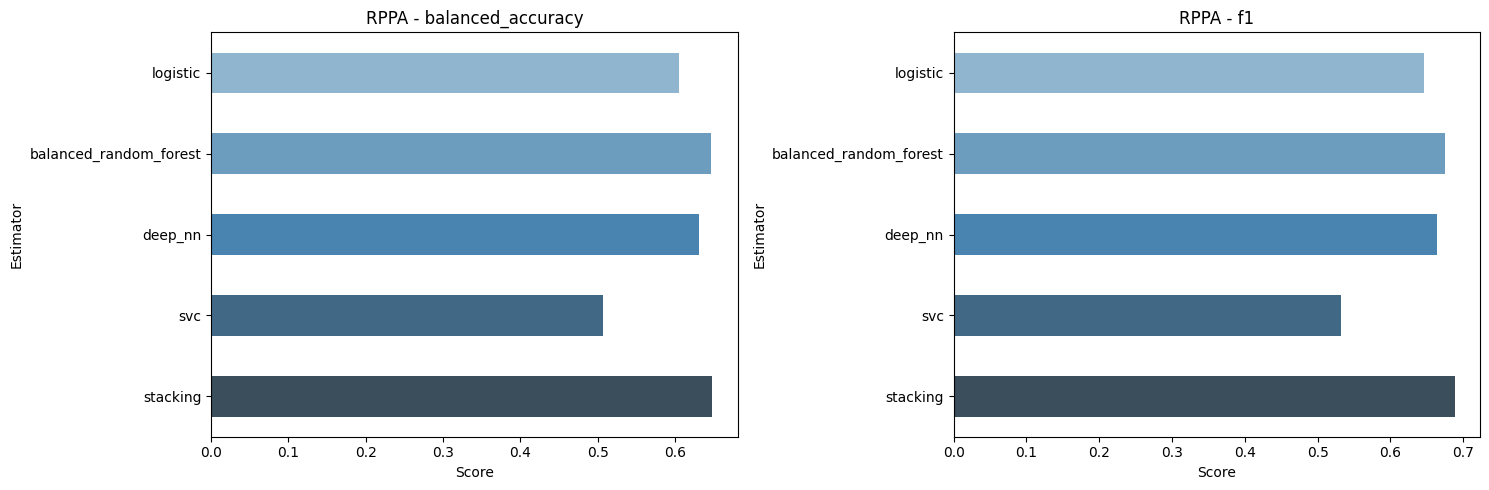

In [ ]:
plot_bar_scores(estimator_names, base_scores['rppa'], 'RPPA', metrics=['balanced_accuracy', 'f1'])

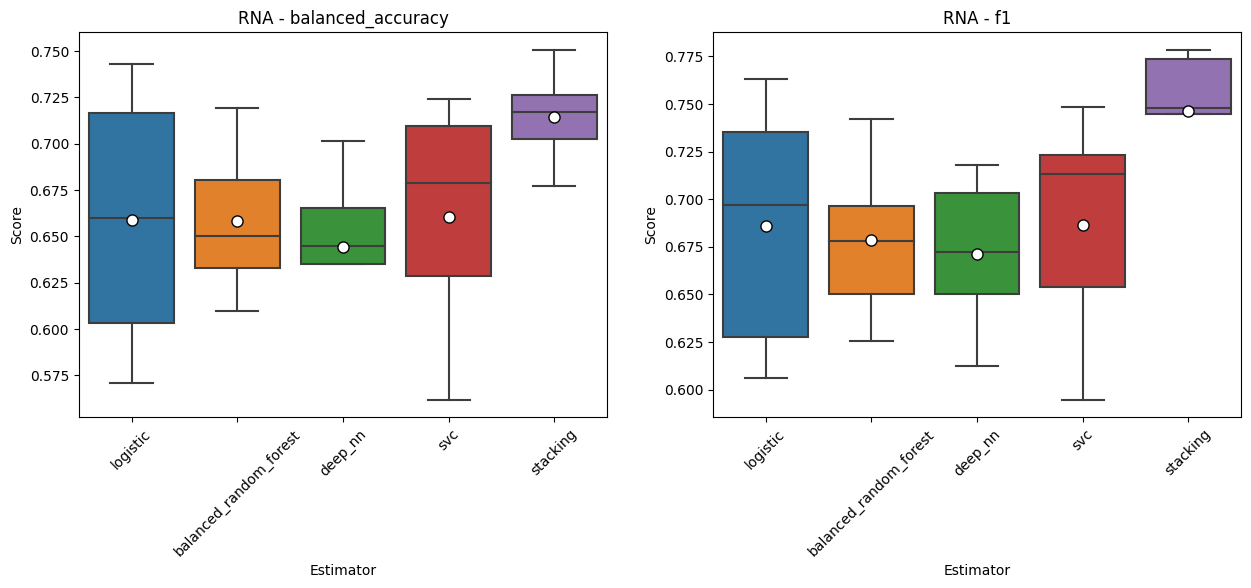

In [ ]:
plot_box_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

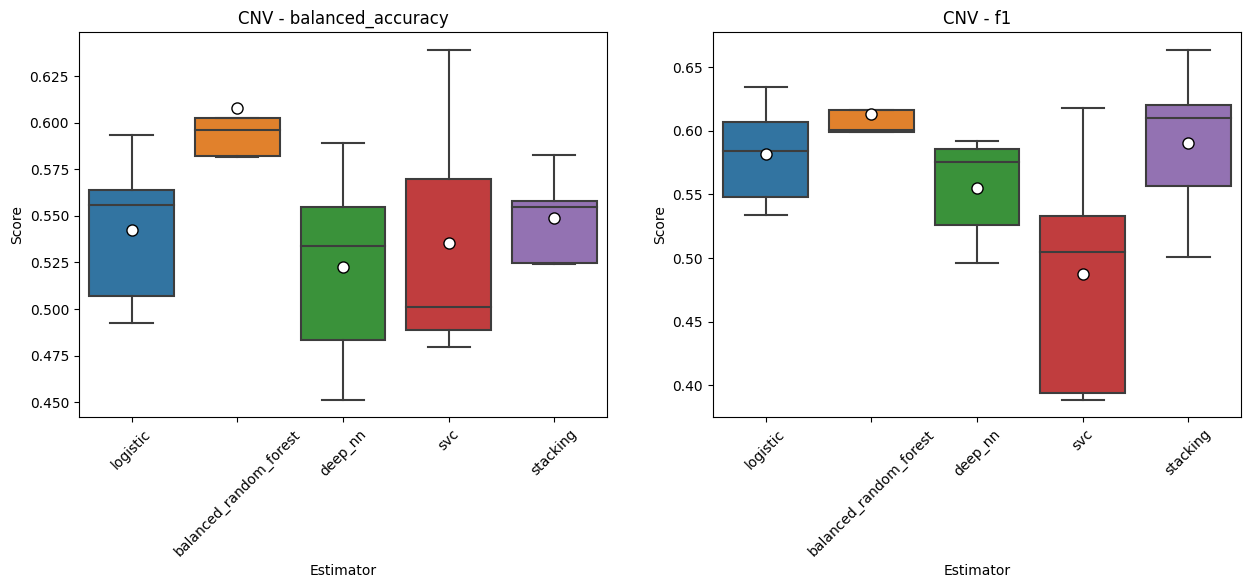

In [ ]:
plot_box_scores(estimator_names, base_scores['cnv'], 'CNV', metrics=['balanced_accuracy', 'f1'])

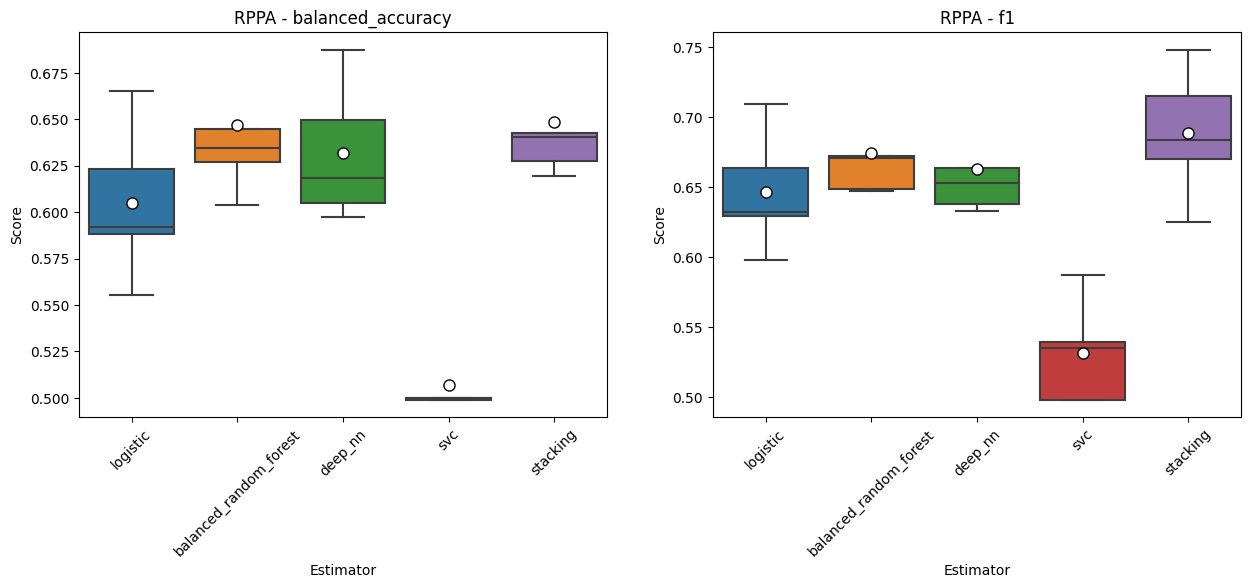

In [ ]:
plot_box_scores(estimator_names, base_scores['rppa'], 'RPPA', metrics=['balanced_accuracy', 'f1'])

## Multi Omics Integration Ensemble

In [ ]:
column_names = {}

for key in X.keys():
    column_names[key] = X[key].columns

In [ ]:
meta_ensembles = {}
meta_ensembles['rna + cnv + rppa'] = MultiOmicsIntegrationClassifier(classifiers, cv=3)
meta_ensembles['cnv + rppa'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['cnv', 'rppa']}, cv=3)
meta_ensembles['rna + cnv'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['rna', 'cnv']}, cv=3)
meta_ensembles['rna + rppa'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['rna', 'rppa']}, cv=3)

In [ ]:
X_merged = {}
X_merged['rna + cnv + rppa'] = pd.concat([X['rna'], X['cnv'], X['rppa']], axis=1, join='inner')
X_merged['cnv + rppa'] = pd.concat([X['cnv'], X['rppa']], axis=1, join='inner')
X_merged['rna + cnv'] = pd.concat([X['rna'], X['cnv']], axis=1, join='inner')
X_merged['rna + rppa'] = pd.concat([X['rna'], X['rppa']], axis=1, join='inner')


In [ ]:
integration_scores = {}
integration_metrics = {}

In [ ]:
integration_scores['rna + cnv + rppa'], integration_metrics['rna + cnv + rppa'] = get_cross_metrics(meta_ensembles['rna + cnv + rppa'], X_merged['rna + cnv + rppa'], y, name='rna + cnv + rppa', cv=5, verbose=2, scoring=kipan_stage_scoring, fit_params={'column_names': column_names})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings

[CV] END .................................................... total time=22.2min


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .................................................... total time=23.2min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 23.4min remaining: 35.0min
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .................................................... total time=23.6min
[CV] END .................................................... total time=23.8min
[CV] END .................................................... total time=24.0min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 24.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 24.1min finished


In [ ]:
integration_scores['cnv + rppa'], integration_metrics['cnv + rppa'] = get_cross_metrics(meta_ensembles['cnv + rppa'], X_merged['cnv + rppa'], y, name='cnv + rppa', cv=5, verbose=2, scoring=kipan_stage_scoring, fit_params={'column_names': {key: column_names[key] for key in ['cnv', 'rppa']}})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings

[CV] END .................................................... total time= 5.7min


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .................................................... total time= 5.8min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.8min remaining:  8.7min
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .................................................... total time= 5.8min


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn

[CV] END .................................................... total time= 6.5min


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users

[CV] END .................................................... total time= 6.9min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.9min finished


In [ ]:
integration_scores['rna + rppa'], integration_metrics['rna + rppa'] = get_cross_metrics(meta_ensembles['rna + rppa'], X_merged['rna + rppa'], y, name='rna + rppa', cv=5, verbose=2, scoring=kipan_stage_scoring, fit_params={'column_names': {key: column_names[key] for key in ['rna', 'rppa']}})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users

[CV] END .................................................... total time=12.2min


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn

[CV] END .................................................... total time=13.3min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 13.4min remaining: 20.1min
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .................................................... total time=13.6min
[CV] END .................................................... total time=13.8min
[CV] END .................................................... total time=14.0min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 14.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 14.1min finished


In [ ]:
integration_scores['rna + cnv'], integration_metrics['rna + cnv'] = get_cross_metrics(meta_ensembles['rna + cnv'], X_merged['rna + cnv'], y, name='rna + cnv', cv=5, verbose=2, scoring=kipan_stage_scoring, fit_params={'column_names': {key: column_names[key] for key in ['rna', 'cnv']}})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with Stand

[CV] END .................................................... total time=20.8min


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .................................................... total time=22.5min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 22.6min remaining: 34.0min
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .................................................... total time=23.2min
[CV] END .................................................... total time=23.5min
[CV] END .................................................... total time=23.8min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 23.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 23.9min finished


In [ ]:
all_integration_metrics = pd.concat([modality_metrics, pd.concat([x for x in integration_metrics.values()])])
names = ['rna', 'cnv', 'rppa', 'rna + cnv + rppa', 'cnv + rppa', 'rna + rppa', 'rna + cnv']

all_integration_scores = scores

# Adding multi-omic ensemble scores
for name, value in integration_scores.items():
    all_integration_scores[name] = value

In [ ]:
integration_scores

{'rna + cnv + rppa': {'fit_time': array([1413.77401114, 1428.02523708, 1438.75724316, 1390.76214004,
         1325.97617197]),
  'score_time': array([3.41427898, 2.1368382 , 1.79120994, 4.19281602, 4.6462009 ]),
  'test_accuracy': array([0.77702703, 0.66666667, 0.7414966 , 0.76870748, 0.79591837]),
  'test_balanced_accuracy': array([0.74728261, 0.64043675, 0.71445176, 0.73752577, 0.72142857]),
  'test_f1': array([0.77248434, 0.65044092, 0.73617813, 0.76752742, 0.78892185]),
  'test_recall (early)': array([0.86956522, 0.84337349, 0.84269663, 0.83505155, 0.8952381 ]),
  'test_recall (late)': array([0.625     , 0.4375    , 0.5862069 , 0.64      , 0.54761905])},
 'cnv + rppa': {'fit_time': array([338.62985277, 350.32307124, 347.12935901, 389.05043721,
         415.75368381]),
  'score_time': array([0.60589314, 0.40479374, 0.47138214, 0.2795608 , 0.23695016]),
  'test_accuracy': array([0.70945946, 0.6462585 , 0.70068027, 0.71428571, 0.73469388]),
  'test_balanced_accuracy': array([0.6754658

In [ ]:
import json
import numpy as np
# Convert and write JSON object to file
with open("results/kipan_multi_omics_results.json", "w") as outfile:
    json.dump(integration_scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)


In [ ]:
# Convert and write JSON object to file
with open("results/kipan_modality_multi_omics_results.json", "w") as outfile:
    json.dump(all_integration_scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

In [ ]:
all_integration_metrics

accuracy balanced_accuracy               f1  \
rna               0.751 +/- 0.033   0.715 +/- 0.025  0.746 +/- 0.032   
cnv               0.633 +/- 0.066   0.549 +/- 0.022  0.590 +/- 0.056   
rppa              0.705 +/- 0.037   0.648 +/- 0.033  0.689 +/- 0.042   
rna + cnv + rppa  0.750 +/- 0.045   0.712 +/- 0.038  0.743 +/- 0.049   
cnv + rppa        0.701 +/- 0.030   0.648 +/- 0.022  0.686 +/- 0.039   
rna + rppa        0.754 +/- 0.044   0.715 +/- 0.037  0.746 +/- 0.048   
rna + cnv         0.742 +/- 0.031   0.703 +/- 0.022  0.736 +/- 0.031   

                   recall (early)    recall (late)  
rna               0.843 +/- 0.035  0.586 +/- 0.054  
cnv               0.850 +/- 0.104  0.247 +/- 0.101  
rppa              0.868 +/- 0.032  0.429 +/- 0.047  
rna + cnv + rppa  0.857 +/- 0.022  0.567 +/- 0.072  
cnv + rppa        0.853 +/- 0.025  0.444 +/- 0.069  
rna + rppa        0.866 +/- 0.030  0.564 +/- 0.072  
rna + cnv         0.841 +/- 0.032  0.564 +/- 0.058

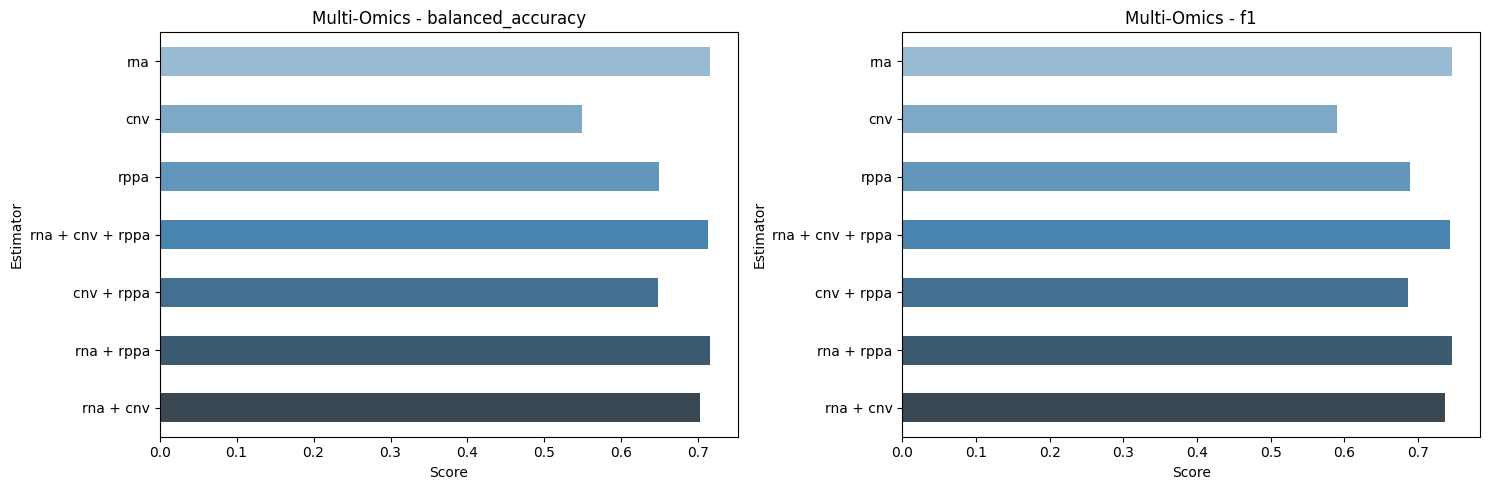

In [ ]:
plot_bar_scores(names, all_integration_scores, 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

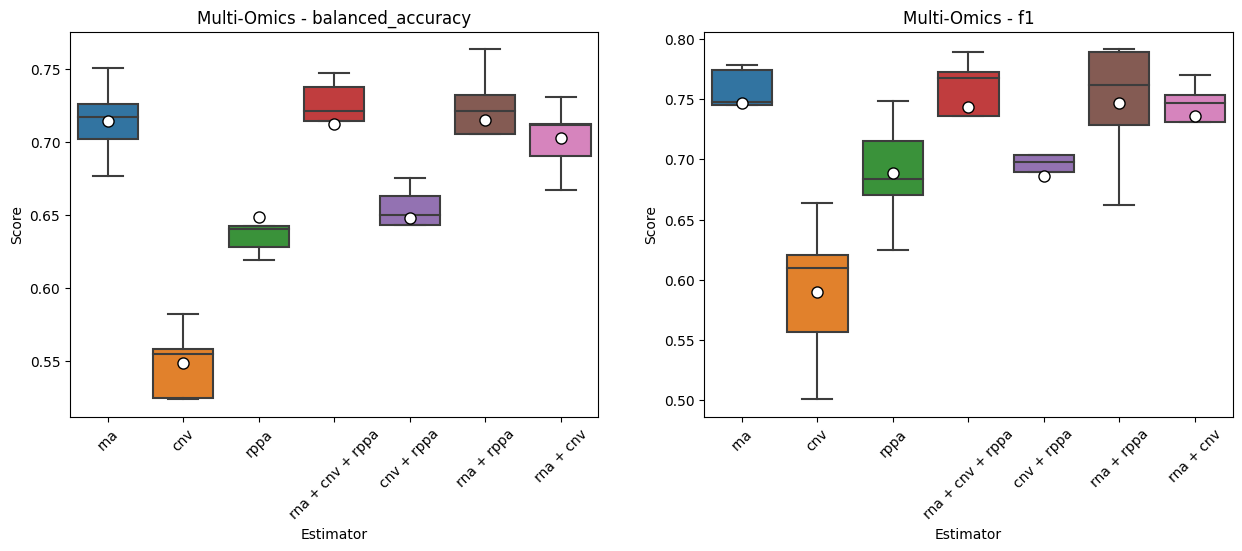

In [ ]:
plot_box_scores(names, all_integration_scores, 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

# Staging (RNA, Methylation, RPPA)

In [ ]:
datasets = {
            'rna': '../data/kipan/staging/RNASeq.csv',
            'meth': '../data/kipan/staging/Methylation.csv',
            'rppa': '../data/kipan/staging/RPPA.csv',
}

labels = '../data/kipan/staging/Clinical.csv'

In [ ]:
subtypes = pd.read_csv(labels, index_col=0)
data = {}

for modality in datasets:
    data[modality] = pd.read_csv(datasets[modality], index_col=0)
    print(modality, data[modality].shape)

rna (558, 20190)
meth (558, 20116)
rppa (558, 202)


## Preprocessing

### Removing low-variance + null features

In [ ]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold(X, percentage=0.10):
    var_thr = VarianceThreshold(threshold=percentage) #Removing both constant and quasi-constant (less than 1% variance)

    X_new = var_thr.fit_transform(X)

    column_names = X.columns[var_thr.get_support()]

    return pd.DataFrame(X_new, columns=column_names)

In [ ]:
new_data = {}
for modality in data:
    new_data[modality] = variance_threshold(data[modality], percentage=0.05)
    print(modality, new_data[modality].shape)

rna (558, 19365)
meth (558, 828)
rppa (558, 150)


In [ ]:
import pandas as pd

X = {}

# Convert numpy array to DataFrame
for modality in new_data:
    X[modality] = pd.DataFrame(new_data[modality])
    X[modality] = X[modality].dropna(axis=1)
    print(modality, X[modality].shape)

rna (558, 19365)
meth (558, 781)
rppa (558, 128)


In [ ]:
stages = pd.read_csv(labels, index_col=0)['pathologic_stage']
stages.value_counts()

stagei      280
stageiii    129
stageiv      79
stageii      70
Name: pathologic_stage, dtype: int64

In [ ]:
enc = LabelEncoder()
y = enc.fit_transform(stages)
enc.inverse_transform([0, 1, 2, 3])

array(['stagei', 'stageii', 'stageiii', 'stageiv'], dtype=object)

In [ ]:
# Assuming your array is named 'arr'
y = np.where(np.logical_or(y == 0, y == 1), 0, 1)

In [ ]:
unique, counts = np.unique(y, return_counts=True)
np.asarray((unique, counts)).T

array([[  0, 350],
       [  1, 208]])

## Base Learners

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

estimators = [
    ("logistic", make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=1000, n_jobs=-1))),
    ("balanced_random_forest", BalancedRandomForestClassifier(random_state=0, n_jobs=-1, sampling_strategy='all', replacement=True)),
    ("deep_nn", make_pipeline(StandardScaler(), MLPClassifier(random_state=0))),
    ("svc", make_pipeline(StandardScaler(), SVC(random_state=0, kernel='linear', max_iter=1000)))
]

estimator_names = [estimator[0] for estimator in estimators]

In [ ]:
kipan_stage_scoring = {"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (early)': make_scorer(recall_multiclass, label=0), 'recall (late)': make_scorer(recall_multiclass, label=1)}

In [ ]:
base_scores = {}
base_metrics_df = {}
base_metrics_df_train = {}

for modality in datasets:
    base_scores[modality], base_metrics_df[modality] = get_individual_scores(X[modality], y, estimators, scoring=kipan_stage_scoring)

In [ ]:
display(base_metrics_df['rna']), display(base_metrics_df['meth']), display(base_metrics_df['rppa'])

accuracy balanced_accuracy               f1  \
logistic                0.776 +/- 0.018   0.751 +/- 0.024  0.773 +/- 0.020   
balanced_random_forest  0.742 +/- 0.013   0.726 +/- 0.015  0.742 +/- 0.013   
deep_nn                 0.738 +/- 0.032   0.712 +/- 0.029  0.736 +/- 0.031   
svc                     0.769 +/- 0.015   0.746 +/- 0.021  0.767 +/- 0.017   

                         recall (early)    recall (late)  
logistic                0.849 +/- 0.017  0.654 +/- 0.053  
balanced_random_forest  0.789 +/- 0.039  0.663 +/- 0.054  
deep_nn                 0.814 +/- 0.055  0.610 +/- 0.050  
svc                     0.834 +/- 0.007  0.659 +/- 0.046

accuracy balanced_accuracy               f1  \
logistic                0.699 +/- 0.032   0.672 +/- 0.025  0.697 +/- 0.029   
balanced_random_forest  0.755 +/- 0.026   0.742 +/- 0.031  0.755 +/- 0.026   
deep_nn                 0.722 +/- 0.022   0.692 +/- 0.018  0.718 +/- 0.020   
svc                     0.701 +/- 0.034   0.679 +/- 0.032  0.700 +/- 0.032   

                         recall (early)    recall (late)  
logistic                0.777 +/- 0.055  0.567 +/- 0.013  
balanced_random_forest  0.791 +/- 0.031  0.693 +/- 0.065  
deep_nn                 0.811 +/- 0.040  0.572 +/- 0.022  
svc                     0.766 +/- 0.052  0.592 +/- 0.049

accuracy balanced_accuracy               f1  \
logistic                0.661 +/- 0.039   0.624 +/- 0.042  0.655 +/- 0.039   
balanced_random_forest  0.724 +/- 0.035   0.703 +/- 0.031  0.723 +/- 0.033   
deep_nn                 0.706 +/- 0.025   0.674 +/- 0.020  0.701 +/- 0.020   
svc                     0.507 +/- 0.026   0.480 +/- 0.034  0.509 +/- 0.027   

                         recall (early)    recall (late)  
logistic                0.769 +/- 0.038  0.480 +/- 0.063  
balanced_random_forest  0.786 +/- 0.053  0.620 +/- 0.030  
deep_nn                 0.800 +/- 0.062  0.548 +/- 0.063  
svc                     0.589 +/- 0.021  0.371 +/- 0.072

(None, None, None)

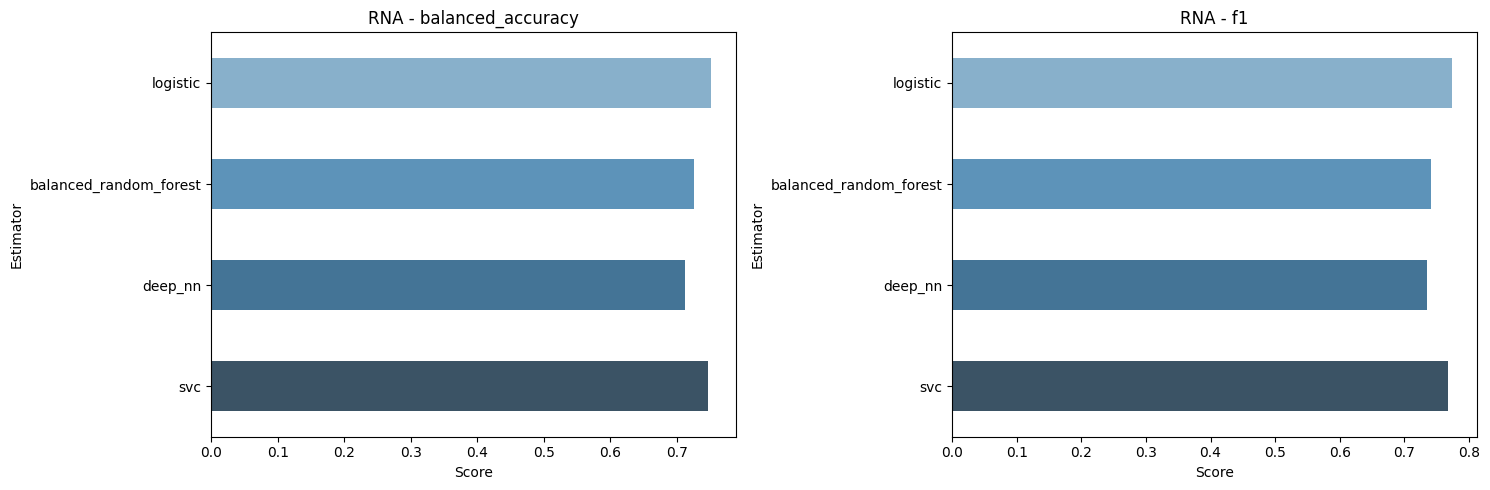

In [ ]:
plot_bar_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

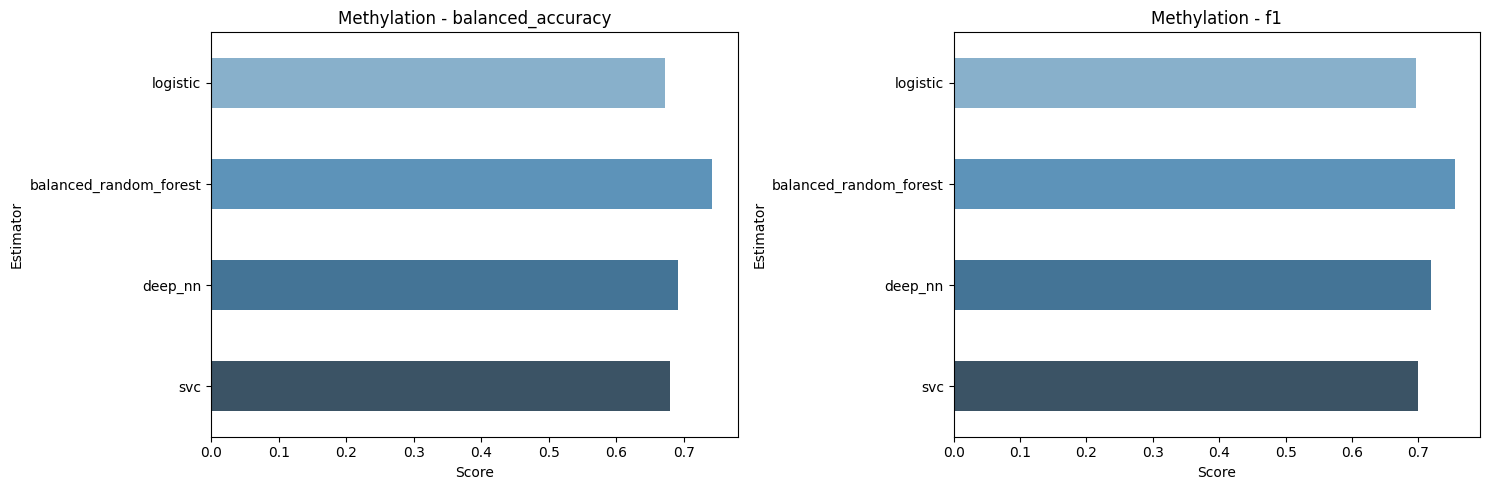

In [ ]:
plot_bar_scores(estimator_names, base_scores['meth'], 'Methylation', metrics=['balanced_accuracy', 'f1'])

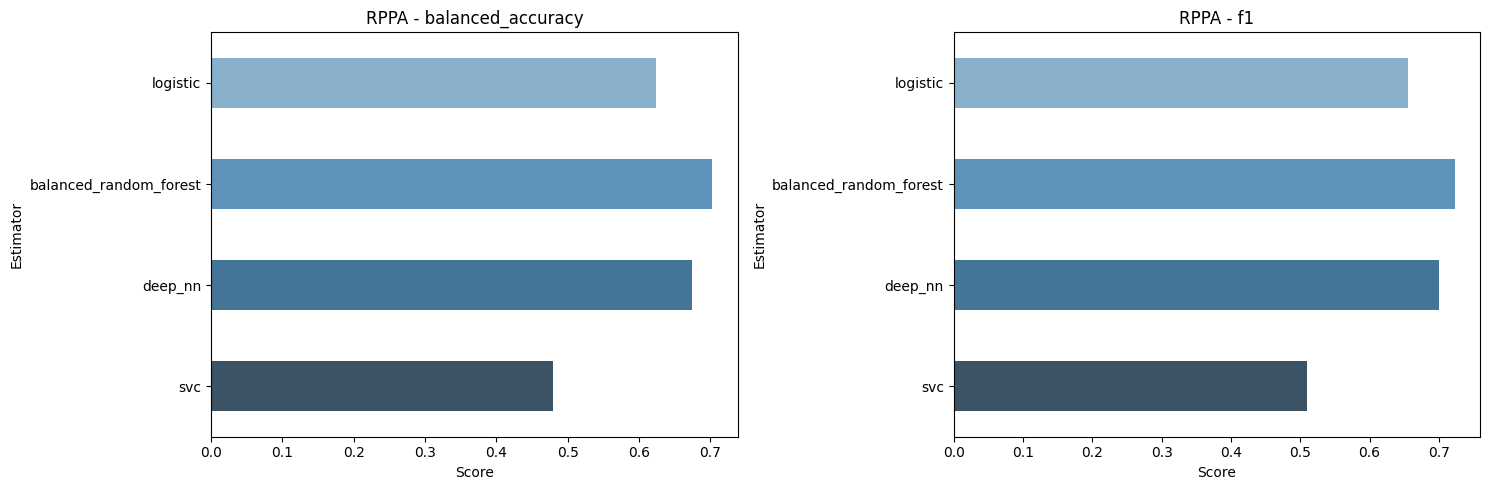

In [ ]:
plot_bar_scores(estimator_names, base_scores['rppa'], 'RPPA', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:170: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:170: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


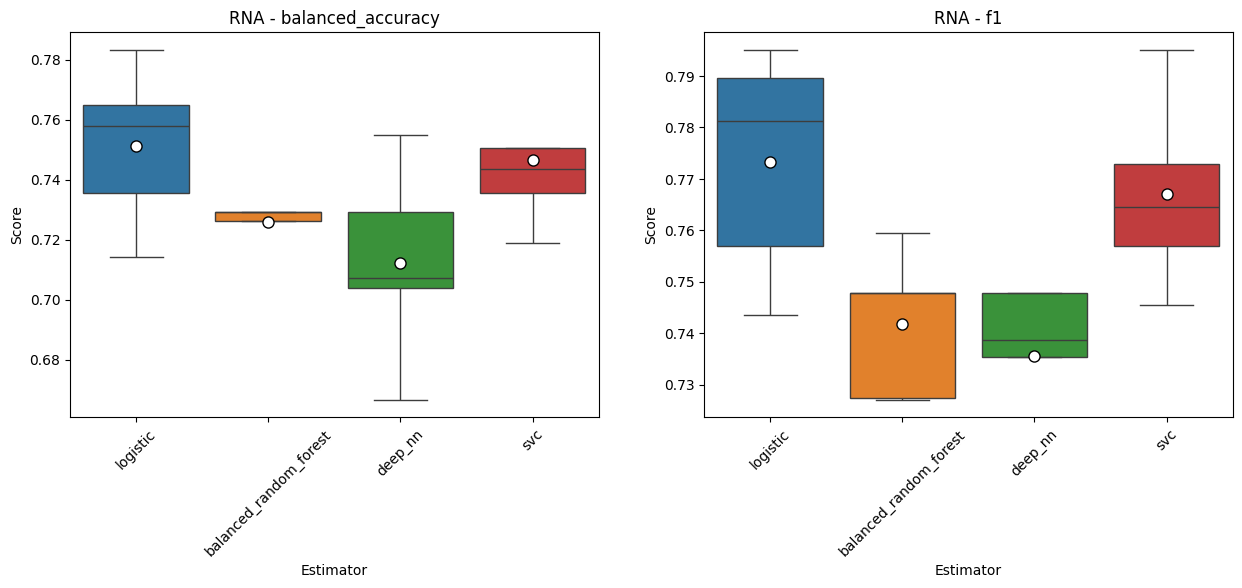

In [ ]:
plot_box_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:170: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:170: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


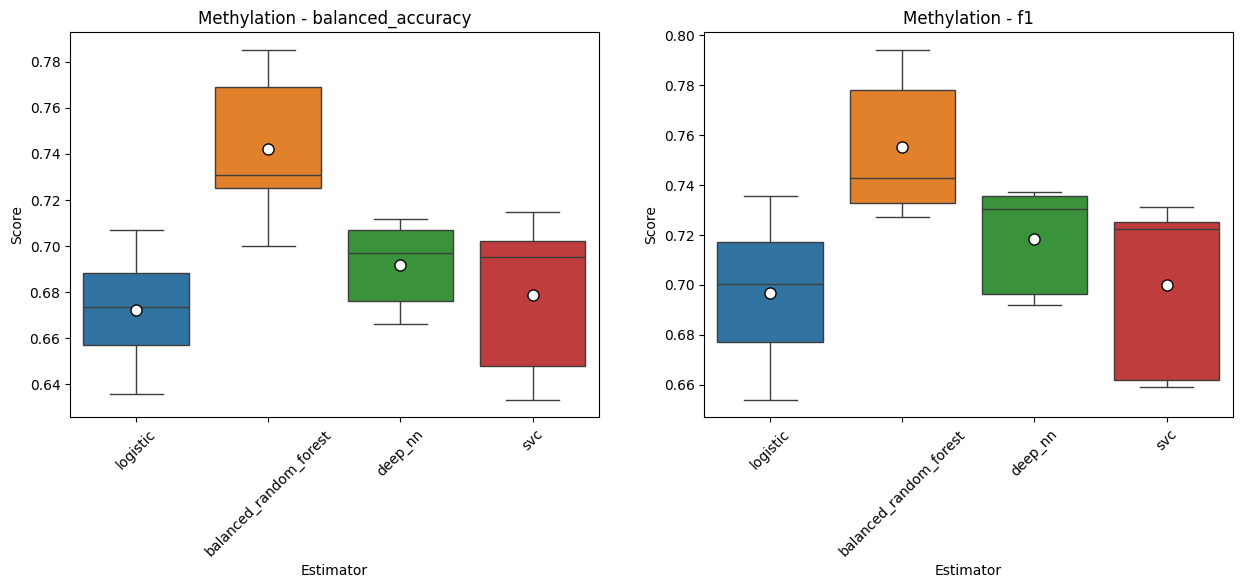

In [ ]:
plot_box_scores(estimator_names, base_scores['meth'], 'Methylation', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:170: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:170: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


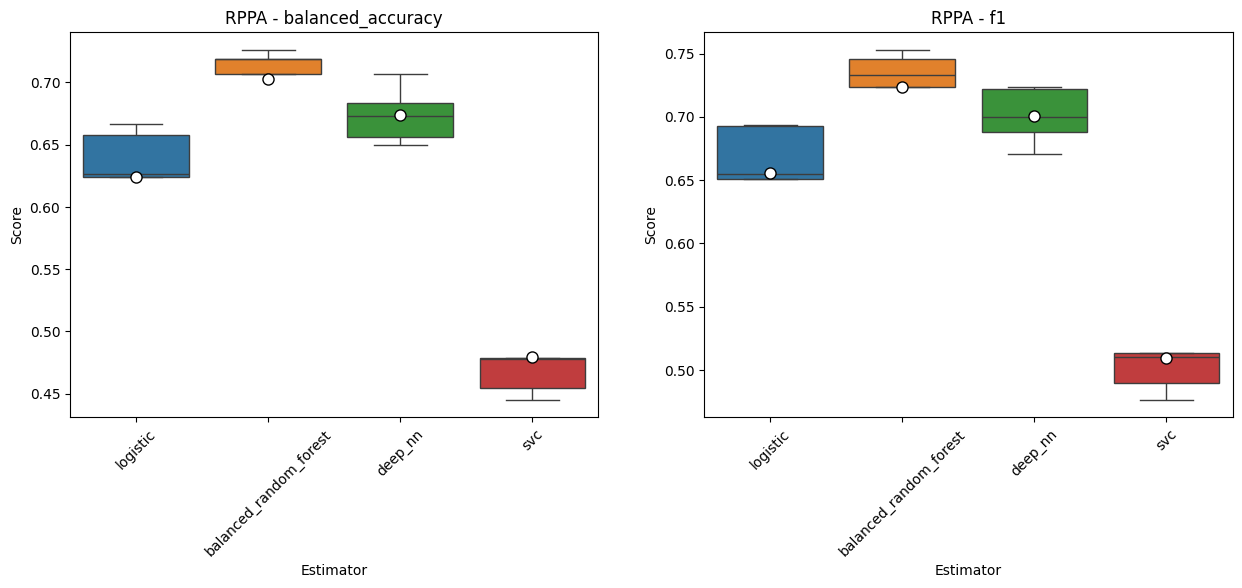

In [ ]:
plot_box_scores(estimator_names, base_scores['rppa'], 'RPPA', metrics=['balanced_accuracy', 'f1'])

## Modality Ensembles

In [ ]:
classifiers = {}

for modality in datasets:
    classifiers[modality] = ModalityPipeline(estimators, cv=3)

In [ ]:
modality_metrics = pd.DataFrame()
modality_scores = {}

for modality in tqdm(datasets):
    moadality_scores[modality], df = get_cross_metrics(classifiers[modality], X[modality], y, modality, scoring=kipan_stage_scoring)
    modality_metrics = pd.concat([modality_metrics, df])

  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 3/3 [09:37<00:00, 192.54s/it]


In [ ]:
modality_metrics

accuracy balanced_accuracy               f1   recall (early)  \
rna   0.772 +/- 0.018   0.747 +/- 0.021  0.770 +/- 0.019  0.846 +/- 0.017   
meth  0.728 +/- 0.022   0.699 +/- 0.016  0.724 +/- 0.020  0.811 +/- 0.042   
rppa  0.720 +/- 0.024   0.673 +/- 0.024  0.708 +/- 0.023  0.860 +/- 0.040   

        recall (late)  
rna   0.649 +/- 0.039  
meth  0.587 +/- 0.015  
rppa  0.485 +/- 0.046

In [ ]:
# Convert and write JSON object to file
with open("results/kipan/staging/kipan_modality_results_2.json", "w") as outfile:
    json.dump(modality_scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)


In [ ]:
estimator_names = [
    "logistic",
    "balanced_random_forest",
    "deep_nn",
    "svc",
    "stacking"
]
all_scores = {}

for modality in base_scores:
    all_scores[modality] = {}
    for i in range(len(base_scores[modality])):
        all_scores[modality][estimator_names[i]] = base_scores[modality][i]

    all_scores[modality]['stacking'] = modality_scores[modality]


In [ ]:
# Convert and write JSON object to file
with open("results/kipan_base_learner_modality_results_2.json", "w") as outfile:
    json.dump(all_scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

In [ ]:
# Run this if continuing an already saved run:
with open("results/kipan/staging/kipan_modality_results_2.json",'r+') as file:
    modality_scores = json.load(file)
    modality_metrics = pd.DataFrame()

    for model in modality_scores:
      metrics = {}

      for scorer in kipan_stage_scoring:
        metrics[scorer] = []

      for scorer in kipan_stage_scoring:
          metrics[scorer].append(
              "%0.3f +/- %0.3f"
              % (np.mean(modality_scores[model]["test_%s" % scorer]), np.std(modality_scores[model]["test_%s" % scorer]))
      )
      modality_metrics = pd.concat([modality_metrics, pd.DataFrame(metrics, index=[model])])

### Scoring

In [ ]:
all_metrics = {}

for modality in datasets:
    all_metrics[modality] = pd.concat([base_metrics_df[modality], modality_metrics.loc[[modality]]])
    all_metrics[modality].rename_axis(index={modality: 'stacking'}, inplace=True)

In [ ]:
display(all_metrics['rna'], all_metrics['meth'], all_metrics['rppa'])

accuracy balanced_accuracy               f1  \
logistic                0.776 +/- 0.018   0.751 +/- 0.024  0.773 +/- 0.020   
balanced_random_forest  0.742 +/- 0.013   0.726 +/- 0.015  0.742 +/- 0.013   
deep_nn                 0.738 +/- 0.032   0.712 +/- 0.029  0.736 +/- 0.031   
svc                     0.769 +/- 0.015   0.746 +/- 0.021  0.767 +/- 0.017   
rna                     0.772 +/- 0.018   0.747 +/- 0.021  0.770 +/- 0.019   

                         recall (early)    recall (late)  
logistic                0.849 +/- 0.017  0.654 +/- 0.053  
balanced_random_forest  0.789 +/- 0.039  0.663 +/- 0.054  
deep_nn                 0.814 +/- 0.055  0.610 +/- 0.050  
svc                     0.834 +/- 0.007  0.659 +/- 0.046  
rna                     0.846 +/- 0.017  0.649 +/- 0.039

accuracy balanced_accuracy               f1  \
logistic                0.699 +/- 0.032   0.672 +/- 0.025  0.697 +/- 0.029   
balanced_random_forest  0.755 +/- 0.026   0.742 +/- 0.031  0.755 +/- 0.026   
deep_nn                 0.722 +/- 0.022   0.692 +/- 0.018  0.718 +/- 0.020   
svc                     0.701 +/- 0.034   0.679 +/- 0.032  0.700 +/- 0.032   
meth                    0.728 +/- 0.022   0.699 +/- 0.016  0.724 +/- 0.020   

                         recall (early)    recall (late)  
logistic                0.777 +/- 0.055  0.567 +/- 0.013  
balanced_random_forest  0.791 +/- 0.031  0.693 +/- 0.065  
deep_nn                 0.811 +/- 0.040  0.572 +/- 0.022  
svc                     0.766 +/- 0.052  0.592 +/- 0.049  
meth                    0.811 +/- 0.042  0.587 +/- 0.015

accuracy balanced_accuracy               f1  \
logistic                0.661 +/- 0.039   0.624 +/- 0.042  0.655 +/- 0.039   
balanced_random_forest  0.724 +/- 0.035   0.703 +/- 0.031  0.723 +/- 0.033   
deep_nn                 0.706 +/- 0.025   0.674 +/- 0.020  0.701 +/- 0.020   
svc                     0.507 +/- 0.026   0.480 +/- 0.034  0.509 +/- 0.027   
rppa                    0.720 +/- 0.024   0.673 +/- 0.024  0.708 +/- 0.023   

                         recall (early)    recall (late)  
logistic                0.769 +/- 0.038  0.480 +/- 0.063  
balanced_random_forest  0.786 +/- 0.053  0.620 +/- 0.030  
deep_nn                 0.800 +/- 0.062  0.548 +/- 0.063  
svc                     0.589 +/- 0.021  0.371 +/- 0.072  
rppa                    0.860 +/- 0.040  0.485 +/- 0.046

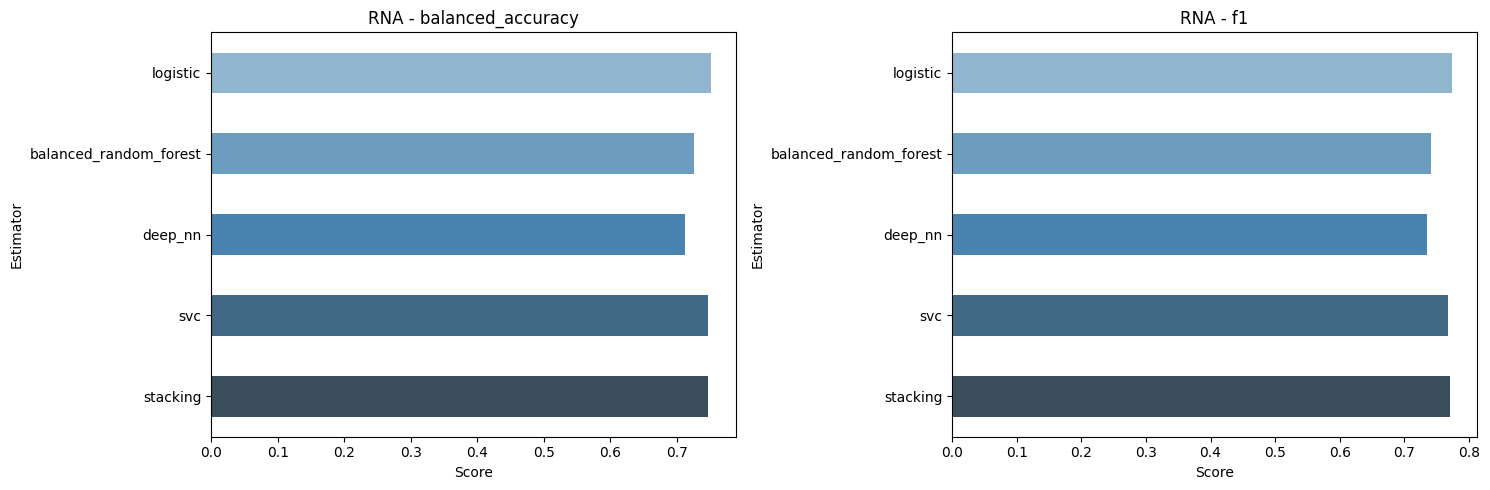

In [ ]:
plot_bar_scores(estimator_names, all_scores['rna'].values(), 'RNA', metrics=['balanced_accuracy', 'f1'])

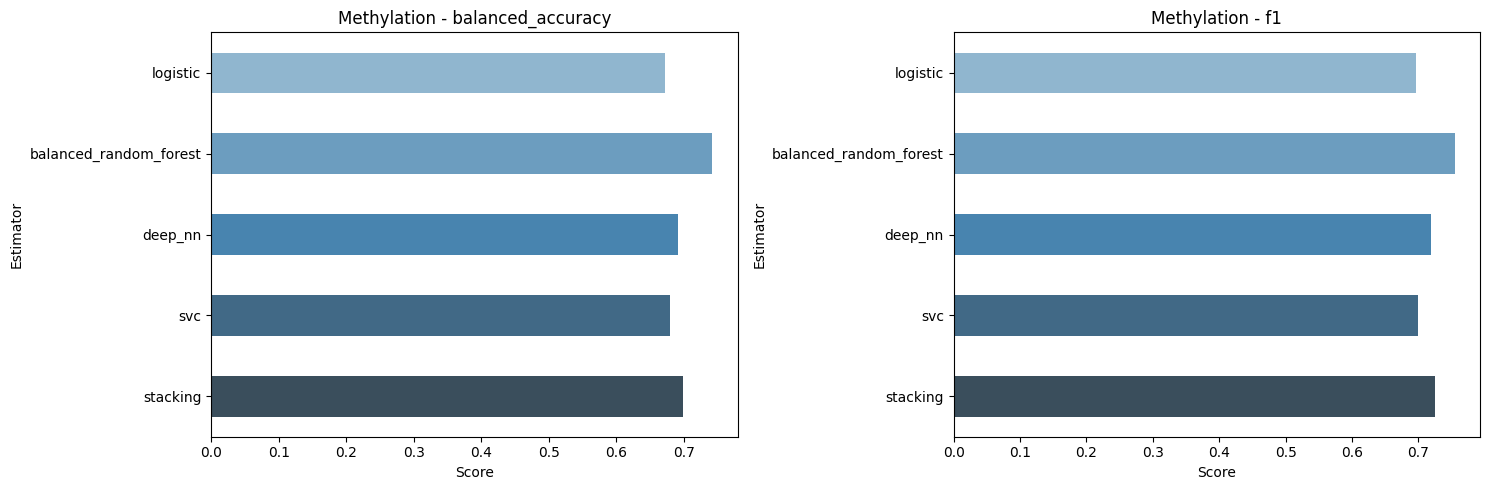

In [ ]:
plot_bar_scores(estimator_names, all_scores['meth'].values(), 'Methylation', metrics=['balanced_accuracy', 'f1'])

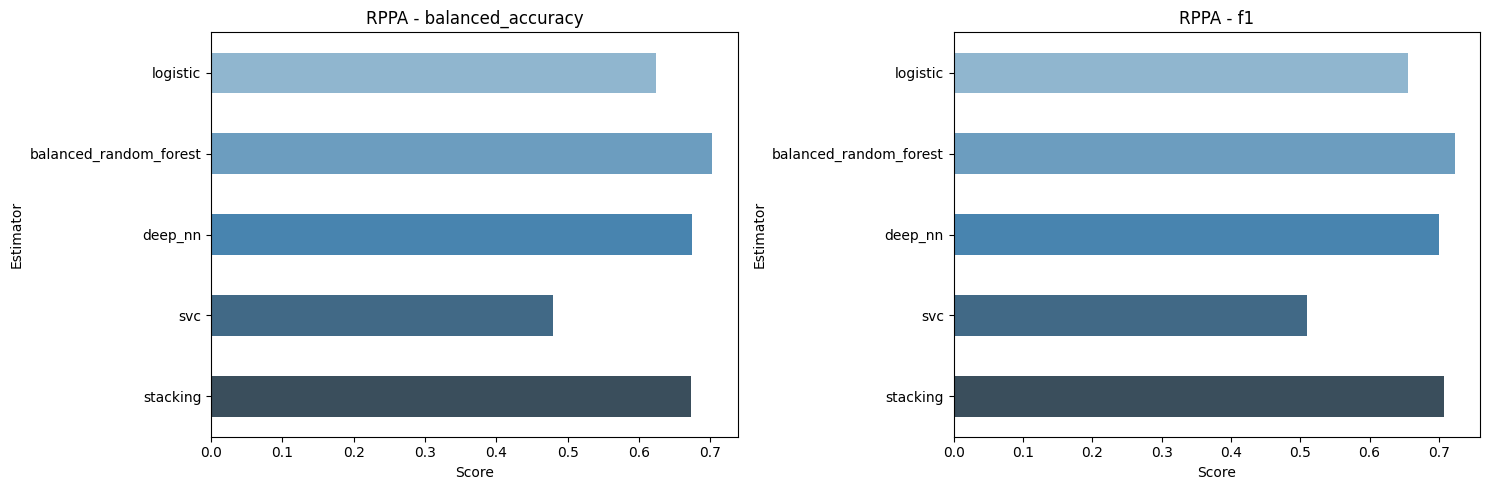

In [ ]:
plot_bar_scores(estimator_names, all_scores['rppa'].values(), 'RPPA', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:170: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:170: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


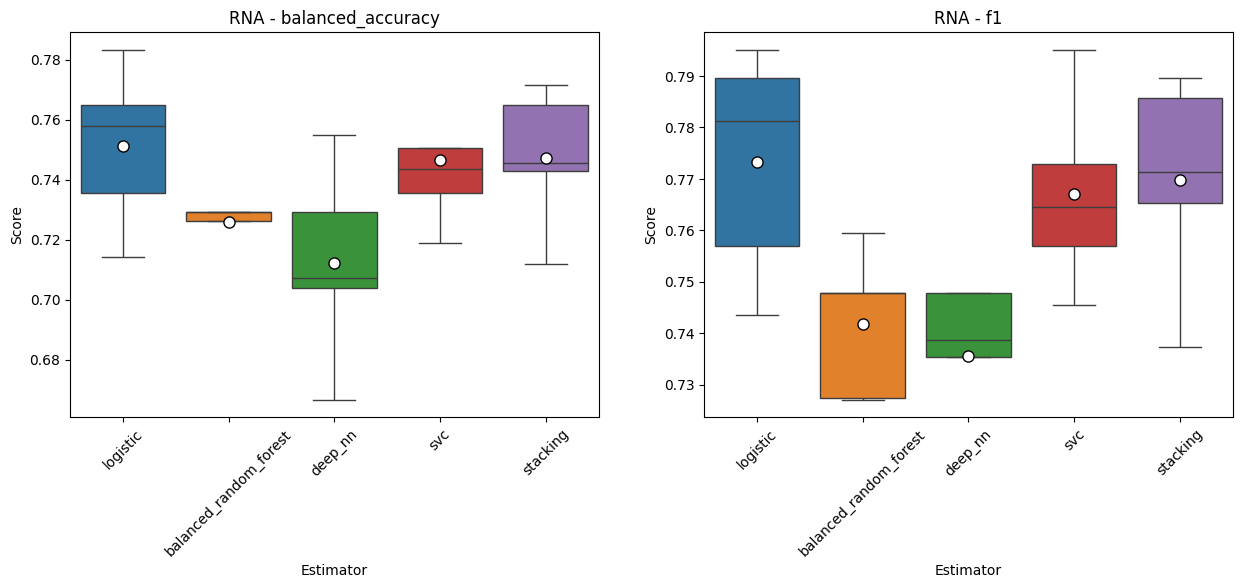

In [ ]:
plot_box_scores(estimator_names, all_scores['rna'].values(), 'RNA', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:170: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:170: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


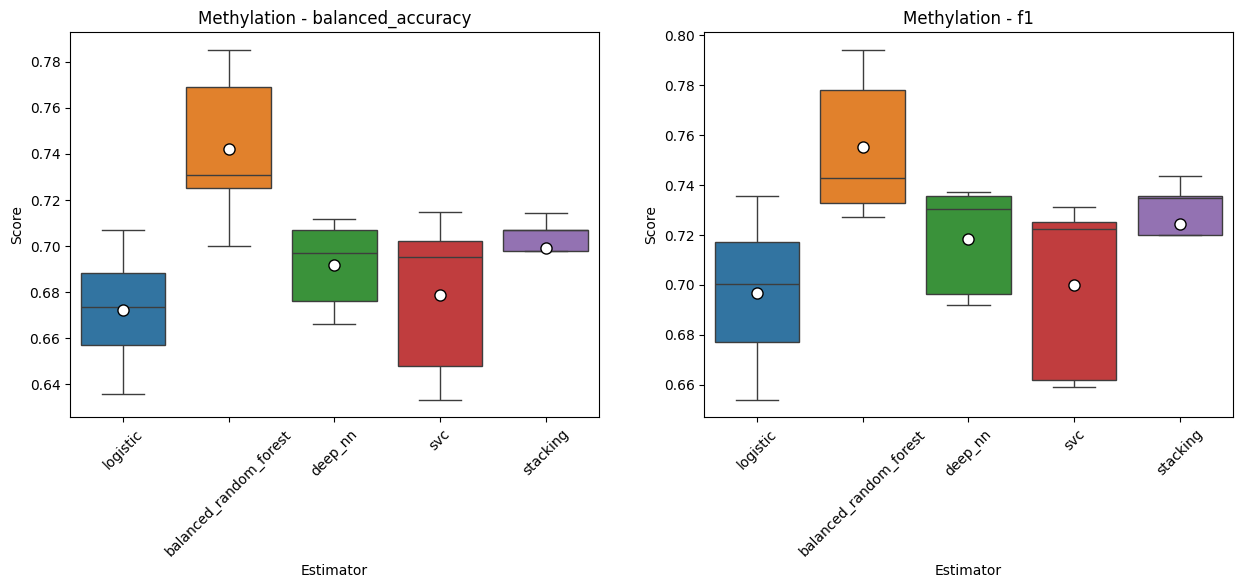

In [ ]:
plot_box_scores(estimator_names, all_scores['meth'].values(), 'Methylation', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:170: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:170: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


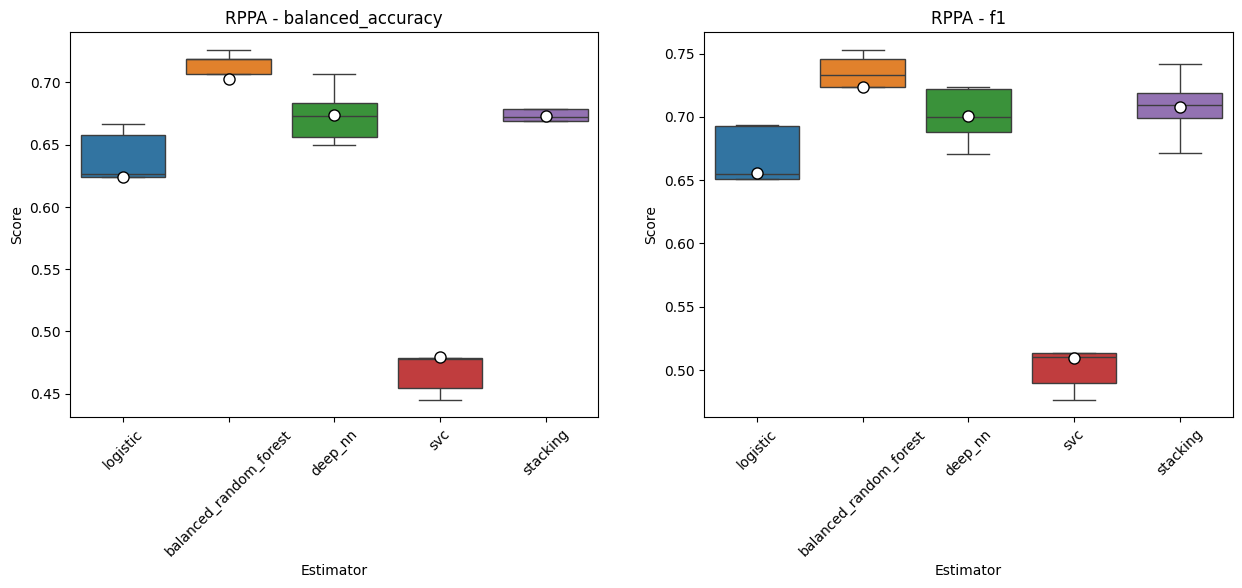

In [ ]:
plot_box_scores(estimator_names, all_scores['rppa'].values(), 'RPPA', metrics=['balanced_accuracy', 'f1'])

## Multi Omics Integration Ensemble

In [ ]:
column_names = {}

for key in X.keys():
    column_names[key] = X[key].columns

In [ ]:
meta_ensembles = {}
meta_ensembles['rna + meth + rppa'] = MultiOmicsIntegrationClassifier(classifiers, cv=3)
meta_ensembles['meth + rppa'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['meth', 'rppa']}, cv=3)
meta_ensembles['rna + meth'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['rna', 'meth']}, cv=3)
meta_ensembles['rna + rppa'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['rna', 'rppa']}, cv=3)

In [ ]:
X_merged = {}
X_merged['rna + meth + rppa'] = pd.concat([X['rna'], X['meth'], X['rppa']], axis=1, join='inner')
X_merged['meth + rppa'] = pd.concat([X['meth'], X['rppa']], axis=1, join='inner')
X_merged['rna + meth'] = pd.concat([X['rna'], X['meth']], axis=1, join='inner')
X_merged['rna + rppa'] = pd.concat([X['rna'], X['rppa']], axis=1, join='inner')


In [ ]:
integration_scores = {}
integration_metrics = {}

In [ ]:
# Run this if continuing an already saved run:
with open("results/kipan/staging/kipan_multi_omics_results_2.json",'r+') as file:
    integration_scores = json.load(file)
    integration_metrics = {}

    for model in integration_scores:
      metrics = {}

      for scorer in kipan_stage_scoring:
        metrics[scorer] = []

      for scorer in kipan_stage_scoring:
          metrics[scorer].append(
              "%0.3f +/- %0.3f"
              % (np.mean(integration_scores[model]["test_%s" % scorer]), np.std(integration_scores[model]["test_%s" % scorer]))
      )
      integration_metrics[model] = pd.DataFrame(metrics, index=[model])

In [ ]:
integration_scores['rna + meth + rppa'], integration_metrics['rna + meth + rppa'] = get_cross_metrics(meta_ensembles['rna + meth + rppa'], X_merged['rna + meth + rppa'], y, name='rna + meth + rppa', cv=5, verbose=2, scoring=kipan_stage_scoring, fit_params={'column_names': column_names})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 23.9min finished


In [ ]:
integration_scores['meth + rppa'], integration_metrics['meth + rppa'] = get_cross_metrics(meta_ensembles['meth + rppa'], X_merged['meth + rppa'], y, name='meth + rppa', cv=5, verbose=2, scoring=kipan_stage_scoring, fit_params={'column_names': {key: column_names[key] for key in ['meth', 'rppa']}})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.2min finished


In [ ]:
integration_scores['rna + rppa'], integration_metrics['rna + rppa'] = get_cross_metrics(meta_ensembles['rna + rppa'], X_merged['rna + rppa'], y, name='rna + rppa', cv=5, verbose=2, scoring=kipan_stage_scoring, fit_params={'column_names': {key: column_names[key] for key in ['rna', 'rppa']}})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 18.0min finished


In [ ]:
integration_scores['rna + meth'], integration_metrics['rna + meth'] = get_cross_metrics(meta_ensembles['rna + meth'], X_merged['rna + meth'], y, name='rna + meth', cv=5, verbose=2, scoring=kipan_stage_scoring, fit_params={'column_names': {key: column_names[key] for key in ['rna', 'meth']}})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 20.0min finished


In [ ]:
all_integration_metrics = pd.concat([modality_metrics, pd.concat([x for x in integration_metrics.values()])])
names = ['rna', 'meth', 'rppa', 'rna + meth + rppa', 'meth + rppa', 'rna + rppa', 'rna + meth']

all_integration_scores = modality_scores

# Adding multi-omic ensemble scores
for name, value in integration_scores.items():
    all_integration_scores[name] = value

In [ ]:
all_integration_metrics

accuracy balanced_accuracy               f1  \
rna                0.772 +/- 0.018   0.747 +/- 0.021  0.770 +/- 0.019   
meth               0.728 +/- 0.022   0.699 +/- 0.016  0.724 +/- 0.020   
rppa               0.720 +/- 0.024   0.673 +/- 0.024  0.708 +/- 0.023   
rna + meth + rppa  0.776 +/- 0.014   0.747 +/- 0.012  0.772 +/- 0.013   
meth + rppa        0.749 +/- 0.026   0.711 +/- 0.025  0.742 +/- 0.026   
rna + rppa         0.780 +/- 0.026   0.749 +/- 0.026  0.775 +/- 0.026   
rna + meth         0.776 +/- 0.009   0.747 +/- 0.011  0.772 +/- 0.009   

                    recall (early)    recall (late)  
rna                0.846 +/- 0.017  0.649 +/- 0.039  
meth               0.811 +/- 0.042  0.587 +/- 0.015  
rppa               0.860 +/- 0.040  0.485 +/- 0.046  
rna + meth + rppa  0.860 +/- 0.025  0.635 +/- 0.017  
meth + rppa        0.860 +/- 0.035  0.563 +/- 0.032  
rna + rppa         0.869 +/- 0.028  0.630 +/- 0.034  
rna + meth         0.860 +/- 0.023  0.635 +/- 0.035

In [ ]:
# Convert and write JSON object to file
with open("results/kipan/staging/kipan_multi_omics_results_2.json", "w") as outfile:
    json.dump(integration_scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)


In [ ]:
# Convert and write JSON object to file
with open("results/kipan/staging/kipan_modality_multi_omics_results_2.json", "w") as outfile:
    json.dump(all_integration_scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

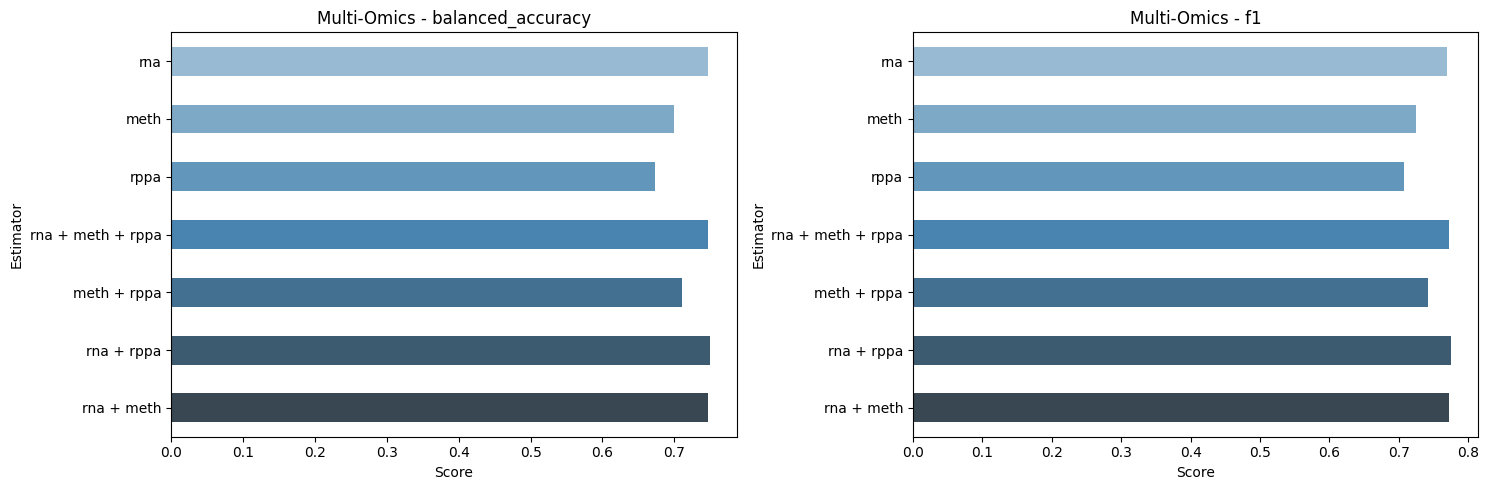

In [ ]:
plot_bar_scores(names, all_integration_scores.values(), 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:172: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:172: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


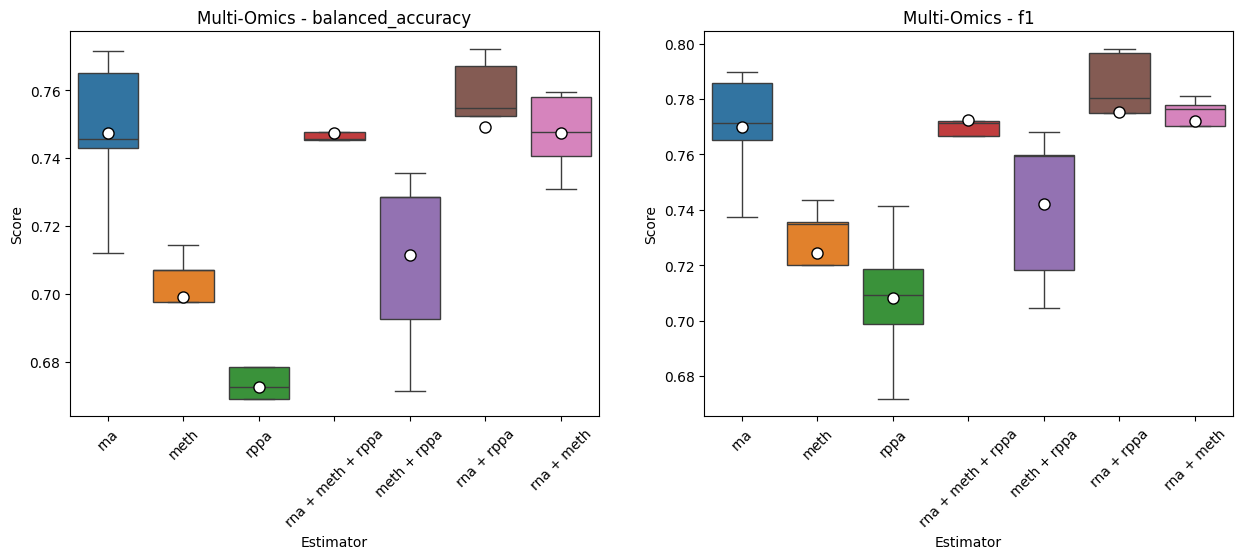

In [ ]:
plot_box_scores(names, all_integration_scores.values(), 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

## Statistical Significance

Now that we see the results, we want to check if the performance differences between our multi-omics ensemble models and the modality ensemble models are significant. We can employ the Wilcoxen test, using multiple replications of cross-validation to get scores.

### Wilcoxen

In [ ]:
ensemble_results = {}
ensemble_metrics = {}

In [ ]:
def wilcoxen_test(name_1, name_2, scores_1, scores_2):

    stat, p = wilcoxon(scores_1, scores_2, alternative='greater')

    df = pd.Series({'estimator_1': name_1, 'estimator_2': name_2, 'statistic': stat, 'p': p, 'significant': p <= 0.05})

    return pd.DataFrame(df).T

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
ensemble_results['meth + rppa'], ensemble_metrics['meth + rppa'] = get_cross_metrics(meta_ensembles['meth + rppa'], X_merged['meth + rppa'], y, name='meth + rppa', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_stage_scoring, fit_params={'column_names': {key: column_names[key] for key in ['meth', 'rppa']}})
ensemble_results['meth'], ensemble_metrics['meth'] = get_cross_metrics(classifiers['meth'], X['meth'], y, name='meth', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_stage_scoring)


In [ ]:
ensemble_results['rna + rppa'], ensemble_metrics['rna + rppa'] = get_cross_metrics(meta_ensembles['rna + rppa'], X_merged['rna + rppa'], y, name='rna + rppa', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_stage_scoring, fit_params={'column_names': {key: column_names[key] for key in ['rna', 'rppa']}})
ensemble_results['rna'], ensemble_metrics['rna'] = get_cross_metrics(classifiers['rna'], X['rna'], y, name='rna', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_stage_scoring)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
# Picking models we want to compare performances for
compare = [
    ('meth + rppa', 'meth'),
    ('rna + rppa', 'rna')
]

In [ ]:
from scipy.stats import wilcoxon

wilcoxen_results = {}
metrics = ['balanced_accuracy', 'f1']

for metric in metrics:
    wilcoxen_results[metric] = pd.DataFrame()
    for est1, est2 in compare:
        df = wilcoxen_test(est1, est2, ensemble_results[est1]['test_' + metric], ensemble_results[est2]['test_' + metric])
        wilcoxen_results[metric] = pd.concat([wilcoxen_results[metric], df])


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [ ]:
display(wilcoxen_results['balanced_accuracy'], wilcoxen_results['f1'])

estimator_1 estimator_2 statistic         p significant
0  meth + rppa        meth      53.0  0.660614       False
0   rna + rppa         rna      63.0  0.110383       False

estimator_1 estimator_2 statistic         p significant
0  meth + rppa        meth      68.0  0.339386       False
0   rna + rppa         rna      66.0  0.075978       False

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:172: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:172: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


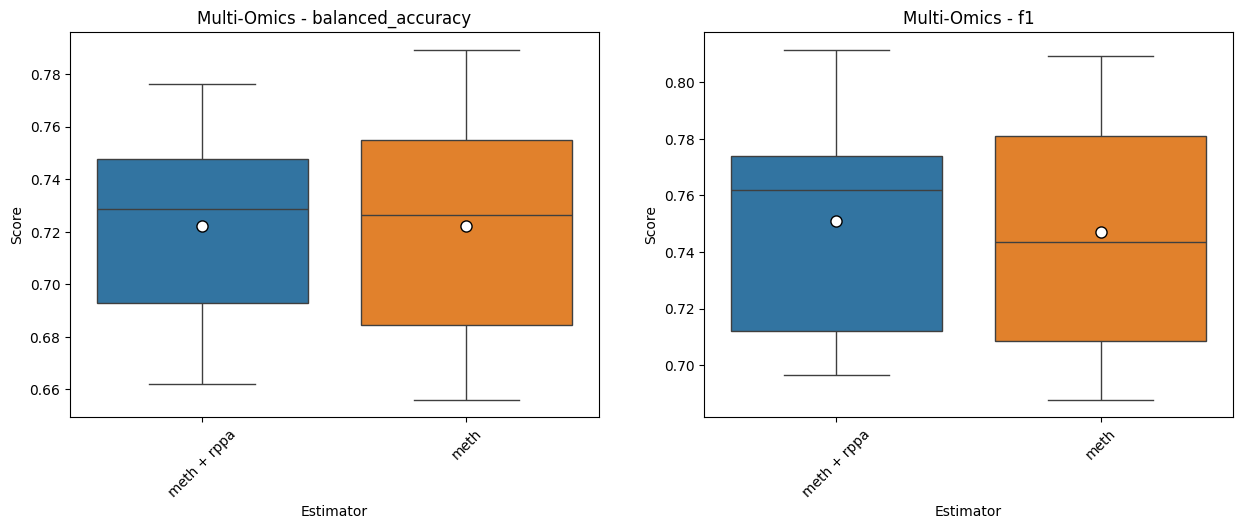

In [ ]:
plot_box_scores(['meth + rppa', 'meth'], [ensemble_results['meth + rppa'], ensemble_results['meth']], 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:172: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:172: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


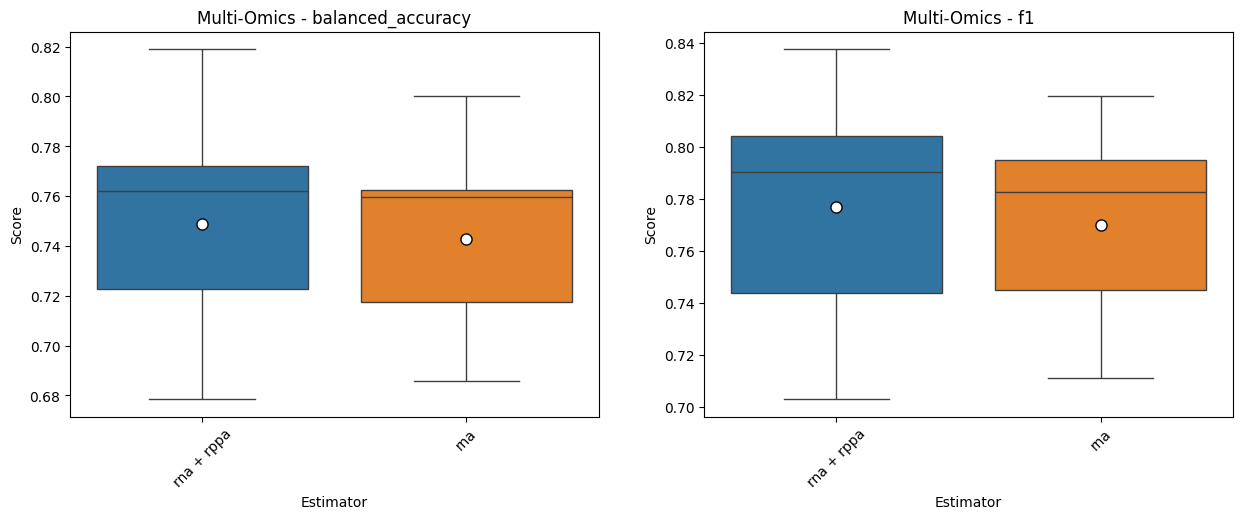

In [ ]:
plot_box_scores(['rna + rppa', 'rna'], [ensemble_results['rna + rppa'], ensemble_results['rna']], 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

In [ ]:
# Convert and write JSON object to file
with open("results/kipan/staging/kipan_5x3_results_2.json", "w") as outfile:
    json.dump(ensemble_results, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

## Feature Importance

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

In [ ]:
# Splitting into training, validation
X_train, X_test, y_train, y_test = train_test_split(X_merged['rna + rppa'], y, random_state=0, stratify=y)

In [ ]:
# Fitting on training data
meta_ensembles['rna + rppa'].fit(X_train, y_train, {key: column_names[key] for key in ['rna', 'rppa']})

MultiOmicsIntegrationClassifier(cv=3,
                                estimator_dict={'rna': ModalityPipeline(cv=3,
                                                                        estimator_list=[('logistic',
                                                                                         Pipeline(steps=[('standardscaler',
                                                                                                          StandardScaler()),
                                                                                                         ('logisticregression',
                                                                                                          LogisticRegression(max_iter=1000,
                                                                                                                             n_jobs=-1,
                                                                                                                             random_state=0))])),
                                                                                        ('balanced_random_forest',
                                                                                         BalancedRandomForestClassifier(n_jobs=-1,
                                                                                                                        random_state=0,
                                                                                                                        replacement=True,
                                                                                                                        sampl...
                                                                                         ('balanced_random_forest',
                                                                                          BalancedRandomForestClassifier(n_jobs=-1,
                                                                                                                         random_state=0,
                                                                                                                         replacement=True,
                                                                                                                         sampling_strategy='all')),
                                                                                         ('deep_nn',
                                                                                          Pipeline(steps=[('standardscaler',
                                                                                                           StandardScaler()),
                                                                                                          ('mlpclassifier',
                                                                                                           MLPClassifier(random_state=0))])),
                                                                                         ('svc',
                                                                                          Pipeline(steps=[('standardscaler',
                                                                                                           StandardScaler()),
                                                                                                          ('svc',
                                                                                                           SVC(kernel='linear',
                                                                                                               max_iter=1000,
                                                                                                               random_state=0))]))])})

In [ ]:
# Getting baseline scores
baseline_scores = {}
for name, scorer in kipan_stage_scoring.items():
  #y_preds = meta_ensembles['rna + rppa'].predict(X_test)
  baseline_scores[name] = get_scorer(scorer)(meta_ensembles['rna + rppa'], X_test, y_test)

In [ ]:
print(baseline_scores)

{'accuracy': 0.7642857142857142, 'balanced_accuracy': 0.7298951048951049, 'f1': 0.7588538914854704, 'recall (early)': 0.8636363636363636, 'recall (late)': 0.5961538461538461}


In [ ]:
r = permutation_importance(meta_ensembles['rna + rppa'], X_test, y_test, n_repeats=5, random_state=0, scoring=kipan_stage_scoring, n_jobs=-1)

KeyboardInterrupt: 

In [ ]:
for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{diabetes.feature_names[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

NameError: name 'r' is not defined

# RNA, Methylation, RPPA (feature selection)

In [4]:
datasets = {
            'rna': '../data/kipan/staging/RNASeq.csv',
            'meth': '../data/kipan/staging/Methylation.csv',
            'rppa': '../data/kipan/staging/RPPA.csv',
}

labels = '../data/kipan/staging/Clinical.csv'

In [5]:
subtypes = pd.read_csv(labels, index_col=0)
data = {}

for modality in datasets:
    data[modality] = pd.read_csv(datasets[modality], index_col=0)
    print(modality, data[modality].shape)

rna (558, 20190)
meth (558, 20116)
rppa (558, 202)


## Preprocessing

### Removing low-variance + null features

In [6]:
!pip3 install scanpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 7.9 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=306a1311f001910933259d40dbc567cbb4491a3ad1747b0ffc9be9b1d53d617d
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [7]:
import scanpy as sc
from scanpy.pp import highly_variable_genes
import anndata as an

In [8]:
adata = {}

for modality in datasets:
  data[modality] = data[modality].dropna(axis=1)
  adata[modality] = an.AnnData(data[modality])

In [9]:
sc.pp.highly_variable_genes(adata['rna'], n_top_genes=1000)

In [10]:
sc.pp.highly_variable_genes(adata['meth'], n_top_genes=1000)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:276: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


In [11]:
sc.pp.highly_variable_genes(adata['rppa'], n_top_genes=1000)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:276: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


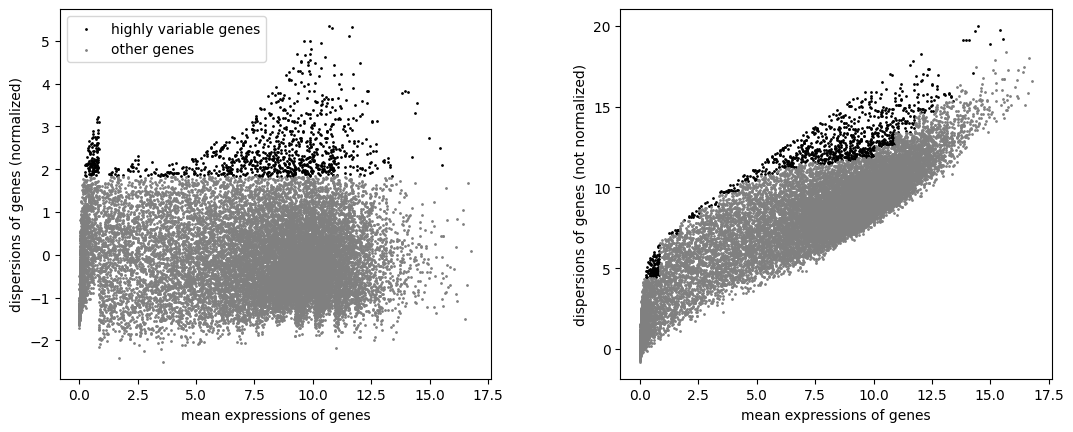

In [12]:
sc.pl.highly_variable_genes(adata['rna'])

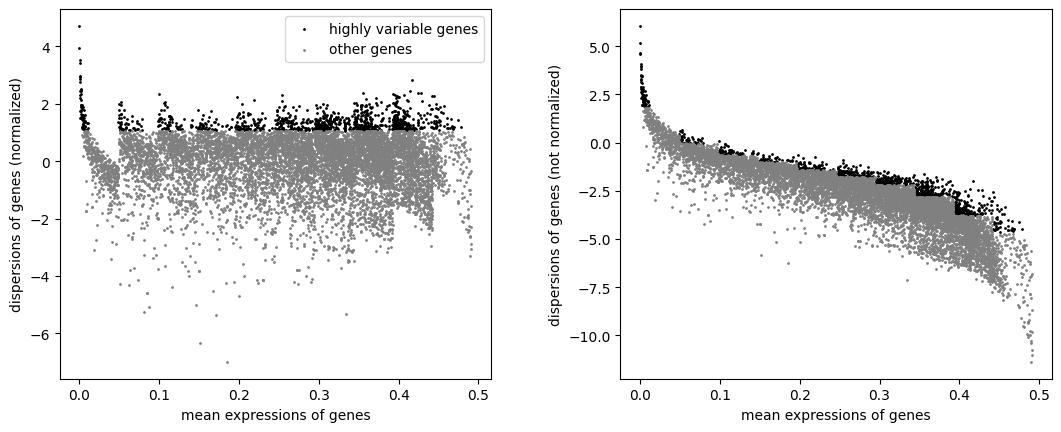

In [13]:
sc.pl.highly_variable_genes(adata['meth'])

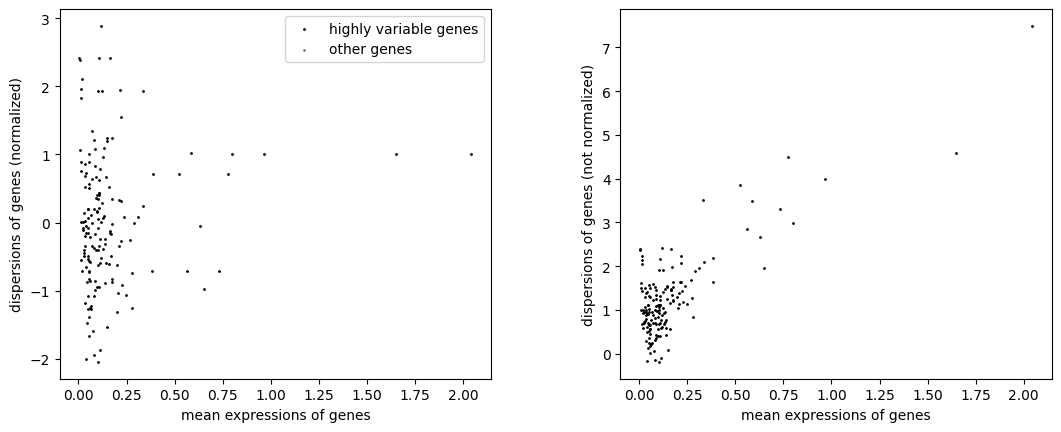

In [14]:
sc.pl.highly_variable_genes(adata['rppa'])

In [15]:
adata_new = {}

for modality in datasets:
  adata_new[modality] = adata[modality][:, adata[modality].var.highly_variable]
  sc.pp.scale(adata_new[modality], max_value=10)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [16]:
adata_new

{'rna': AnnData object with n_obs × n_vars = 558 × 1000
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'hvg',
 'meth': AnnData object with n_obs × n_vars = 558 × 1000
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'hvg',
 'rppa': AnnData object with n_obs × n_vars = 558 × 168
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'hvg'}

In [17]:
import pandas as pd

X = {}

# Convert numpy array to DataFrame
for modality in adata_new:
    X[modality] = adata_new[modality].to_df()
    print(modality, X[modality].shape)

rna (558, 1000)
meth (558, 1000)
rppa (558, 168)


In [18]:
stages = pd.read_csv(labels, index_col=0)['pathologic_stage']
stages.value_counts()

pathologic_stage
stagei      280
stageiii    129
stageiv      79
stageii      70
Name: count, dtype: int64

In [19]:
enc = LabelEncoder()
y = enc.fit_transform(stages)
enc.inverse_transform([0, 1, 2, 3])

array(['stagei', 'stageii', 'stageiii', 'stageiv'], dtype=object)

In [20]:
# Assuming your array is named 'arr'
y = np.where(np.logical_or(y == 0, y == 1), 0, 1)

In [21]:
unique, counts = np.unique(y, return_counts=True)
np.asarray((unique, counts)).T

array([[  0, 350],
       [  1, 208]])

## Base Learners

In [22]:
from imblearn.ensemble import BalancedRandomForestClassifier

estimators = [
    ("logistic", make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=1000, n_jobs=-1))),
    ("balanced_random_forest", BalancedRandomForestClassifier(random_state=0, n_jobs=-1, sampling_strategy='all', replacement=True)),
    ("deep_nn", make_pipeline(StandardScaler(), MLPClassifier(random_state=0))),
    ("svc", make_pipeline(StandardScaler(), SVC(random_state=0, kernel='linear', max_iter=1000)))
]

estimator_names = [estimator[0] for estimator in estimators]

In [23]:
kipan_stage_scoring = {"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (early)': make_scorer(recall_multiclass, label=0), 'recall (late)': make_scorer(recall_multiclass, label=1)}

In [ ]:
base_scores = {}
base_metrics_df = {}
base_metrics_df_train = {}

for modality in datasets:
    base_scores[modality], base_metrics_df[modality] = get_individual_scores(X[modality], y, estimators, scoring=kipan_stage_scoring)

In [ ]:
display(base_metrics_df['rna']), display(base_metrics_df['meth']), display(base_metrics_df['rppa'])

accuracy balanced_accuracy               f1  \
logistic                0.733 +/- 0.043   0.709 +/- 0.040  0.731 +/- 0.041   
balanced_random_forest  0.737 +/- 0.014   0.716 +/- 0.019  0.735 +/- 0.014   
deep_nn                 0.738 +/- 0.022   0.710 +/- 0.029  0.735 +/- 0.024   
svc                     0.728 +/- 0.046   0.705 +/- 0.044  0.726 +/- 0.045   

                         recall (early)    recall (late)  
logistic                0.803 +/- 0.053  0.616 +/- 0.041  
balanced_random_forest  0.797 +/- 0.050  0.635 +/- 0.077  
deep_nn                 0.820 +/- 0.017  0.601 +/- 0.061  
svc                     0.794 +/- 0.058  0.615 +/- 0.050

accuracy balanced_accuracy               f1  \
logistic                0.738 +/- 0.019   0.713 +/- 0.021  0.736 +/- 0.018   
balanced_random_forest  0.758 +/- 0.017   0.745 +/- 0.026  0.758 +/- 0.019   
deep_nn                 0.769 +/- 0.015   0.745 +/- 0.021  0.767 +/- 0.016   
svc                     0.728 +/- 0.023   0.708 +/- 0.031  0.726 +/- 0.025   

                         recall (early)    recall (late)  
logistic                0.811 +/- 0.038  0.615 +/- 0.055  
balanced_random_forest  0.797 +/- 0.025  0.692 +/- 0.066  
deep_nn                 0.837 +/- 0.019  0.653 +/- 0.047  
svc                     0.786 +/- 0.042  0.630 +/- 0.080

accuracy balanced_accuracy               f1  \
logistic                0.681 +/- 0.037   0.650 +/- 0.044  0.677 +/- 0.039   
balanced_random_forest  0.681 +/- 0.031   0.654 +/- 0.021  0.678 +/- 0.025   
deep_nn                 0.728 +/- 0.032   0.692 +/- 0.026  0.722 +/- 0.029   
svc                     0.640 +/- 0.027   0.625 +/- 0.033  0.642 +/- 0.027   

                         recall (early)    recall (late)  
logistic                0.771 +/- 0.033  0.529 +/- 0.083  
balanced_random_forest  0.760 +/- 0.076  0.548 +/- 0.065  
deep_nn                 0.831 +/- 0.051  0.553 +/- 0.020  
svc                     0.683 +/- 0.051  0.567 +/- 0.083

(None, None, None)

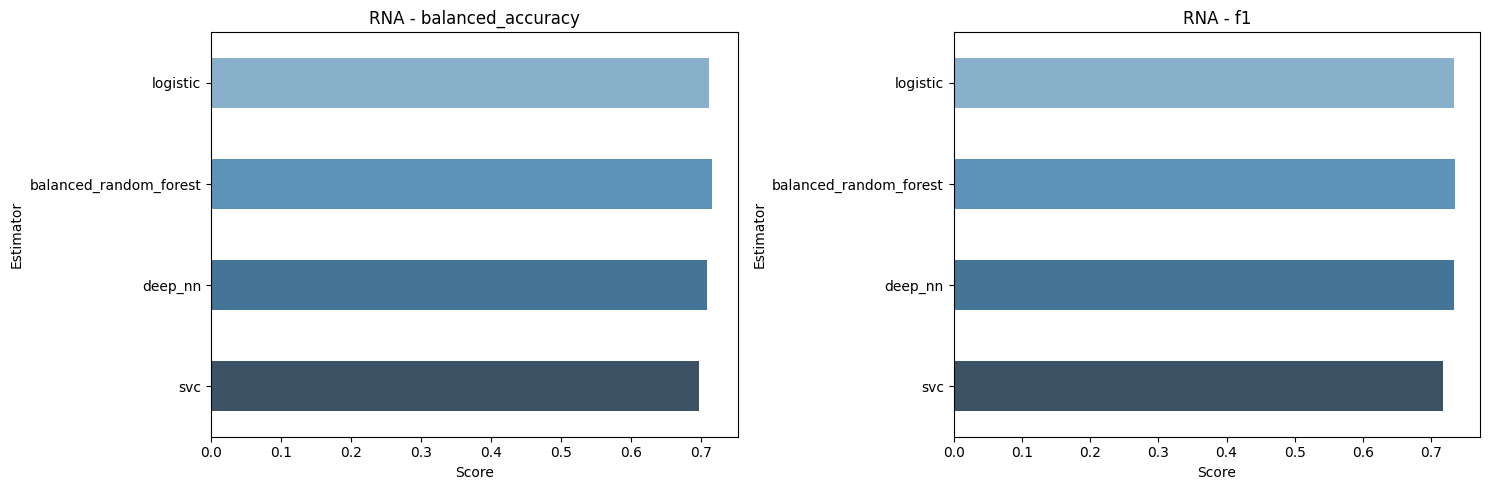

In [ ]:
plot_bar_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

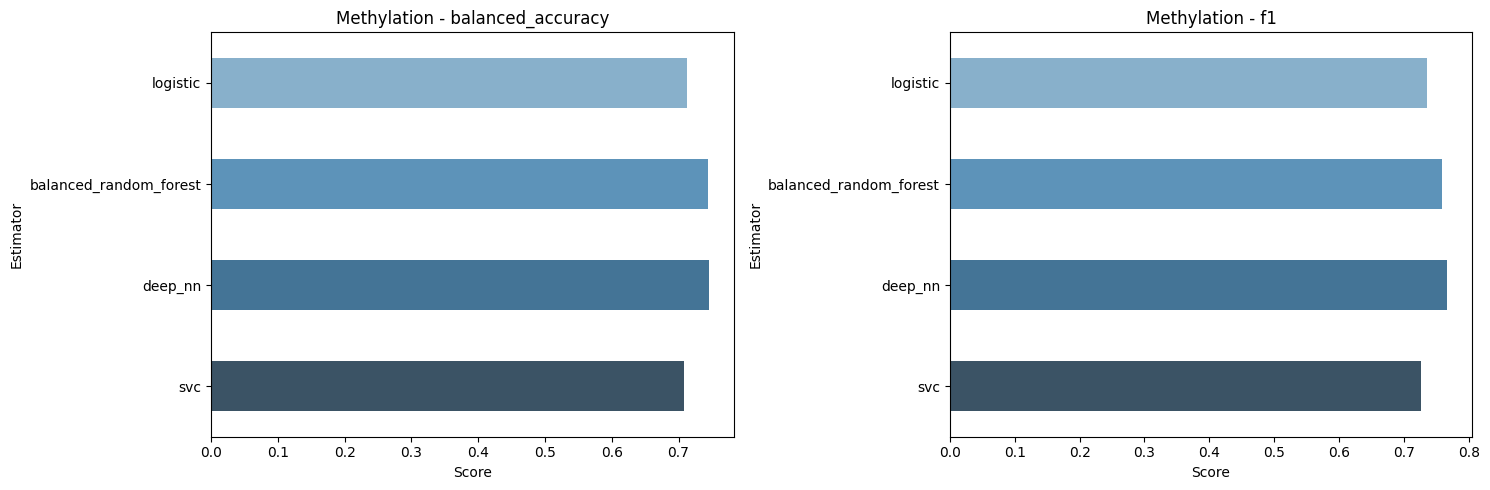

In [ ]:
plot_bar_scores(estimator_names, base_scores['meth'], 'Methylation', metrics=['balanced_accuracy', 'f1'])

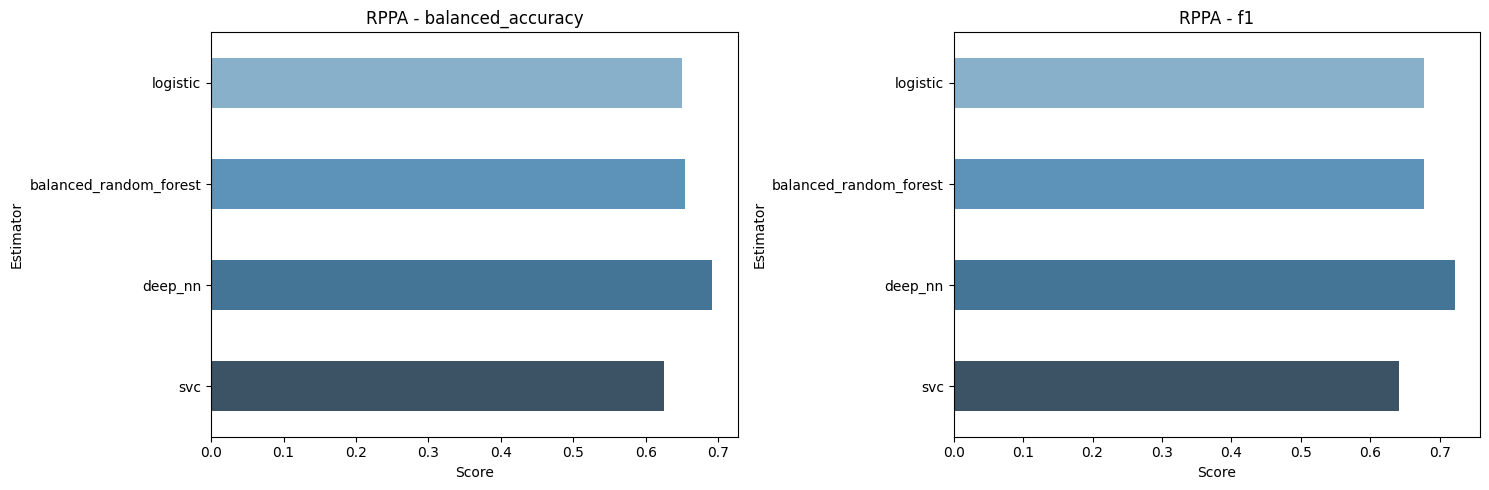

In [ ]:
plot_bar_scores(estimator_names, base_scores['rppa'], 'RPPA', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


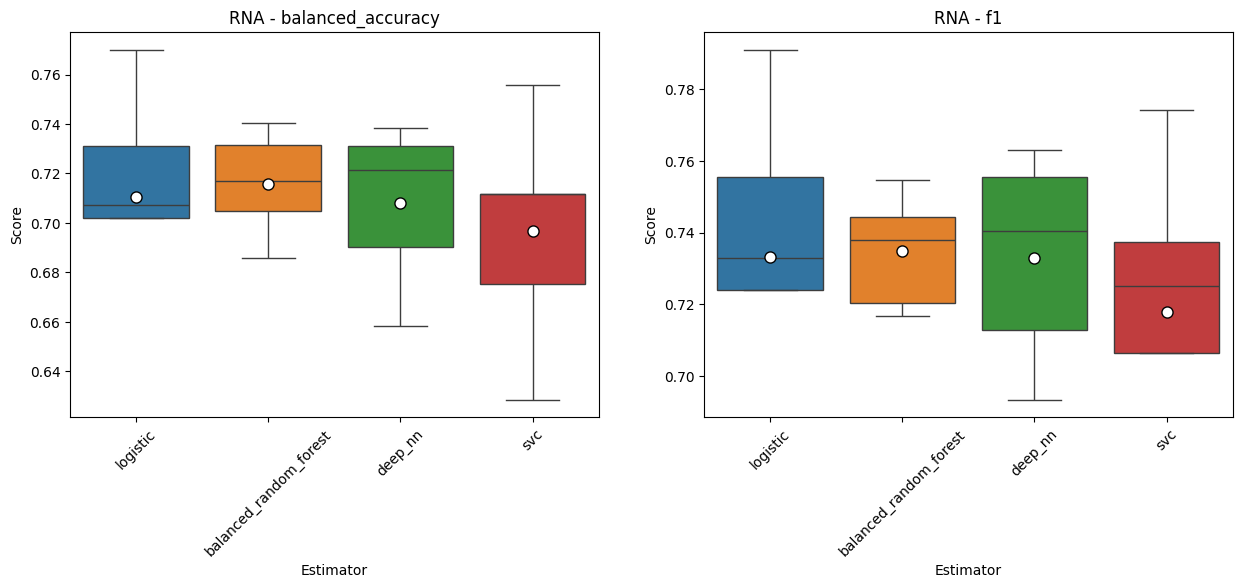

In [ ]:
plot_box_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


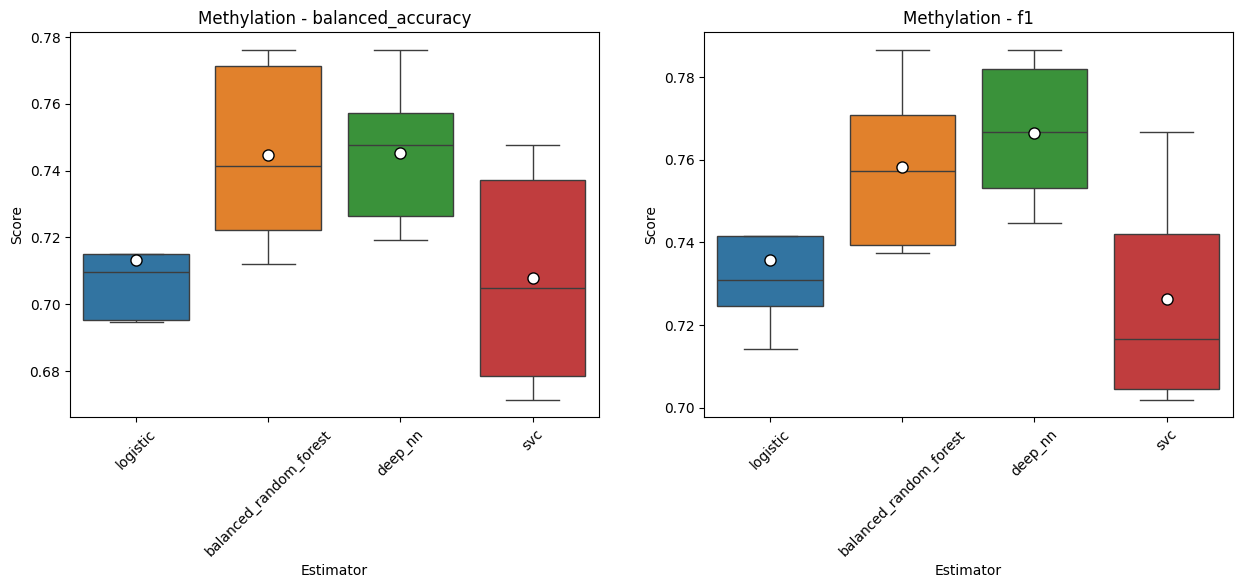

In [ ]:
plot_box_scores(estimator_names, base_scores['meth'], 'Methylation', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


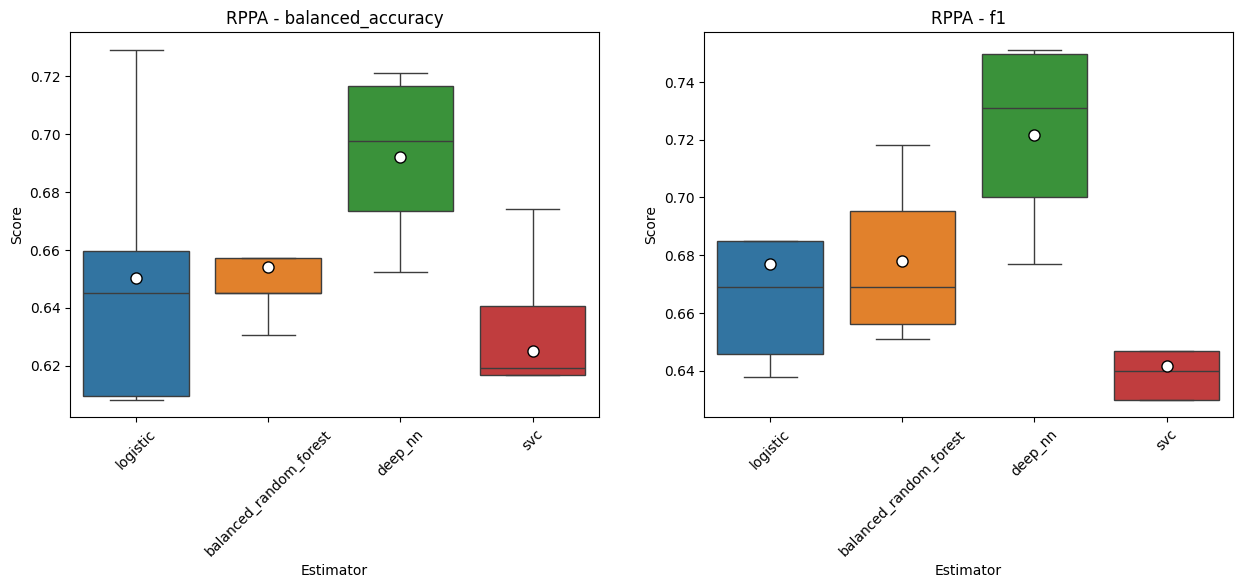

In [ ]:
plot_box_scores(estimator_names, base_scores['rppa'], 'RPPA', metrics=['balanced_accuracy', 'f1'])

In [24]:
base_scores = {}
base_metrics_df = {}
base_metrics_df_train = {}

for modality in datasets:
    base_scores[modality], base_metrics_df[modality] = get_individual_scores(X[modality], y, estimators, scoring=kipan_stage_scoring, cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1))

 25%|██▌       | 1/4 [00:15<00:47, 15.74s/it]

logistic                  accuracy balanced_accuracy               f1   recall (early)  \
logistic  0.747 +/- 0.028   0.721 +/- 0.031  0.744 +/- 0.029  0.821 +/- 0.041   

            recall (late)  
logistic  0.622 +/- 0.065  


 50%|█████     | 2/4 [00:37<00:39, 19.56s/it]

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.735 +/- 0.026   0.717 +/- 0.028  0.734 +/- 0.026   

                         recall (early)    recall (late)  
balanced_random_forest  0.786 +/- 0.049  0.649 +/- 0.069  


 75%|███████▌  | 3/4 [01:11<00:26, 26.07s/it]

deep_nn                 accuracy balanced_accuracy               f1   recall (early)  \
deep_nn  0.735 +/- 0.025   0.706 +/- 0.025  0.732 +/- 0.025  0.821 +/- 0.038   

           recall (late)  
deep_nn  0.591 +/- 0.044  


100%|██████████| 4/4 [01:13<00:00, 18.40s/it]


svc             accuracy balanced_accuracy               f1   recall (early)  \
svc  0.742 +/- 0.032   0.720 +/- 0.035  0.740 +/- 0.033  0.807 +/- 0.049   

       recall (late)  
svc  0.633 +/- 0.077  


 25%|██▌       | 1/4 [00:01<00:05,  1.76s/it]

logistic                  accuracy balanced_accuracy               f1   recall (early)  \
logistic  0.735 +/- 0.033   0.708 +/- 0.038  0.732 +/- 0.035  0.814 +/- 0.043   

            recall (late)  
logistic  0.603 +/- 0.078  


 50%|█████     | 2/4 [00:17<00:20, 10.23s/it]

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.738 +/- 0.040   0.721 +/- 0.039  0.738 +/- 0.039   

                         recall (early)    recall (late)  
balanced_random_forest  0.789 +/- 0.055  0.654 +/- 0.061  


 75%|███████▌  | 3/4 [00:44<00:17, 17.49s/it]

deep_nn                 accuracy balanced_accuracy               f1   recall (early)  \
deep_nn  0.768 +/- 0.034   0.742 +/- 0.037  0.765 +/- 0.034  0.844 +/- 0.041   

           recall (late)  
deep_nn  0.641 +/- 0.063  


100%|██████████| 4/4 [00:46<00:00, 11.72s/it]


svc             accuracy balanced_accuracy               f1   recall (early)  \
svc  0.714 +/- 0.033   0.690 +/- 0.038  0.712 +/- 0.034  0.784 +/- 0.043   

       recall (late)  
svc  0.596 +/- 0.076  


 25%|██▌       | 1/4 [00:01<00:04,  1.35s/it]

logistic                  accuracy balanced_accuracy               f1   recall (early)  \
logistic  0.688 +/- 0.045   0.667 +/- 0.048  0.687 +/- 0.044  0.751 +/- 0.056   

            recall (late)  
logistic  0.582 +/- 0.083  


 50%|█████     | 2/4 [00:10<00:12,  6.13s/it]

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.719 +/- 0.035   0.691 +/- 0.040  0.716 +/- 0.036   

                         recall (early)    recall (late)  
balanced_random_forest  0.801 +/- 0.043  0.582 +/- 0.076  


 75%|███████▌  | 3/4 [00:25<00:10, 10.19s/it]

deep_nn                 accuracy balanced_accuracy               f1   recall (early)  \
deep_nn  0.721 +/- 0.042   0.691 +/- 0.043  0.717 +/- 0.042  0.808 +/- 0.053   

           recall (late)  
deep_nn  0.574 +/- 0.066  


100%|██████████| 4/4 [00:26<00:00,  6.59s/it]

svc             accuracy balanced_accuracy               f1   recall (early)  \
svc  0.634 +/- 0.053   0.623 +/- 0.053  0.637 +/- 0.053  0.667 +/- 0.067   

       recall (late)  
svc  0.579 +/- 0.073  


In [25]:
display(base_metrics_df['rna']), display(base_metrics_df['meth']), display(base_metrics_df['rppa'])

accuracy balanced_accuracy               f1  \
logistic                0.747 +/- 0.028   0.721 +/- 0.031  0.744 +/- 0.029   
balanced_random_forest  0.735 +/- 0.026   0.717 +/- 0.028  0.734 +/- 0.026   
deep_nn                 0.735 +/- 0.025   0.706 +/- 0.025  0.732 +/- 0.025   
svc                     0.742 +/- 0.032   0.720 +/- 0.035  0.740 +/- 0.033   

                         recall (early)    recall (late)  
logistic                0.821 +/- 0.041  0.622 +/- 0.065  
balanced_random_forest  0.786 +/- 0.049  0.649 +/- 0.069  
deep_nn                 0.821 +/- 0.038  0.591 +/- 0.044  
svc                     0.807 +/- 0.049  0.633 +/- 0.077

accuracy balanced_accuracy               f1  \
logistic                0.735 +/- 0.033   0.708 +/- 0.038  0.732 +/- 0.035   
balanced_random_forest  0.738 +/- 0.040   0.721 +/- 0.039  0.738 +/- 0.039   
deep_nn                 0.768 +/- 0.034   0.742 +/- 0.037  0.765 +/- 0.034   
svc                     0.714 +/- 0.033   0.690 +/- 0.038  0.712 +/- 0.034   

                         recall (early)    recall (late)  
logistic                0.814 +/- 0.043  0.603 +/- 0.078  
balanced_random_forest  0.789 +/- 0.055  0.654 +/- 0.061  
deep_nn                 0.844 +/- 0.041  0.641 +/- 0.063  
svc                     0.784 +/- 0.043  0.596 +/- 0.076

accuracy balanced_accuracy               f1  \
logistic                0.688 +/- 0.045   0.667 +/- 0.048  0.687 +/- 0.044   
balanced_random_forest  0.719 +/- 0.035   0.691 +/- 0.040  0.716 +/- 0.036   
deep_nn                 0.721 +/- 0.042   0.691 +/- 0.043  0.717 +/- 0.042   
svc                     0.634 +/- 0.053   0.623 +/- 0.053  0.637 +/- 0.053   

                         recall (early)    recall (late)  
logistic                0.751 +/- 0.056  0.582 +/- 0.083  
balanced_random_forest  0.801 +/- 0.043  0.582 +/- 0.076  
deep_nn                 0.808 +/- 0.053  0.574 +/- 0.066  
svc                     0.667 +/- 0.067  0.579 +/- 0.073

(None, None, None)

## Modality Ensembles

In [26]:
classifiers = {}

for modality in datasets:
    classifiers[modality] = ModalityPipeline(estimators, cv=3)

In [ ]:
modality_metrics = pd.DataFrame()
modality_scores = {}

for modality in tqdm(datasets):
    modality_scores[modality], df = get_cross_metrics(classifiers[modality], X[modality], y, modality, scoring=kipan_stage_scoring)
    modality_metrics = pd.concat([modality_metrics, df])

100%|██████████| 3/3 [01:34<00:00, 31.53s/it]


In [ ]:
modality_metrics

accuracy balanced_accuracy               f1   recall (early)  \
rna   0.763 +/- 0.028   0.730 +/- 0.031  0.758 +/- 0.029  0.860 +/- 0.039   
meth  0.767 +/- 0.012   0.740 +/- 0.016  0.764 +/- 0.012  0.846 +/- 0.025   
rppa  0.737 +/- 0.021   0.688 +/- 0.020  0.724 +/- 0.021  0.880 +/- 0.037   

        recall (late)  
rna   0.601 +/- 0.060  
meth  0.634 +/- 0.044  
rppa  0.496 +/- 0.041

In [27]:
modality_metrics = pd.DataFrame()
modality_scores = {}

for modality in tqdm(datasets):
    modality_scores[modality], df = get_cross_metrics(classifiers[modality], X[modality], y, modality, scoring=kipan_stage_scoring, cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1))
    modality_metrics = pd.concat([modality_metrics, df])

100%|██████████| 3/3 [06:53<00:00, 137.71s/it]


In [28]:
# 5x3
modality_metrics

accuracy balanced_accuracy               f1   recall (early)  \
rna   0.755 +/- 0.024   0.722 +/- 0.026  0.750 +/- 0.025  0.851 +/- 0.038   
meth  0.761 +/- 0.027   0.732 +/- 0.029  0.757 +/- 0.027  0.847 +/- 0.038   
rppa  0.732 +/- 0.043   0.689 +/- 0.044  0.723 +/- 0.043  0.859 +/- 0.049   

        recall (late)  
rna   0.593 +/- 0.051  
meth  0.617 +/- 0.060  
rppa  0.519 +/- 0.062

In [ ]:
# Convert and write JSON object to file
with open("results/kipan/staging/kipan_modality_results_3.json", "w") as outfile:
    json.dump(modality_scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)


In [29]:
estimator_names = [
    "logistic",
    "balanced_random_forest",
    "deep_nn",
    "svc",
    "stacking"
]
all_scores = {}

for modality in base_scores:
    all_scores[modality] = {}
    for i in range(len(base_scores[modality])):
        all_scores[modality][estimator_names[i]] = base_scores[modality][i]

    all_scores[modality]['stacking'] = modality_scores[modality]


In [38]:
# Convert and write JSON object to file
with open("results/kipan_base_learner_modality_results_final.json", "w") as outfile:
    json.dump(all_scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

In [ ]:
# Run this if continuing an already saved run:
with open("results/kipan/staging/kipan_modality_results_3.json",'r+') as file:
    modality_scores = json.load(file)
    modality_metrics = pd.DataFrame()

    for model in modality_scores:
      metrics = {}

      for scorer in kipan_stage_scoring:
        metrics[scorer] = []

      for scorer in kipan_stage_scoring:
          metrics[scorer].append(
              "%0.3f +/- %0.3f"
              % (np.mean(modality_scores[model]["test_%s" % scorer]), np.std(modality_scores[model]["test_%s" % scorer]))
      )
      modality_metrics = pd.concat([modality_metrics, pd.DataFrame(metrics, index=[model])])

### Scoring

In [30]:
all_metrics = {}

for modality in datasets:
    all_metrics[modality] = pd.concat([base_metrics_df[modality], modality_metrics.loc[[modality]]])
    all_metrics[modality].rename_axis(index={modality: 'stacking'}, inplace=True)

In [ ]:
display(all_metrics['rna'], all_metrics['meth'], all_metrics['rppa'])

accuracy balanced_accuracy               f1  \
logistic                0.733 +/- 0.043   0.709 +/- 0.040  0.731 +/- 0.041   
balanced_random_forest  0.737 +/- 0.014   0.716 +/- 0.019  0.735 +/- 0.014   
deep_nn                 0.738 +/- 0.022   0.710 +/- 0.029  0.735 +/- 0.024   
svc                     0.728 +/- 0.046   0.705 +/- 0.044  0.726 +/- 0.045   
rna                     0.763 +/- 0.028   0.730 +/- 0.031  0.758 +/- 0.029   

                         recall (early)    recall (late)  
logistic                0.803 +/- 0.053  0.616 +/- 0.041  
balanced_random_forest  0.797 +/- 0.050  0.635 +/- 0.077  
deep_nn                 0.820 +/- 0.017  0.601 +/- 0.061  
svc                     0.794 +/- 0.058  0.615 +/- 0.050  
rna                     0.860 +/- 0.039  0.601 +/- 0.060

accuracy balanced_accuracy               f1  \
logistic                0.738 +/- 0.019   0.713 +/- 0.021  0.736 +/- 0.018   
balanced_random_forest  0.758 +/- 0.017   0.745 +/- 0.026  0.758 +/- 0.019   
deep_nn                 0.769 +/- 0.015   0.745 +/- 0.021  0.767 +/- 0.016   
svc                     0.728 +/- 0.023   0.708 +/- 0.031  0.726 +/- 0.025   
meth                    0.767 +/- 0.012   0.740 +/- 0.016  0.764 +/- 0.012   

                         recall (early)    recall (late)  
logistic                0.811 +/- 0.038  0.615 +/- 0.055  
balanced_random_forest  0.797 +/- 0.025  0.692 +/- 0.066  
deep_nn                 0.837 +/- 0.019  0.653 +/- 0.047  
svc                     0.786 +/- 0.042  0.630 +/- 0.080  
meth                    0.846 +/- 0.025  0.634 +/- 0.044

accuracy balanced_accuracy               f1  \
logistic                0.681 +/- 0.037   0.650 +/- 0.044  0.677 +/- 0.039   
balanced_random_forest  0.681 +/- 0.031   0.654 +/- 0.021  0.678 +/- 0.025   
deep_nn                 0.728 +/- 0.032   0.692 +/- 0.026  0.722 +/- 0.029   
svc                     0.640 +/- 0.027   0.625 +/- 0.033  0.642 +/- 0.027   
rppa                    0.737 +/- 0.021   0.688 +/- 0.020  0.724 +/- 0.021   

                         recall (early)    recall (late)  
logistic                0.771 +/- 0.033  0.529 +/- 0.083  
balanced_random_forest  0.760 +/- 0.076  0.548 +/- 0.065  
deep_nn                 0.831 +/- 0.051  0.553 +/- 0.020  
svc                     0.683 +/- 0.051  0.567 +/- 0.083  
rppa                    0.880 +/- 0.037  0.496 +/- 0.041

In [31]:
# 5x3
display(all_metrics['rna'], all_metrics['meth'], all_metrics['rppa'])

accuracy balanced_accuracy               f1  \
logistic                0.747 +/- 0.028   0.721 +/- 0.031  0.744 +/- 0.029   
balanced_random_forest  0.735 +/- 0.026   0.717 +/- 0.028  0.734 +/- 0.026   
deep_nn                 0.735 +/- 0.025   0.706 +/- 0.025  0.732 +/- 0.025   
svc                     0.742 +/- 0.032   0.720 +/- 0.035  0.740 +/- 0.033   
rna                     0.755 +/- 0.024   0.722 +/- 0.026  0.750 +/- 0.025   

                         recall (early)    recall (late)  
logistic                0.821 +/- 0.041  0.622 +/- 0.065  
balanced_random_forest  0.786 +/- 0.049  0.649 +/- 0.069  
deep_nn                 0.821 +/- 0.038  0.591 +/- 0.044  
svc                     0.807 +/- 0.049  0.633 +/- 0.077  
rna                     0.851 +/- 0.038  0.593 +/- 0.051

accuracy balanced_accuracy               f1  \
logistic                0.735 +/- 0.033   0.708 +/- 0.038  0.732 +/- 0.035   
balanced_random_forest  0.738 +/- 0.040   0.721 +/- 0.039  0.738 +/- 0.039   
deep_nn                 0.768 +/- 0.034   0.742 +/- 0.037  0.765 +/- 0.034   
svc                     0.714 +/- 0.033   0.690 +/- 0.038  0.712 +/- 0.034   
meth                    0.761 +/- 0.027   0.732 +/- 0.029  0.757 +/- 0.027   

                         recall (early)    recall (late)  
logistic                0.814 +/- 0.043  0.603 +/- 0.078  
balanced_random_forest  0.789 +/- 0.055  0.654 +/- 0.061  
deep_nn                 0.844 +/- 0.041  0.641 +/- 0.063  
svc                     0.784 +/- 0.043  0.596 +/- 0.076  
meth                    0.847 +/- 0.038  0.617 +/- 0.060

accuracy balanced_accuracy               f1  \
logistic                0.688 +/- 0.045   0.667 +/- 0.048  0.687 +/- 0.044   
balanced_random_forest  0.719 +/- 0.035   0.691 +/- 0.040  0.716 +/- 0.036   
deep_nn                 0.721 +/- 0.042   0.691 +/- 0.043  0.717 +/- 0.042   
svc                     0.634 +/- 0.053   0.623 +/- 0.053  0.637 +/- 0.053   
rppa                    0.732 +/- 0.043   0.689 +/- 0.044  0.723 +/- 0.043   

                         recall (early)    recall (late)  
logistic                0.751 +/- 0.056  0.582 +/- 0.083  
balanced_random_forest  0.801 +/- 0.043  0.582 +/- 0.076  
deep_nn                 0.808 +/- 0.053  0.574 +/- 0.066  
svc                     0.667 +/- 0.067  0.579 +/- 0.073  
rppa                    0.859 +/- 0.049  0.519 +/- 0.062

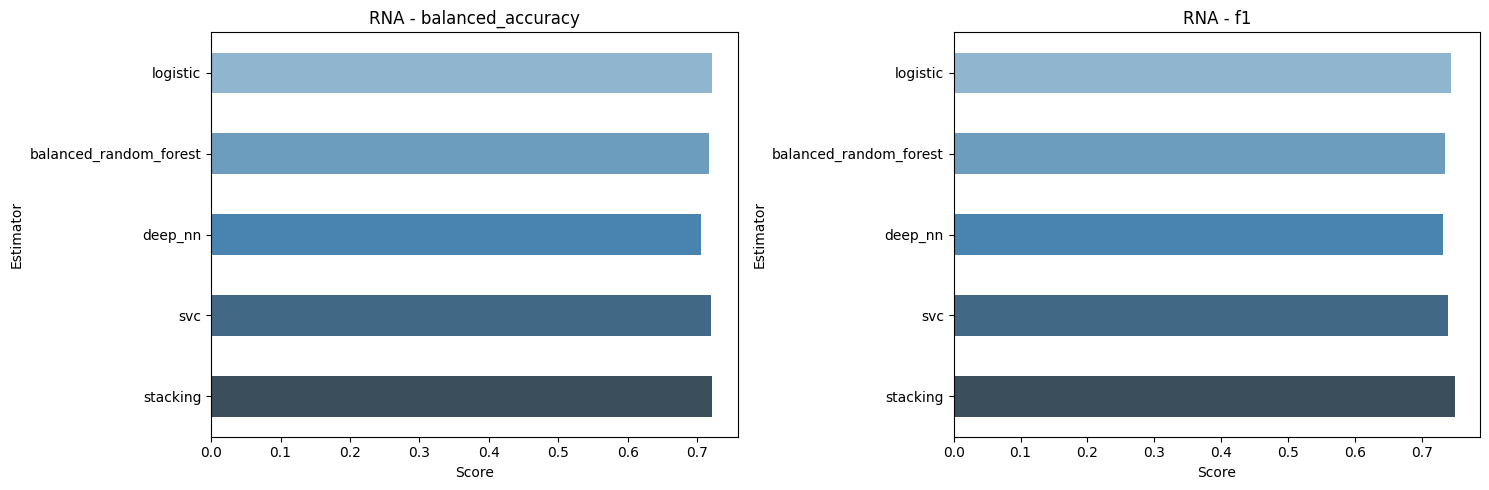

In [32]:
plot_bar_scores(estimator_names, all_scores['rna'].values(), 'RNA', metrics=['balanced_accuracy', 'f1'])

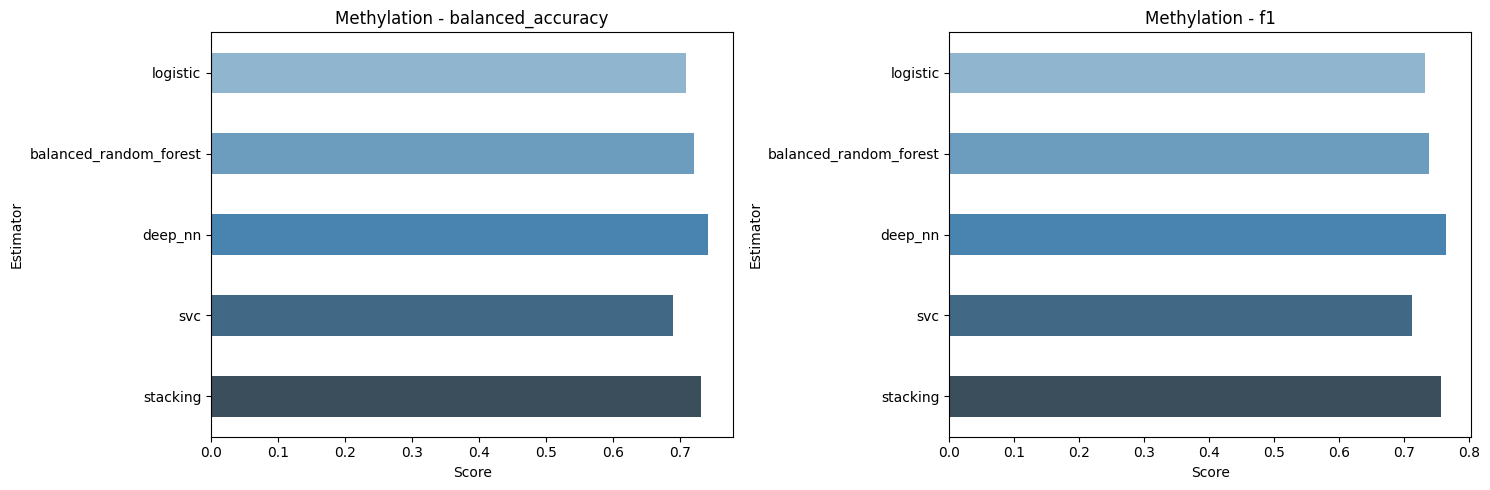

In [33]:
plot_bar_scores(estimator_names, all_scores['meth'].values(), 'Methylation', metrics=['balanced_accuracy', 'f1'])

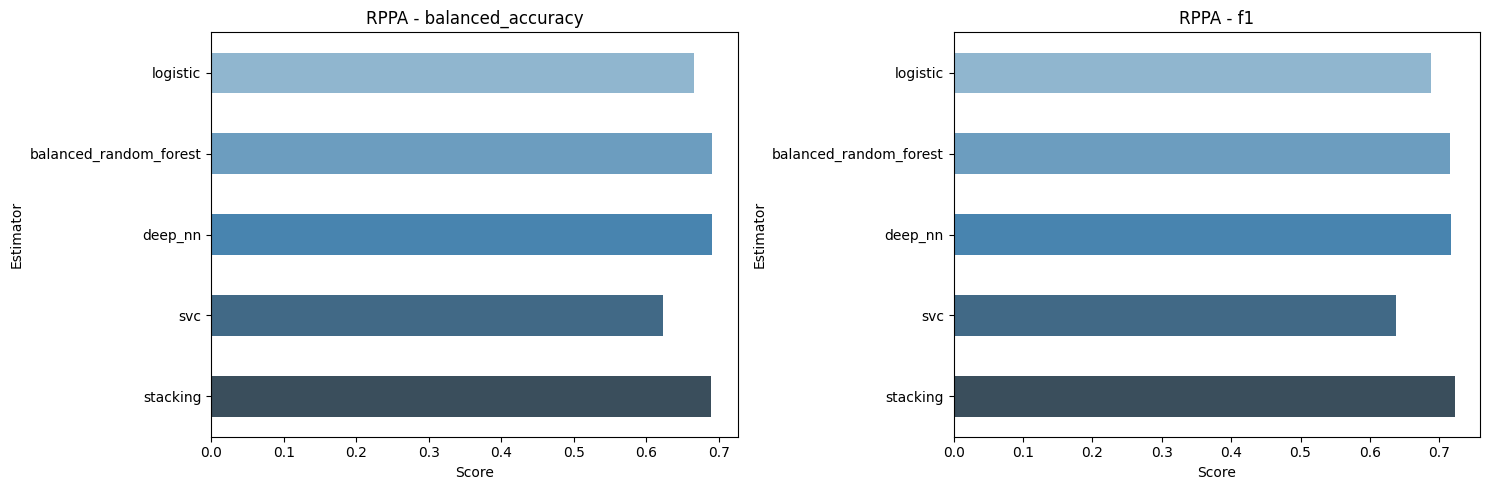

In [34]:
plot_bar_scores(estimator_names, all_scores['rppa'].values(), 'RPPA', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:178: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:178: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


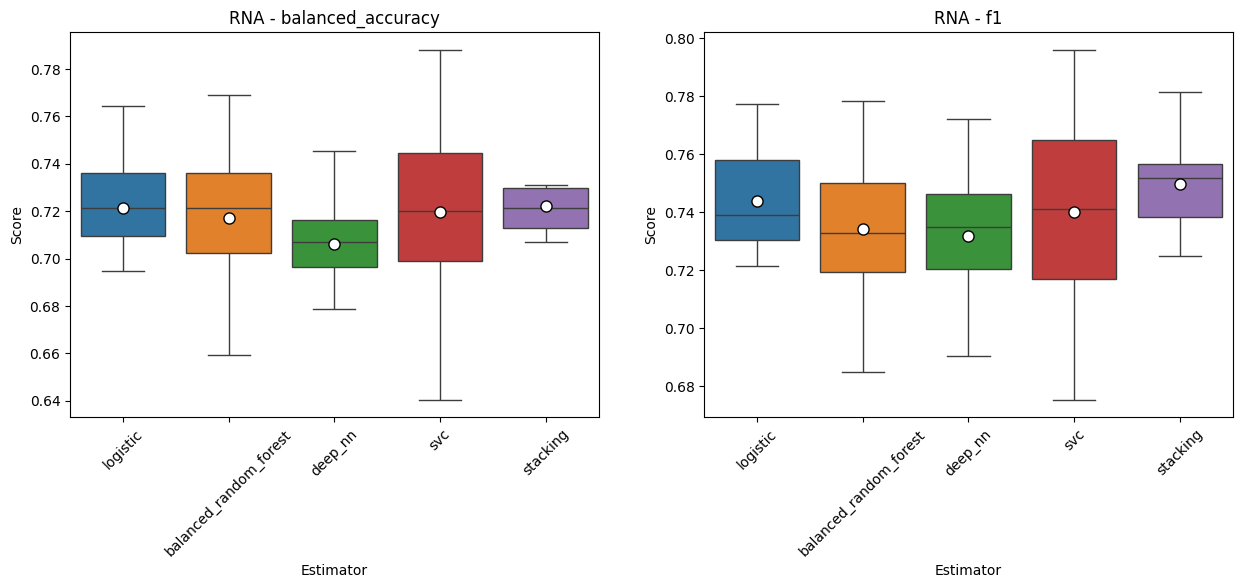

In [35]:
plot_box_scores(estimator_names, all_scores['rna'].values(), 'RNA', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:178: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:178: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


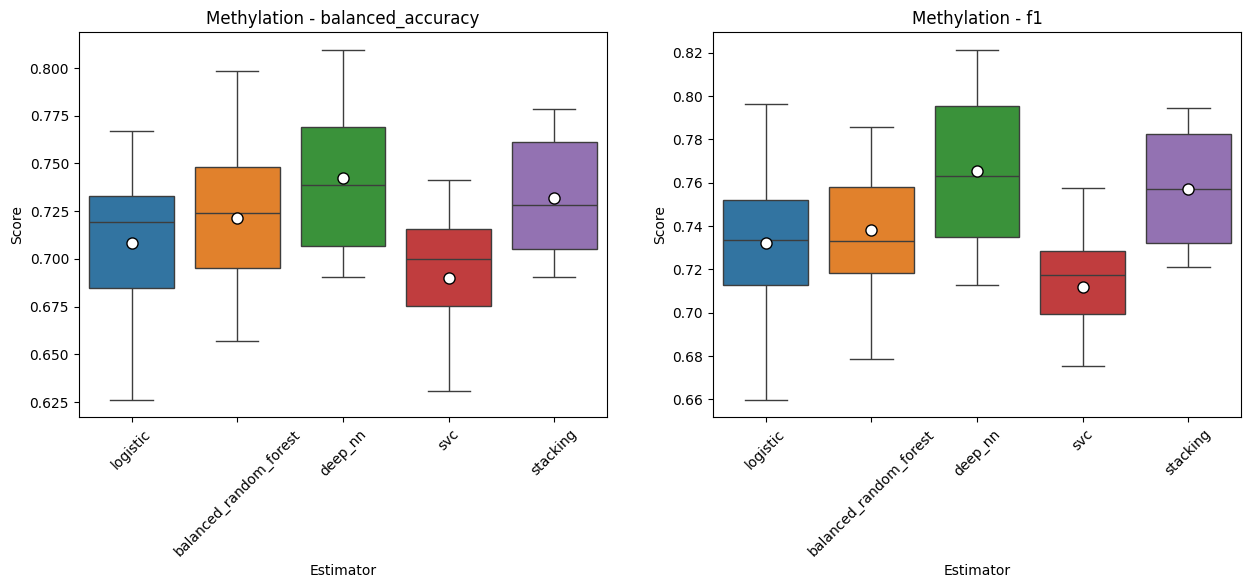

In [36]:
plot_box_scores(estimator_names, all_scores['meth'].values(), 'Methylation', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:178: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:178: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


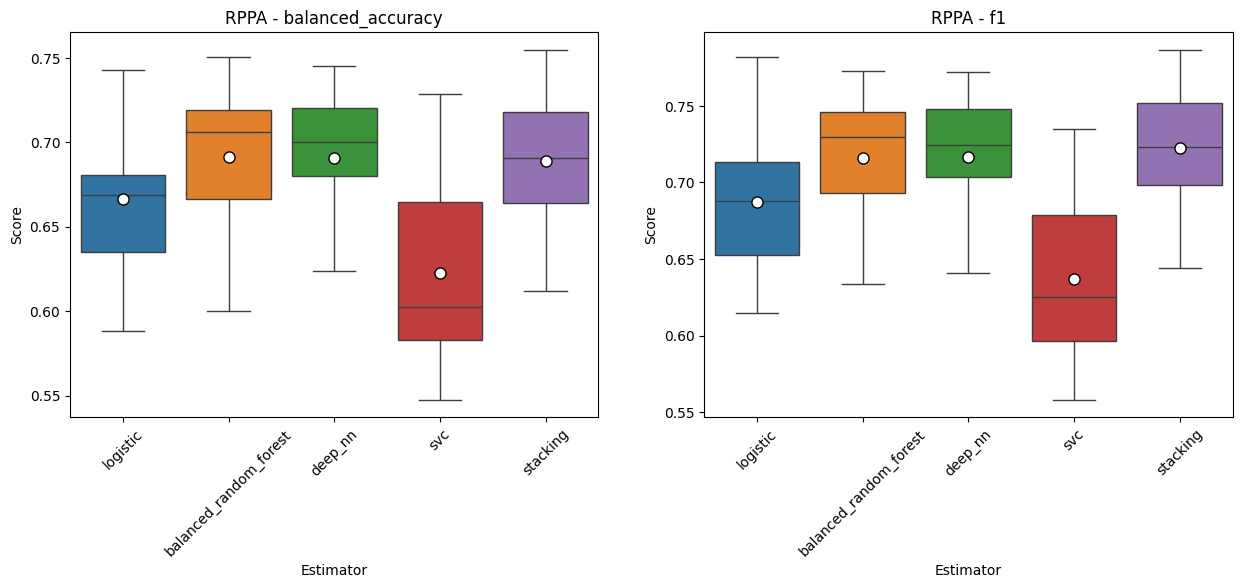

In [37]:
plot_box_scores(estimator_names, all_scores['rppa'].values(), 'RPPA', metrics=['balanced_accuracy', 'f1'])

In [41]:
# Picking models we want to compare performances for
compare = [
    ('rna', 'stacking', 'logistic'),
    ('meth', 'deep_nn', 'stacking'),
    ('rppa', 'stacking', 'deep_nn')
]

In [42]:
from scipy.stats import wilcoxon

wilcoxen_results = {}
metrics = ['balanced_accuracy', 'f1']

for metric in metrics:
    wilcoxen_results[metric] = pd.DataFrame()
    for modality, est1, est2 in compare:
        df = wilcoxen_test(est1, est2, all_scores[modality][est1]['test_' + metric], all_scores[modality][est2]['test_' + metric])
        wilcoxen_results[metric] = pd.concat([wilcoxen_results[metric], df])


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if ther

In [43]:
display(wilcoxen_results['balanced_accuracy'], wilcoxen_results['f1'])

estimator_1 estimator_2 statistic         p significant
0    stacking    logistic      54.0  0.462489       False
0     deep_nn    stacking      79.0  0.009557        True
0    stacking     deep_nn      54.0  0.640137       False

estimator_1 estimator_2 statistic         p significant
0    stacking    logistic      71.0  0.122747       False
0     deep_nn    stacking      76.0  0.016523        True
0    stacking     deep_nn      84.0  0.093811       False

## Multi Omics Integration Ensemble

In [ ]:
column_names = {}

for key in X.keys():
    column_names[key] = X[key].columns

In [ ]:
meta_ensembles = {}
meta_ensembles['rna + meth + rppa'] = MultiOmicsIntegrationClassifier(classifiers, cv=3)
meta_ensembles['meth + rppa'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['meth', 'rppa']}, cv=3)
meta_ensembles['rna + meth'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['rna', 'meth']}, cv=3)
meta_ensembles['rna + rppa'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['rna', 'rppa']}, cv=3)

In [ ]:
X_merged = {}
X_merged['rna + meth + rppa'] = pd.concat([X['rna'], X['meth'], X['rppa']], axis=1, join='inner')
X_merged['meth + rppa'] = pd.concat([X['meth'], X['rppa']], axis=1, join='inner')
X_merged['rna + meth'] = pd.concat([X['rna'], X['meth']], axis=1, join='inner')
X_merged['rna + rppa'] = pd.concat([X['rna'], X['rppa']], axis=1, join='inner')


In [ ]:
integration_scores = {}
integration_metrics = {}

In [ ]:
# Run this if continuing an already saved run:
with open("results/kipan/staging/kipan_multi_omics_results_3.json",'r+') as file:
    integration_scores = json.load(file)
    integration_metrics = {}

    for model in integration_scores:
      metrics = {}

      for scorer in kipan_stage_scoring:
        metrics[scorer] = []

      for scorer in kipan_stage_scoring:
          metrics[scorer].append(
              "%0.3f +/- %0.3f"
              % (np.mean(integration_scores[model]["test_%s" % scorer]), np.std(integration_scores[model]["test_%s" % scorer]))
      )
      integration_metrics[model] = pd.DataFrame(metrics, index=[model])

In [ ]:
integration_scores['rna + meth + rppa'], integration_metrics['rna + meth + rppa'] = get_cross_metrics(meta_ensembles['rna + meth + rppa'], X_merged['rna + meth + rppa'], y, name='rna + meth + rppa', cv=5, verbose=2, scoring=kipan_stage_scoring, fit_params={'column_names': column_names})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.7min finished


In [ ]:
integration_scores['meth + rppa'], integration_metrics['meth + rppa'] = get_cross_metrics(meta_ensembles['meth + rppa'], X_merged['meth + rppa'], y, name='meth + rppa', cv=5, verbose=2, scoring=kipan_stage_scoring, fit_params={'column_names': {key: column_names[key] for key in ['meth', 'rppa']}})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.9min finished


In [ ]:
integration_scores['rna + rppa'], integration_metrics['rna + rppa'] = get_cross_metrics(meta_ensembles['rna + rppa'], X_merged['rna + rppa'], y, name='rna + rppa', cv=5, verbose=2, scoring=kipan_stage_scoring, fit_params={'column_names': {key: column_names[key] for key in ['rna', 'rppa']}})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished


In [ ]:
integration_scores['rna + meth'], integration_metrics['rna + meth'] = get_cross_metrics(meta_ensembles['rna + meth'], X_merged['rna + meth'], y, name='rna + meth', cv=5, verbose=2, scoring=kipan_stage_scoring, fit_params={'column_names': {key: column_names[key] for key in ['rna', 'meth']}})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished


In [ ]:
all_integration_metrics = pd.concat([modality_metrics, pd.concat([x for x in integration_metrics.values()])])
names = ['rna', 'meth', 'rppa', 'rna + meth + rppa', 'meth + rppa', 'rna + rppa', 'rna + meth']

all_integration_scores = modality_scores

# Adding multi-omic ensemble scores
for name, value in integration_scores.items():
    all_integration_scores[name] = value

In [ ]:
all_integration_metrics

accuracy balanced_accuracy               f1  \
rna                0.763 +/- 0.028   0.730 +/- 0.031  0.758 +/- 0.029   
meth               0.767 +/- 0.012   0.740 +/- 0.016  0.764 +/- 0.012   
rppa               0.737 +/- 0.021   0.688 +/- 0.020  0.724 +/- 0.021   
rna + meth + rppa  0.783 +/- 0.015   0.753 +/- 0.013  0.779 +/- 0.014   
meth + rppa        0.778 +/- 0.015   0.749 +/- 0.021  0.774 +/- 0.017   
rna + rppa         0.769 +/- 0.020   0.730 +/- 0.025  0.761 +/- 0.022   
rna + meth         0.783 +/- 0.011   0.755 +/- 0.016  0.779 +/- 0.011   

                    recall (early)    recall (late)  
rna                0.860 +/- 0.039  0.601 +/- 0.060  
meth               0.846 +/- 0.025  0.634 +/- 0.044  
rppa               0.880 +/- 0.037  0.496 +/- 0.041  
rna + meth + rppa  0.871 +/- 0.031  0.635 +/- 0.031  
meth + rppa        0.863 +/- 0.015  0.635 +/- 0.046  
rna + rppa         0.883 +/- 0.017  0.577 +/- 0.049  
rna + meth         0.866 +/- 0.026  0.644 +/- 0.048

In [ ]:
# Convert and write JSON object to file
with open("results/kipan/staging/kipan_multi_omics_results_3.json", "w") as outfile:
    json.dump(integration_scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)


In [ ]:
# Convert and write JSON object to file
with open("results/kipan/staging/kipan_modality_multi_omics_results_3.json", "w") as outfile:
    json.dump(all_integration_scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

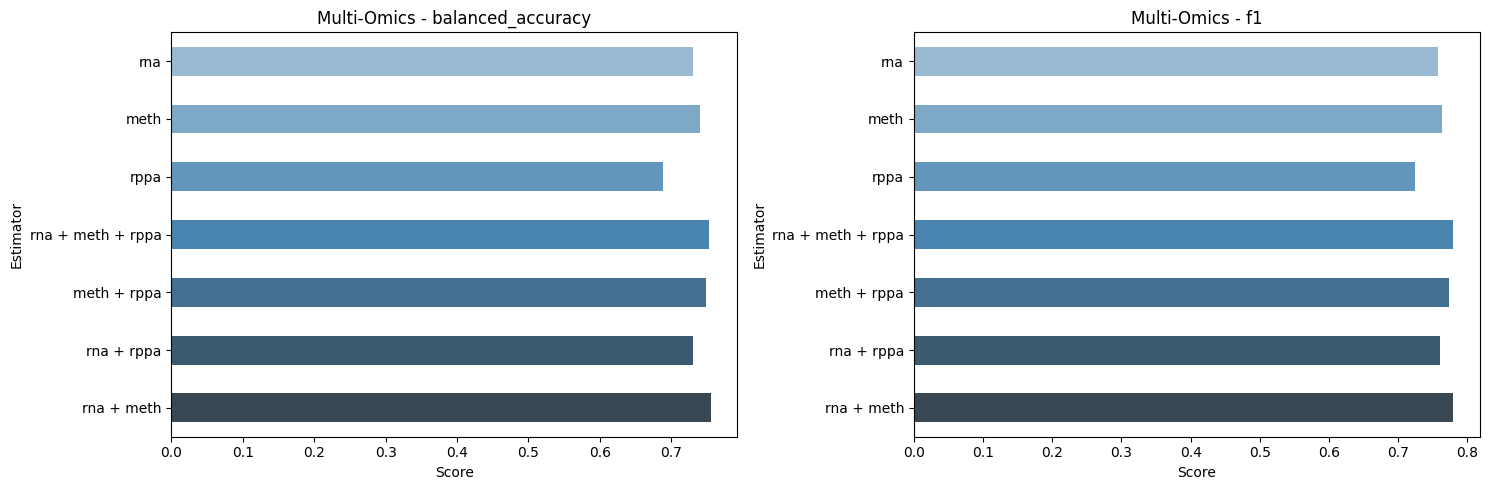

In [ ]:
plot_bar_scores(names, all_integration_scores.values(), 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


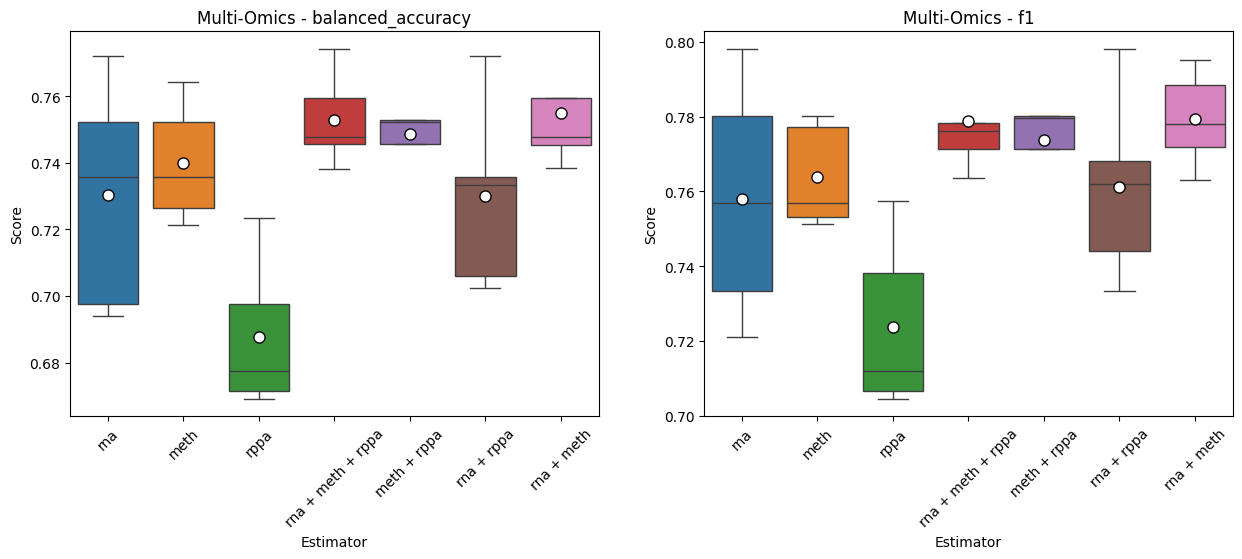

In [ ]:
plot_box_scores(names, all_integration_scores.values(), 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

## Statistical Significance

Now that we see the results, we want to check if the performance differences between our multi-omics ensemble models and the modality ensemble models are significant. We can employ the Wilcoxen test, using multiple replications of cross-validation to get scores.

### Wilcoxen

In [30]:
ensemble_results = {}
ensemble_metrics = {}

In [ ]:
def wilcoxen_test(name_1, name_2, scores_1, scores_2):

    stat, p = wilcoxon(scores_1, scores_2, alternative='greater')

    df = pd.Series({'estimator_1': name_1, 'estimator_2': name_2, 'statistic': stat, 'p': p, 'significant': p <= 0.05})

    return pd.DataFrame(df).T

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
ensemble_results['rna'], ensemble_metrics['rna'] = get_cross_metrics(classifiers['rna'], X['rna'], y, name='rna', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_stage_scoring)

In [ ]:
ensemble_results['meth'], ensemble_metrics['meth'] = get_cross_metrics(classifiers['meth'], X['meth'], y, name='meth', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_stage_scoring)

In [31]:
ensemble_results['rppa'], ensemble_metrics['rppa'] = get_cross_metrics(classifiers['rppa'], X['rppa'], y, name='rppa', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_stage_scoring)

In [ ]:
ensemble_results['rna + meth'], ensemble_metrics['rna + meth'] = get_cross_metrics(meta_ensembles['rna + meth'], X_merged['rna + meth'], y, name='rna + meth', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_stage_scoring, fit_params={'column_names': {key: column_names[key] for key in ['rna', 'meth']}})

In [ ]:
ensemble_results['rna + rppa'], ensemble_metrics['rna + rppa'] = get_cross_metrics(meta_ensembles['rna + rppa'], X_merged['rna + rppa'], y, name='rna + rppa', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_stage_scoring, fit_params={'column_names': {key: column_names[key] for key in ['rna', 'rppa']}})

In [ ]:
ensemble_results['meth + rppa'], ensemble_metrics['meth + rppa'] = get_cross_metrics(meta_ensembles['meth + rppa'], X_merged['meth + rppa'], y, name='meth + rppa', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_stage_scoring, fit_params={'column_names': {key: column_names[key] for key in ['meth', 'rppa']}})

In [ ]:
ensemble_results['rna + meth + rppa'], ensemble_metrics['rna + meth + rppa'] = get_cross_metrics(meta_ensembles['rna + meth + rppa'], X_merged['rna + meth + rppa'], y, name='rna + meth + rppa', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_stage_scoring, fit_params={'column_names': column_names})

In [ ]:
# Picking models we want to compare performances for
compare = [
    ('rna + meth + rppa', 'meth'),
    ('rna + meth', 'meth'),
    ('meth + rppa', 'meth'),
    ('rna + rppa', 'rna')
]

In [ ]:
from scipy.stats import wilcoxon

wilcoxen_results = {}
metrics = ['balanced_accuracy', 'f1']

for metric in metrics:
    wilcoxen_results[metric] = pd.DataFrame()
    for est1, est2 in compare:
        df = wilcoxen_test(est1, est2, ensemble_results[est1]['test_' + metric], ensemble_results[est2]['test_' + metric])
        wilcoxen_results[metric] = pd.concat([wilcoxen_results[metric], df])


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [ ]:
display(wilcoxen_results['balanced_accuracy'], wilcoxen_results['f1'])

estimator_1 estimator_2 statistic         p significant
0  rna + meth + rppa        meth      98.0  0.015076        True
0         rna + meth        meth      83.5  0.103882       False
0        meth + rppa        meth      62.5  0.264978       False
0         rna + rppa         rna      74.0  0.227142       False

estimator_1 estimator_2 statistic         p significant
0  rna + meth + rppa        meth      99.0  0.012787        True
0         rna + meth        meth      87.0  0.067688       False
0        meth + rppa        meth      62.0  0.275462       False
0         rna + rppa         rna      83.0  0.103882       False

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


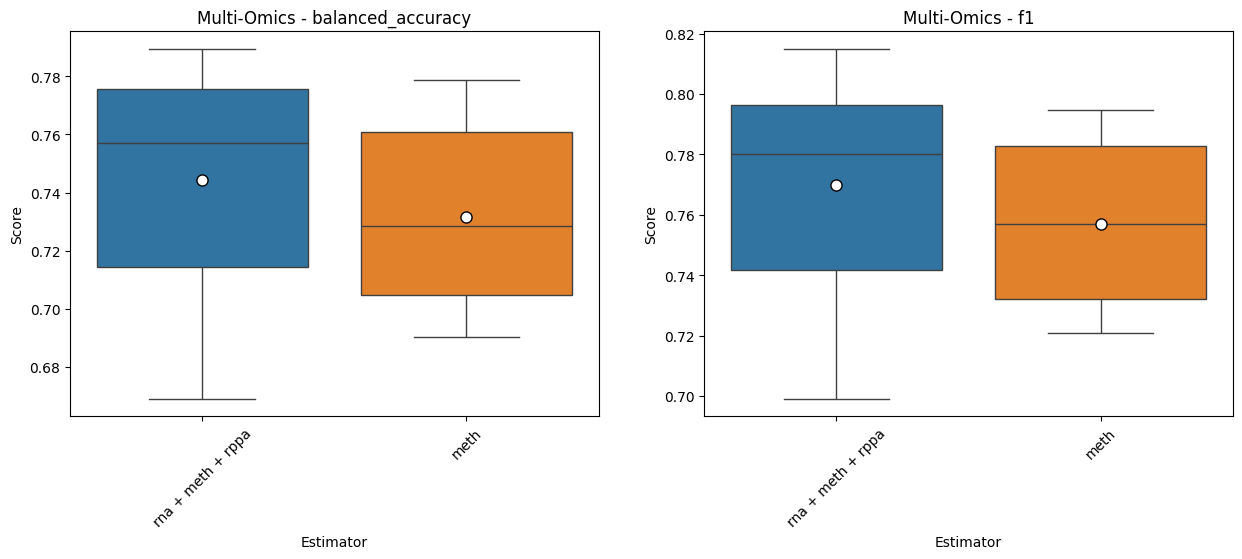

In [ ]:
plot_box_scores(['rna + meth + rppa', 'meth'], [ensemble_results['rna + meth + rppa'], ensemble_results['meth']], 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


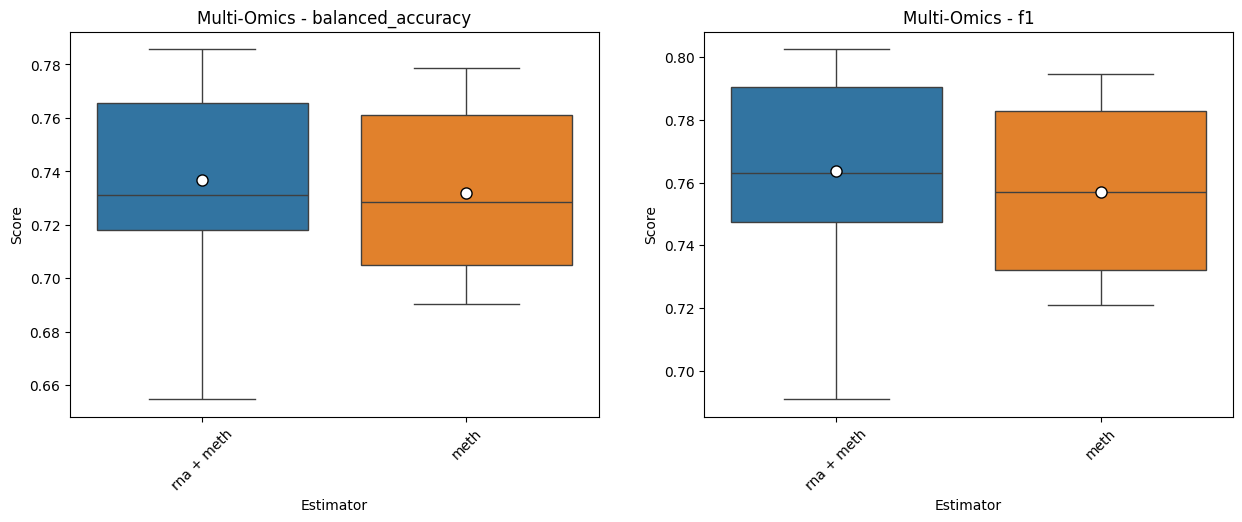

In [ ]:
plot_box_scores(['rna + meth', 'meth'], [ensemble_results['rna + meth'], ensemble_results['meth']], 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


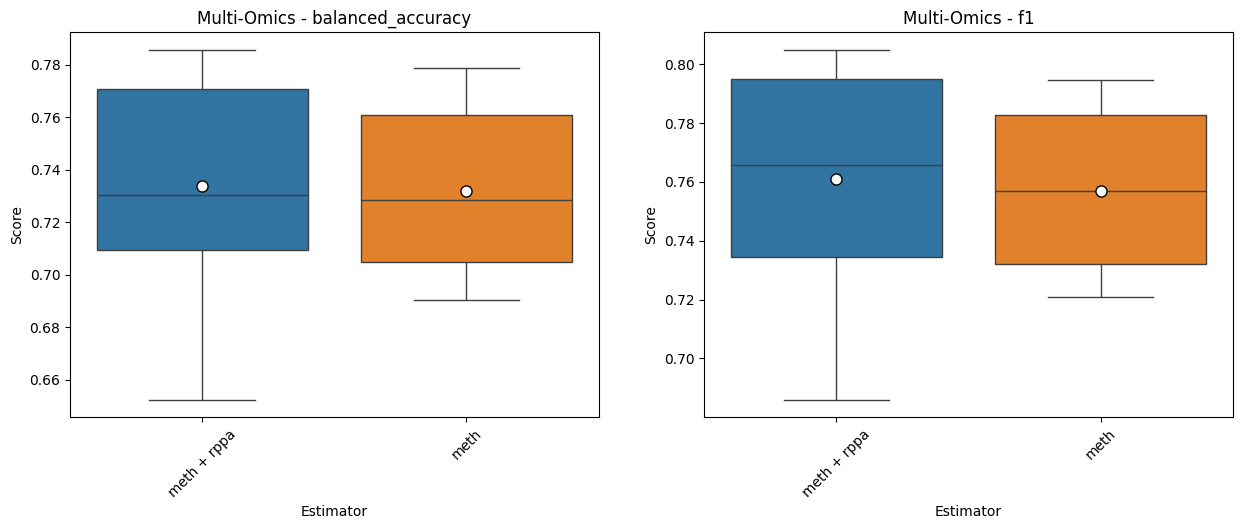

In [ ]:
plot_box_scores(['meth + rppa', 'meth'], [ensemble_results['meth + rppa'], ensemble_results['meth']], 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


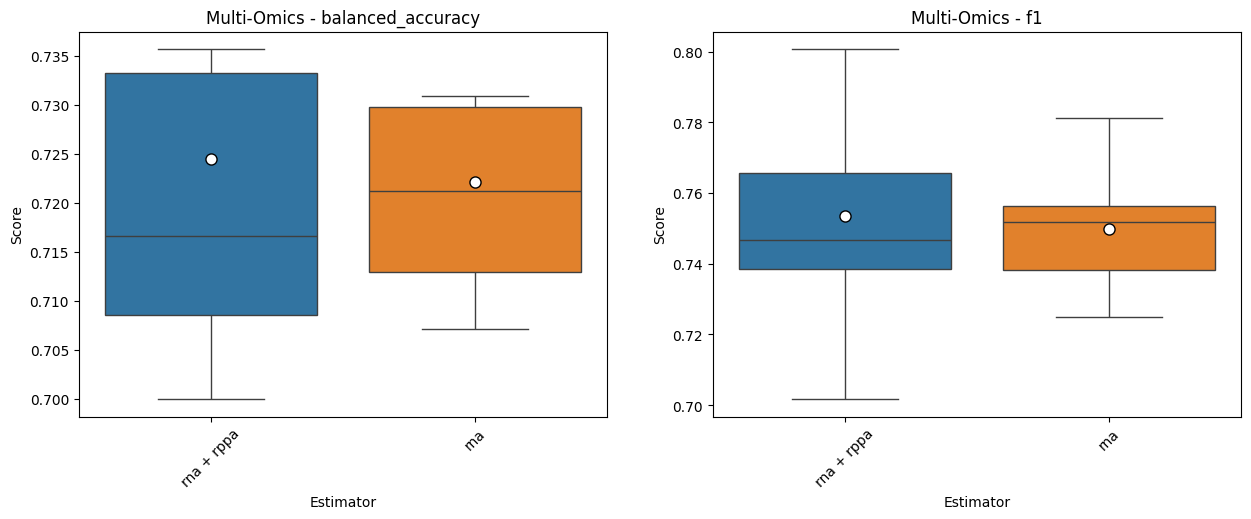

In [ ]:
plot_box_scores(['rna + rppa', 'rna'], [ensemble_results['rna + rppa'], ensemble_results['rna']], 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

In [ ]:
# Run this if continuing an already saved run:
with open("results/kipan/staging/kipan_5x3_results_3.json",'r+') as file:
    ensemble_results_2 = json.load(file)
    ensemble_metrics_2 = pd.DataFrame()

    for model in ensemble_results_2:
      metrics = {}

      for scorer in kipan_stage_scoring:
        metrics[scorer] = []

      for scorer in kipan_stage_scoring:
          metrics[scorer].append(
              "%0.3f +/- %0.3f"
              % (np.mean(ensemble_results_2[model]["test_%s" % scorer]), np.std(ensemble_results_2[model]["test_%s" % scorer]))
      )
      ensemble_metrics_2 = pd.concat([ensemble_metrics_2, pd.DataFrame(metrics, index=[model])])

In [ ]:
ensemble_metrics_2

accuracy balanced_accuracy               f1  \
meth + rppa        0.766 +/- 0.036   0.734 +/- 0.039  0.761 +/- 0.037   
meth               0.761 +/- 0.027   0.732 +/- 0.029  0.757 +/- 0.027   
rna + meth + rppa  0.775 +/- 0.033   0.744 +/- 0.038  0.770 +/- 0.035   
rna + meth         0.769 +/- 0.027   0.737 +/- 0.035  0.764 +/- 0.030   
rna + rppa         0.760 +/- 0.028   0.724 +/- 0.031  0.753 +/- 0.029   
rna                0.755 +/- 0.024   0.722 +/- 0.026  0.750 +/- 0.025   

                    recall (early)    recall (late)  
meth + rppa        0.862 +/- 0.043  0.606 +/- 0.070  
meth               0.847 +/- 0.038  0.617 +/- 0.060  
rna + meth + rppa  0.864 +/- 0.042  0.625 +/- 0.076  
rna + meth         0.865 +/- 0.034  0.609 +/- 0.080  
rna + rppa         0.866 +/- 0.049  0.583 +/- 0.071  
rna                0.851 +/- 0.038  0.593 +/- 0.051

In [32]:
integration_results = {}
integration_results['rna'] = ensemble_results_2['rna']
integration_results['meth'] = ensemble_results_2['meth']
integration_results['rppa'] = ensemble_results['rppa']
integration_results['rna + meth'] = ensemble_results_2['rna + meth']
integration_results['rna + rppa'] = ensemble_results_2['rna + rppa']
integration_results['meth + rppa'] = ensemble_results_2['meth + rppa']
integration_results['rna + meth + rppa'] = ensemble_results_2['rna + meth + rppa']

In [35]:
integration_metrics = pd.DataFrame()

for model in integration_results:
      metrics = {}

      for scorer in kipan_stage_scoring:
        metrics[scorer] = []

      for scorer in kipan_stage_scoring:
          metrics[scorer].append(
              "%0.3f +/- %0.3f"
              % (np.mean(integration_results[model]["test_%s" % scorer]), np.std(integration_results[model]["test_%s" % scorer]))
      )
      integration_metrics = pd.concat([integration_metrics, pd.DataFrame(metrics, index=[model])])

In [36]:
integration_metrics

accuracy balanced_accuracy               f1  \
rna                0.755 +/- 0.024   0.722 +/- 0.026  0.750 +/- 0.025   
meth               0.761 +/- 0.027   0.732 +/- 0.029  0.757 +/- 0.027   
rppa               0.732 +/- 0.043   0.689 +/- 0.044  0.723 +/- 0.043   
rna + meth         0.769 +/- 0.027   0.737 +/- 0.035  0.764 +/- 0.030   
rna + rppa         0.760 +/- 0.028   0.724 +/- 0.031  0.753 +/- 0.029   
meth + rppa        0.766 +/- 0.036   0.734 +/- 0.039  0.761 +/- 0.037   
rna + meth + rppa  0.775 +/- 0.033   0.744 +/- 0.038  0.770 +/- 0.035   

                    recall (early)    recall (late)  
rna                0.851 +/- 0.038  0.593 +/- 0.051  
meth               0.847 +/- 0.038  0.617 +/- 0.060  
rppa               0.859 +/- 0.049  0.519 +/- 0.062  
rna + meth         0.865 +/- 0.034  0.609 +/- 0.080  
rna + rppa         0.866 +/- 0.049  0.583 +/- 0.071  
meth + rppa        0.862 +/- 0.043  0.606 +/- 0.070  
rna + meth + rppa  0.864 +/- 0.042  0.625 +/- 0.076

In [37]:
names = ['rna', 'meth', 'rppa', 'rna + meth', 'rna + rppa', 'meth + rppa', 'rna + meth + rppa']

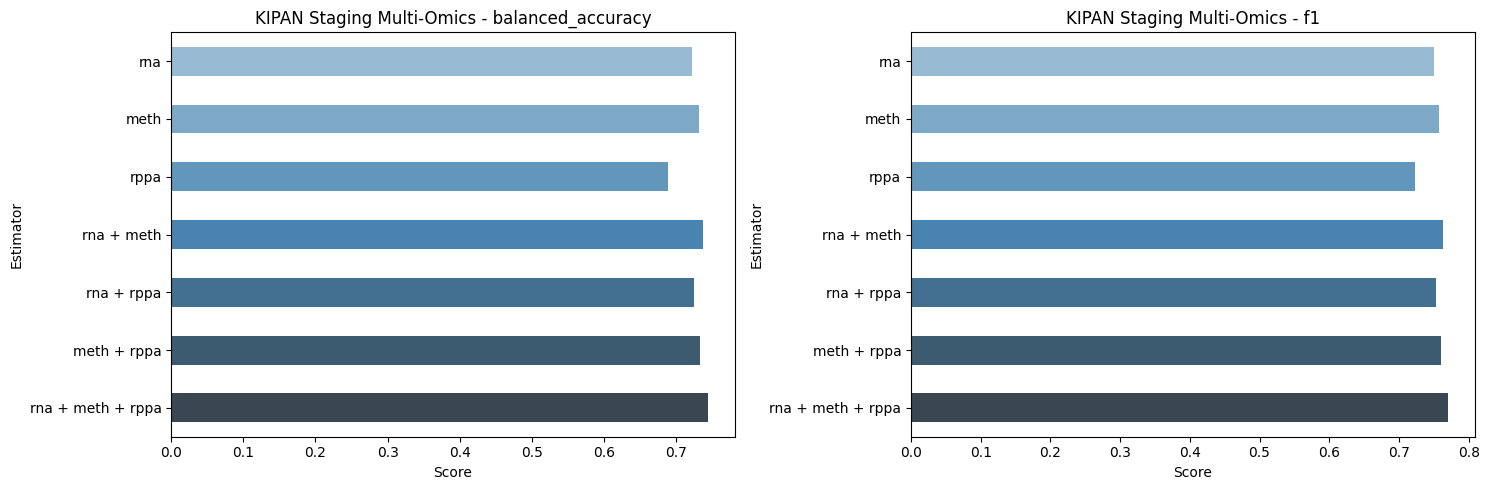

In [38]:
plot_bar_scores(names, integration_results.values(), 'KIPAN Staging Multi-Omics', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


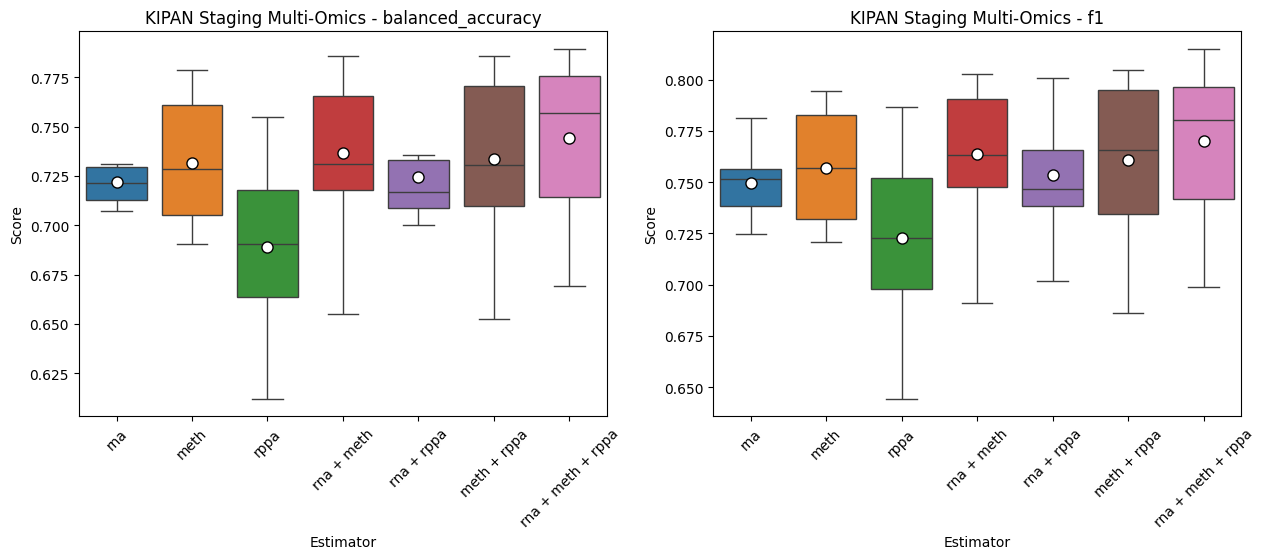

In [39]:
plot_box_scores(names, integration_results.values(), 'KIPAN Staging Multi-Omics', metrics=['balanced_accuracy', 'f1'])

In [41]:
# Convert and write JSON object to file
with open("results/kipan/staging/kipan_5x3_results_final.json", "w") as outfile:
    json.dump(integration_results, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

## Feature Importance

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

In [ ]:
# Splitting into training, validation
X_train, X_test, y_train, y_test = train_test_split(X_merged['rna + meth + rppa'], y, random_state=0, stratify=y)

In [ ]:
# Fitting on training data
meta_ensembles['rna + meth + rppa'].fit(X_train, y_train, column_names)

MultiOmicsIntegrationClassifier(cv=3,
                                estimator_dict={'meth': ModalityPipeline(cv=3,
                                                                         estimator_list=[('logistic',
                                                                                          Pipeline(steps=[('standardscaler',
                                                                                                           StandardScaler()),
                                                                                                          ('logisticregression',
                                                                                                           LogisticRegression(max_iter=1000,
                                                                                                                              n_jobs=-1,
                                                                                                                              random_state=0))])),
                                                                                         ('balanced_random_forest',
                                                                                          BalancedRandomForestClassifier(n_jobs=-1,
                                                                                                                         random_state=0,
                                                                                                                         replacement=True,
                                                                                                                         samp...
                                                                                         ('balanced_random_forest',
                                                                                          BalancedRandomForestClassifier(n_jobs=-1,
                                                                                                                         random_state=0,
                                                                                                                         replacement=True,
                                                                                                                         sampling_strategy='all')),
                                                                                         ('deep_nn',
                                                                                          Pipeline(steps=[('standardscaler',
                                                                                                           StandardScaler()),
                                                                                                          ('mlpclassifier',
                                                                                                           MLPClassifier(random_state=0))])),
                                                                                         ('svc',
                                                                                          Pipeline(steps=[('standardscaler',
                                                                                                           StandardScaler()),
                                                                                                          ('svc',
                                                                                                           SVC(kernel='linear',
                                                                                                               max_iter=1000,
                                                                                                               random_state=0))]))])})

In [ ]:
# Getting baseline scores
baseline_scores = {}
for name, scorer in kipan_stage_scoring.items():
  baseline_scores[name] = get_scorer(scorer)(meta_ensembles['rna + meth + rppa'], X_test, y_test)

In [ ]:
pd.DataFrame(baseline_scores, index=[""])

accuracy  balanced_accuracy        f1  recall (early)  recall (late)
  0.778571           0.745192  0.773469           0.875       0.615385

In [ ]:
#TODO: try mlxtend permutation importance which lets you group features together - measure correlation, then put them in groups
#https://rasbt.github.io/mlxtend/api_subpackages/mlxtend.evaluate/#feature_importance_permutation

In [ ]:
result = permutation_importance(meta_ensembles['rna + meth + rppa'], X_test, y_test, n_repeats=10, random_state=0, scoring=kipan_stage_scoring, n_jobs=-1)

In [ ]:
sorted_importances_idx = result['balanced_accuracy'].importances_mean.argsort()
importances = pd.DataFrame(
    result['balanced_accuracy'].importances[sorted_importances_idx].T,
    columns=X_merged['rna + meth + rppa'].columns[sorted_importances_idx],
)

importances.head()

FAM166A_meth  UGT1A8_meth  TSIX_rna  OR7A10_meth  ROR2_meth  EGFLAM_meth  \
0     -0.009615     0.000000 -0.009615    -0.009615  -0.009615    -0.009615   
1     -0.009615    -0.019231 -0.009615     0.000000  -0.009615    -0.009615   
2     -0.009615     0.000000  0.000000    -0.009615  -0.019231    -0.009615   
3     -0.009615    -0.009615 -0.009615     0.000000   0.000000     0.000000   
4     -0.019231    -0.019231 -0.009615    -0.009615   0.000000    -0.009615   

   NDUFA13_meth  CASS4_meth  ABCA6_meth  OR6C76_meth  ...  NCAM1_rna  \
0      0.000000    0.000000   -0.009615    -0.009615  ...   0.005682   
1     -0.009615   -0.019231   -0.009615     0.000000  ...   0.000000   
2     -0.009615    0.000000   -0.009615    -0.009615  ...   0.005682   
3     -0.019231   -0.009615   -0.009615    -0.009615  ...   0.005682   
4     -0.009615   -0.009615   -0.009615    -0.009615  ...   0.000000   

   TSHZ2_meth  CRABP1_rna  FN1|Fibronectin_rppa  KERA_rna  \
0    0.005682    0.005682              0.009615  0.005682   
1    0.005682    0.005682              0.000000  0.005682   
2    0.000000    0.005682              0.000000  0.005682   
3    0.005682    0.000000              0.000000  0.005682   
4    0.005682    0.000000              0.019231  0.005682   

   STMN1|Stathmin_rppa  ITIH4_rna  CDKN1B|p27_pT198_rppa  LCN1_rna  \
0             0.005682   0.005682               0.005682  0.005682   
1             0.005682   0.005682               0.005682  0.005682   
2             0.000000   0.005682               0.005682  0.005682   
3             0.005682   0.005682               0.005682  0.005682   
4             0.005682   0.005682               0.005682  0.005682   

   RAF1|C-Raf_pS338_rppa  
0               0.005682  
1               0.015297  
2               0.000000  
3               0.000000  
4               0.015297  

[5 rows x 2168 columns]

In [ ]:
importances.iloc[:, -20:].columns

Index(['ERBB2|HER2_pY1248_rppa', 'MFI2_rna', 'CAV1|Caveolin-1_rppa', 'H19_rna',
       'VWA3A_rna', 'SLC4A10_meth', 'PPP1R3C_meth', 'FAM101A_rna',
       'GPR109B_rna', 'C1orf61_rna', 'NCAM1_rna', 'TSHZ2_meth', 'CRABP1_rna',
       'FN1|Fibronectin_rppa', 'KERA_rna', 'STMN1|Stathmin_rppa', 'ITIH4_rna',
       'CDKN1B|p27_pT198_rppa', 'LCN1_rna', 'RAF1|C-Raf_pS338_rppa'],
      dtype='object')

In [ ]:
importances.mean()[-20:].index

Index(['ERBB2|HER2_pY1248_rppa', 'MFI2_rna', 'CAV1|Caveolin-1_rppa', 'H19_rna',
       'VWA3A_rna', 'SLC4A10_meth', 'PPP1R3C_meth', 'FAM101A_rna',
       'GPR109B_rna', 'C1orf61_rna', 'NCAM1_rna', 'TSHZ2_meth', 'CRABP1_rna',
       'FN1|Fibronectin_rppa', 'KERA_rna', 'STMN1|Stathmin_rppa', 'ITIH4_rna',
       'CDKN1B|p27_pT198_rppa', 'LCN1_rna', 'RAF1|C-Raf_pS338_rppa'],
      dtype='object')

'ax = importances.iloc[:, -20:].plot.bar()\nax.set_title("Permutation Importances (test set)")\nax.axvline(x=0, color="k", linestyle="--")\nax.set_xlabel("Decrease in balanced accuracy score")\nax.figure.tight_layout()'

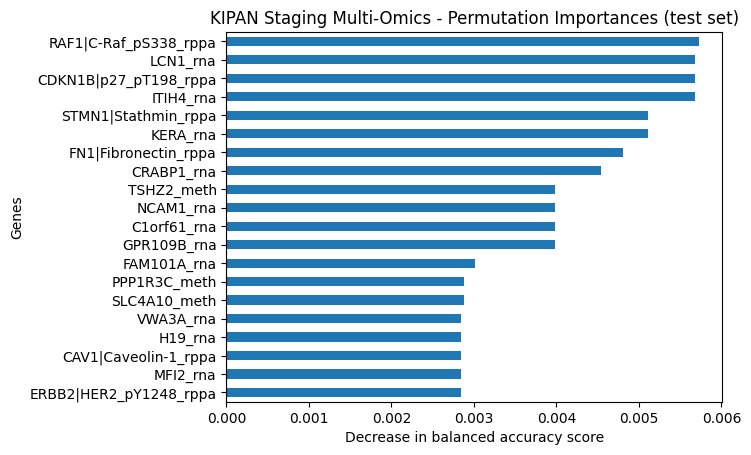

In [ ]:
ax = importances.mean()[-20:].plot(kind='barh')
ax.set_title("KIPAN Staging Multi-Omics - Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in balanced accuracy score")
ax.set_ylabel('Genes')


In [ ]:
top_genes = []

for i in result['balanced_accuracy'].importances_mean.argsort()[::-1]:
     if result['balanced_accuracy'].importances_mean[i] > 0:
        top_genes.append(X_merged['rna + meth + rppa'].columns[i])
        print(f"{X_merged['rna + meth + rppa'].columns[i]:<8}  "
               f"{result['balanced_accuracy'].importances_mean[i]:.5f}"
               f" +/- {result['balanced_accuracy'].importances_std[i]:.4f}")

RAF1|C-Raf_pS338_rppa  0.00573 +/- 0.0071
LCN1_rna  0.00568 +/- 0.0000
CDKN1B|p27_pT198_rppa  0.00568 +/- 0.0000
ITIH4_rna  0.00568 +/- 0.0000
STMN1|Stathmin_rppa  0.00511 +/- 0.0017
KERA_rna  0.00511 +/- 0.0017
FN1|Fibronectin_rppa  0.00481 +/- 0.0065
CRABP1_rna  0.00455 +/- 0.0023
TSHZ2_meth  0.00398 +/- 0.0026
NCAM1_rna  0.00398 +/- 0.0026
C1orf61_rna  0.00398 +/- 0.0026
GPR109B_rna  0.00398 +/- 0.0026
FAM101A_rna  0.00302 +/- 0.0034
PPP1R3C_meth  0.00288 +/- 0.0044
SLC4A10_meth  0.00288 +/- 0.0044
VWA3A_rna  0.00284 +/- 0.0028
H19_rna   0.00284 +/- 0.0028
CAV1|Caveolin-1_rppa  0.00284 +/- 0.0028
MFI2_rna  0.00284 +/- 0.0038
ERBB2|HER2_pY1248_rppa  0.00284 +/- 0.0028
PEA15|PEA15_rppa  0.00249 +/- 0.0051
WNK2_rna  0.00227 +/- 0.0028
CHEK2|Chk2_pT68_rppa  0.00227 +/- 0.0028
ADAM6_rna  0.00227 +/- 0.0028
IGJ_rna   0.00227 +/- 0.0028
C12ORF5|TIGAR_rppa  0.00192 +/- 0.0038
HIF3A_meth  0.00114 +/- 0.0073
BDKRB2_rna  0.00114 +/- 0.0023
THRSP_rna  0.00114 +/- 0.0023
LAMC2_rna  0.00114 +/- 0

In [ ]:
top_genes_modality = {}

for modality in datasets:
  top_genes_modality[modality] = []

for gene in top_genes:
  for modality in datasets:
    if ("_" + modality) in gene:
      #top_genes_modality[modality].append(gene.removesuffix('_'+modality))
      top_genes_modality[modality].append(gene)
      break

In [ ]:
# Printing to copy-paste into top-gene for enrichment analysis
for modality in top_genes_modality:
  print(f"{modality}: " + ','.join(top_genes_modality[modality]))
  print("")

rna: LCN1_rna,ITIH4_rna,KERA_rna,CRABP1_rna,NCAM1_rna,C1orf61_rna,GPR109B_rna,FAM101A_rna,VWA3A_rna,H19_rna,MFI2_rna,WNK2_rna,ADAM6_rna,IGJ_rna,BDKRB2_rna,THRSP_rna,LAMC2_rna,MGC29506_rna,LOC642587_rna,SLC6A19_rna,TMPRSS3_rna,CPXM1_rna,MCHR2_rna,OR5C1_rna,SPANXN3_rna,FBP2_rna,CALML5_rna,SERPINE1_rna,TM4SF4_rna,CCDC91_rna,XAGE1D_rna,POU2AF1_rna,DHRS2_rna,CGB8_rna,CXCL17_rna,KRT19_rna,CHST2_rna,MXRA5_rna,AEBP1_rna,GRIA2_rna

meth: TSHZ2_meth,PPP1R3C_meth,SLC4A10_meth,HIF3A_meth,OPRM1_meth,GLDN_meth,MAP3K1_meth,C19orf60_meth,CDKL4_meth,OTOP3_meth,PYY_meth,NFKBIZ_meth,MIR214_meth,CD14_meth,KRTAP19-5_meth

rppa: RAF1|C-Raf_pS338_rppa,CDKN1B|p27_pT198_rppa,STMN1|Stathmin_rppa,FN1|Fibronectin_rppa,CAV1|Caveolin-1_rppa,ERBB2|HER2_pY1248_rppa,PEA15|PEA15_rppa,CHEK2|Chk2_pT68_rppa,C12ORF5|TIGAR_rppa,MAP2K1|MEK1_pS217_S221_rppa,PECAM1|CD31_rppa,EEF2K|eEF2K_rppa,ERBB3|HER3_rppa,TP53BP1|53BP1_rppa,PREX1|PREX1_rppa,EIF4E|eIF4E_rppa



In [ ]:
# Convert and write csv object to file
with open("results/kipan/staging/permutation_results.csv", "w") as outfile:
    importances.to_csv(outfile)

In [ ]:
with open("results/kipan/staging/marker_genes.json", "w") as outfile:
    json.dump(top_genes_modality, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

### SHAP

In [ ]:
!pip install shap

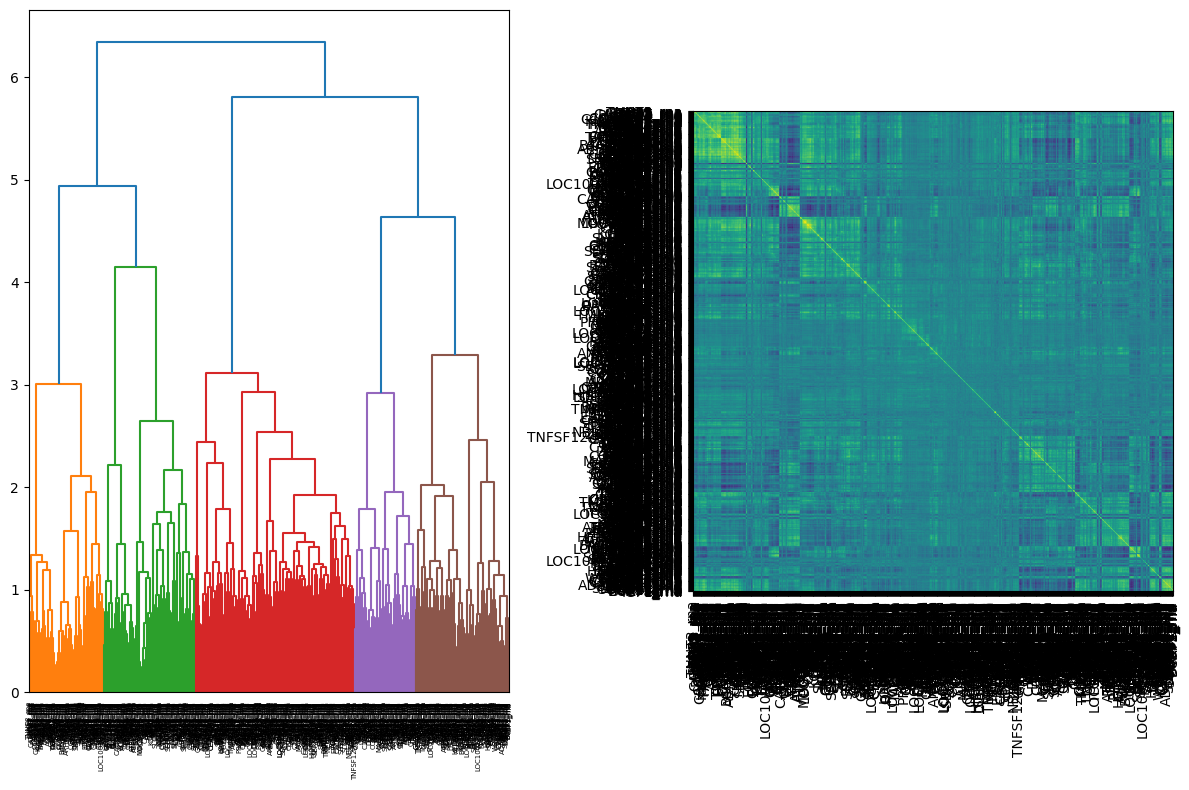

In [ ]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X['rna']).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
'''dendro = hierarchy.dendrogram(
    dist_linkage, labels=X['rna'].columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()'''

In [ ]:
from collections import defaultdict
X_sel = {}
X_sel = {}

for modality in datasets:

  corr = spearmanr(X[modality]).correlation

  # Ensure the correlation matrix is symmetric
  corr = (corr + corr.T) / 2
  np.fill_diagonal(corr, 1)

  # We convert the correlation matrix to a distance matrix before performing
  # hierarchical clustering using Ward's linkage.
  distance_matrix = 1 - np.abs(corr)
  dist_linkage = hierarchy.ward(squareform(distance_matrix))

  cluster_ids = hierarchy.fcluster(dist_linkage, 0.75, criterion="distance")
  cluster_id_to_feature_ids = defaultdict(list)
  for idx, cluster_id in enumerate(cluster_ids):
      cluster_id_to_feature_ids[cluster_id].append(idx)
  selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
  selected_features_names = X[modality].columns[selected_features]

  X_sel[modality] = X[modality][selected_features_names]
  X_sel[modality] = X[modality][selected_features_names]

In [ ]:
column_names_sel = {}

for key in X_sel.keys():
  column_names_sel[key] = X_sel[key].columns
  print(len(column_names_sel[key]))

354
215
60


In [ ]:
X_merged_sel = {}
X_merged_sel['rna + meth + rppa'] = pd.concat([X_sel['rna'], X_sel['meth'], X_sel['rppa']], axis=1, join='inner')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_merged_sel['rna + meth + rppa'], y, random_state=0, stratify=y)

In [ ]:
# Fitting on training data
meta_ensembles['rna + meth + rppa'].fit(X_train, y_train, column_names_sel)

MultiOmicsIntegrationClassifier(cv=3,
                                estimator_dict={'meth': ModalityPipeline(cv=3,
                                                                         estimator_list=[('logistic',
                                                                                          Pipeline(steps=[('standardscaler',
                                                                                                           StandardScaler()),
                                                                                                          ('logisticregression',
                                                                                                           LogisticRegression(max_iter=1000,
                                                                                                                              n_jobs=-1,
                                                                                                                              random_state=0))])),
                                                                                         ('balanced_random_forest',
                                                                                          BalancedRandomForestClassifier(n_jobs=-1,
                                                                                                                         random_state=0,
                                                                                                                         replacement=True,
                                                                                                                         samp...
                                                                                         ('balanced_random_forest',
                                                                                          BalancedRandomForestClassifier(n_jobs=-1,
                                                                                                                         random_state=0,
                                                                                                                         replacement=True,
                                                                                                                         sampling_strategy='all')),
                                                                                         ('deep_nn',
                                                                                          Pipeline(steps=[('standardscaler',
                                                                                                           StandardScaler()),
                                                                                                          ('mlpclassifier',
                                                                                                           MLPClassifier(random_state=0))])),
                                                                                         ('svc',
                                                                                          Pipeline(steps=[('standardscaler',
                                                                                                           StandardScaler()),
                                                                                                          ('svc',
                                                                                                           SVC(kernel='linear',
                                                                                                               max_iter=1000,
                                                                                                               random_state=0))]))])})

In [ ]:
# Getting baseline scores
baseline_scores = {}
for name, scorer in kipan_stage_scoring.items():
  #y_preds = meta_ensembles['rna + rppa'].predict(X_test)
  baseline_scores[name] = get_scorer(scorer)(meta_ensembles['rna + meth + rppa'], X_test, y_test)

In [ ]:
# full dataset
pd.DataFrame(baseline_scores, index=[""])

accuracy  balanced_accuracy        f1  recall (early)  recall (late)
  0.742857           0.720717  0.741781        0.806818       0.634615

In [ ]:
# threshold = 0.5
pd.DataFrame(baseline_scores, index=[""])

accuracy  balanced_accuracy        f1  recall (early)  recall (late)
  0.764286           0.729895  0.758854        0.863636       0.596154

In [ ]:
# threshold = 0.75
pd.DataFrame(baseline_scores, index=[""])

accuracy  balanced_accuracy        f1  recall (early)  recall (late)
  0.742857           0.720717  0.741781        0.806818       0.634615

In [ ]:
# threshold = 1
pd.DataFrame(baseline_scores, index=[""])

accuracy  balanced_accuracy        f1  recall (early)  recall (late)
  0.714286           0.670455  0.704771        0.840909            0.5

In [ ]:
# threshold = 0.75
result = permutation_importance(meta_ensembles['rna + meth + rppa'], X_test, y_test, n_repeats=5, random_state=0, scoring=kipan_stage_scoring, n_jobs=-1)

In [ ]:
sorted_importances_idx = result['balanced_accuracy'].importances_mean.argsort()
importances = pd.DataFrame(
    result['balanced_accuracy'].importances[sorted_importances_idx].T,
    columns=X_merged['rna + meth + rppa'].columns[sorted_importances_idx],
)

importances.head()

NKG7_rna  MRAS_rna  MT2A_rna   HGF_rna  NDRG4_rna   LUM_rna  ACAN_rna  \
0 -0.026661 -0.015297 -0.009615 -0.017045  -0.009615 -0.020979 -0.026661   
1 -0.017045 -0.015297 -0.024913 -0.017045  -0.026661 -0.020979 -0.011364   
2 -0.026661 -0.020979 -0.015297 -0.017045  -0.020979 -0.015297  0.000000   
3 -0.011364 -0.024913 -0.015297 -0.011364   0.015297 -0.005682 -0.015297   
4 -0.022727 -0.015297 -0.019231 -0.017045  -0.030594 -0.005682 -0.015297   

   CXCL17_rna  FOSL1_rna  ISG15_rna  ...  EPHA3_rna  C16orf89_rna   DES_rna  \
0   -0.026661   0.000000  -0.007430  ...   0.015297      0.005682  0.009615   
1   -0.015297  -0.020979  -0.007430  ...   0.009615      0.024913  0.009615   
2   -0.009615  -0.015297  -0.032343  ...   0.005682      0.015297  0.009615   
3   -0.005682  -0.020979  -0.017045  ...   0.015297      0.000000  0.009615   
4   -0.005682  -0.005682   0.002185  ...   0.000000      0.000000  0.009615   

    HRG_rna  C5orf27_rna  MT1X_rna   LOX_rna  ITPR1_rna  GAS1_rna  KRT13_rna  
0  0.009615     0.009615 -0.001748  0.019231   0.019231  0.009615   0.000000  
1  0.009615     0.009615  0.023164  0.009615   0.009615  0.019231   0.019231  
2  0.009615     0.009615  0.002185 -0.005682   0.019231  0.009615   0.009615  
3  0.000000     0.009615  0.007867  0.019231   0.000000  0.019231   0.019231  
4  0.019231     0.009615  0.017483  0.009615   0.009615  0.009615   0.019231  

[5 rows x 629 columns]

In [ ]:
importances.iloc[:, -20:].columns

Index(['GAST_rna', 'EPHX3_rna', 'LEFTY2_rna', 'LAD1_rna', 'CHST2_rna',
       'IL17F_rna', 'LECT1_rna', 'KLK5_rna', 'HAO2_rna', 'GAGE2C_rna',
       'EPHA3_rna', 'C16orf89_rna', 'DES_rna', 'HRG_rna', 'C5orf27_rna',
       'MT1X_rna', 'LOX_rna', 'ITPR1_rna', 'GAS1_rna', 'KRT13_rna'],
      dtype='object')

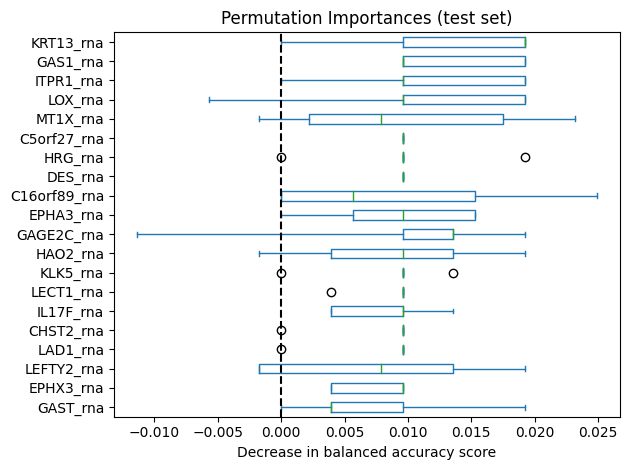

In [ ]:
# Printing top 20 important features
ax = importances.iloc[:, -20:].plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in balanced accuracy score")
ax.figure.tight_layout()

In [ ]:
top_genes = []

for i in result['balanced_accuracy'].importances_mean.argsort()[::-1]:
     if result['balanced_accuracy'].importances_mean[i] > 0:
        top_genes.append(X_merged['rna + meth + rppa'].columns[i])
        print(f"{X_merged['rna + meth + rppa'].columns[i]:<8}  "
               f"{result['balanced_accuracy'].importances_mean[i]:.3f}"
               f" +/- {result['balanced_accuracy'].importances_std[i]:.3f}")

KRT13_rna  0.013 +/- 0.008
GAS1_rna  0.013 +/- 0.005
ITPR1_rna  0.012 +/- 0.007
LOX_rna   0.010 +/- 0.009
MT1X_rna  0.010 +/- 0.009
C5orf27_rna  0.010 +/- 0.000
HRG_rna   0.010 +/- 0.006
DES_rna   0.010 +/- 0.000
C16orf89_rna  0.009 +/- 0.010
EPHA3_rna  0.009 +/- 0.006
GAGE2C_rna  0.009 +/- 0.011
HAO2_rna  0.009 +/- 0.007
KLK5_rna  0.008 +/- 0.005
LECT1_rna  0.008 +/- 0.002
IL17F_rna  0.008 +/- 0.004
CHST2_rna  0.008 +/- 0.004
LAD1_rna  0.008 +/- 0.004
LEFTY2_rna  0.007 +/- 0.008
EPHX3_rna  0.007 +/- 0.003
GAST_rna  0.007 +/- 0.007
MEG3_rna  0.007 +/- 0.003
LRRC39_rna  0.007 +/- 0.009
CLCA4_rna  0.007 +/- 0.004
C4orf7_rna  0.007 +/- 0.006
LAMB4_rna  0.007 +/- 0.004
LYZL1_rna  0.007 +/- 0.004
LCE2A_rna  0.007 +/- 0.009
ADAM30_rna  0.007 +/- 0.004
KRT15_rna  0.007 +/- 0.011
HMGA1_rna  0.006 +/- 0.009
CACNG7_rna  0.006 +/- 0.003
GSTM2_rna  0.006 +/- 0.005
GSTM3_rna  0.006 +/- 0.005
LOC55908_rna  0.006 +/- 0.005
LCN2_rna  0.006 +/- 0.005
IGFBP2_rna  0.006 +/- 0.005
LAMC2_rna  0.006 +/- 0.0

# RNA, Methylation, RPPA (feature selection, minus correlation)

In [ ]:
datasets = {
            'rna': '../data/kipan/staging/RNASeq.csv',
            'meth': '../data/kipan/staging/Methylation.csv',
            'rppa': '../data/kipan/staging/RPPA.csv',
}

labels = '../data/kipan/staging/Clinical.csv'

In [ ]:
subtypes = pd.read_csv(labels, index_col=0)
data = {}

for modality in datasets:
    data[modality] = pd.read_csv(datasets[modality], index_col=0)
    print(modality, data[modality].shape)

rna (558, 20190)
meth (558, 20116)
rppa (558, 202)


## Preprocessing

### Removing low-variance + null features

In [ ]:
!pip3 install scanpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 8.9 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=311c4ead8fff8f9cf37dae93fc1d91d9f9e8334c7b808606d951c0810f920d8d
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [ ]:
import scanpy as sc
from scanpy.pp import highly_variable_genes
import anndata as an

In [ ]:
adata = {}

for modality in datasets:
  data[modality] = data[modality].dropna(axis=1)
  adata[modality] = an.AnnData(data[modality])

In [ ]:
sc.pp.highly_variable_genes(adata['rna'], n_top_genes=1000)

In [ ]:
sc.pp.highly_variable_genes(adata['meth'], n_top_genes=1000)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:276: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


In [ ]:
sc.pp.highly_variable_genes(adata['rppa'], n_top_genes=1000)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:276: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


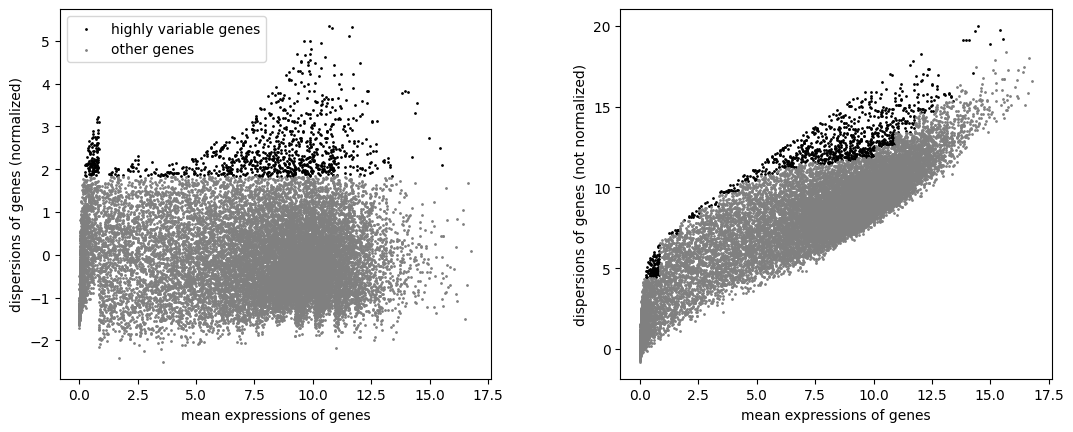

In [ ]:
sc.pl.highly_variable_genes(adata['rna'])

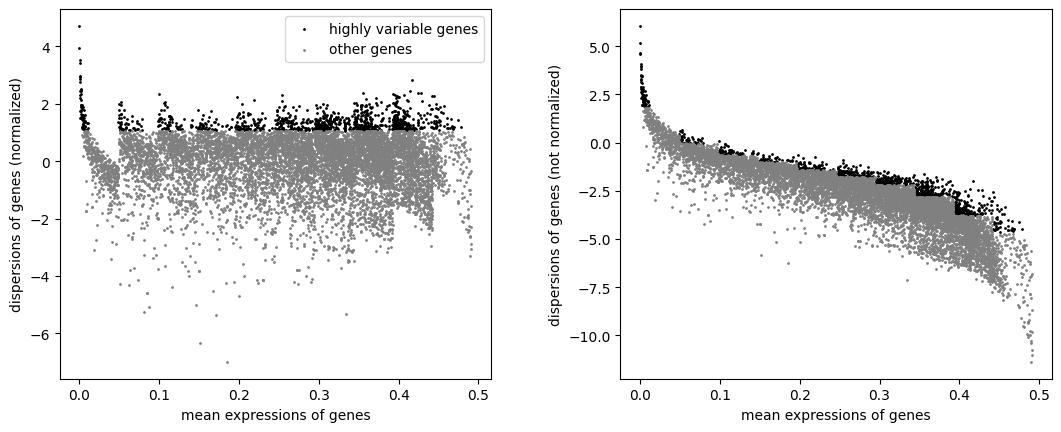

In [ ]:
sc.pl.highly_variable_genes(adata['meth'])

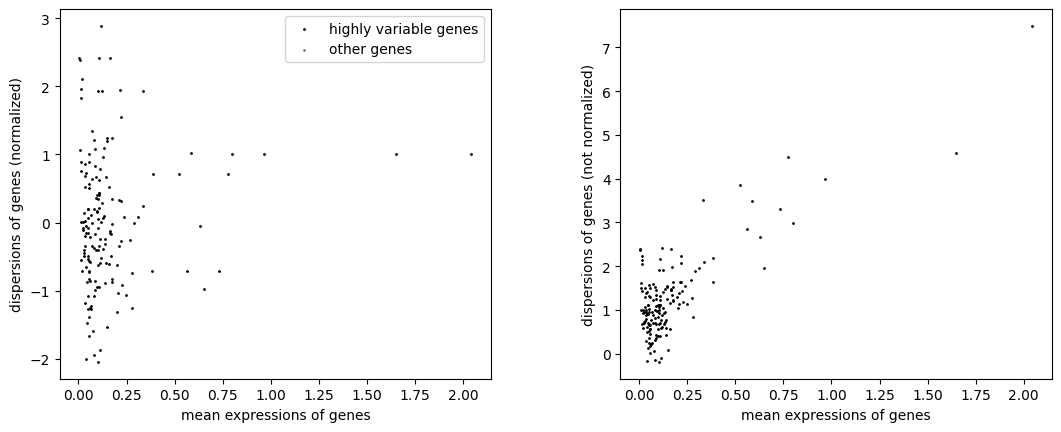

In [ ]:
sc.pl.highly_variable_genes(adata['rppa'])

In [ ]:
adata_new = {}

for modality in datasets:
  adata_new[modality] = adata[modality][:, adata[modality].var.highly_variable]
  sc.pp.scale(adata_new[modality], max_value=10)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model
        to generalize and improves the interpretability of the model.

    Inputs:
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output:
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in tqdm(iters):
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)
    print('Removed Columns {}'.format(drops))
    return x

In [ ]:
adata_new

{'rna': AnnData object with n_obs × n_vars = 558 × 1000
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'hvg',
 'meth': AnnData object with n_obs × n_vars = 558 × 1000
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'hvg',
 'rppa': AnnData object with n_obs × n_vars = 558 × 168
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'hvg'}

In [ ]:
import pandas as pd

X = {}

# Convert numpy array to DataFrame
for modality in adata_new:
    X[modality] = adata_new[modality].to_df()
    X[modality] = remove_collinear_features(X[modality], 0.80)
    print(modality, X[modality].shape)

100%|██████████| 999/999 [00:57<00:00, 17.51it/s]


Removed Columns {'POU2AF1_rna', 'SDCBP2_rna', 'TPM2_rna', 'CD79A_rna', 'GAGE2C_rna', 'C11orf53_rna', 'DUSP15_rna', 'PLCG2_rna', 'CT47B1_rna', 'MT2A_rna', 'HS3ST2_rna', 'PLAC9_rna', 'SERPINB4_rna', 'LOC96610_rna', 'CXCL6_rna', 'GCOM1_rna', 'TMPRSS2_rna', 'TMEM213_rna', 'OR5C1_rna', 'DMRT2_rna', 'STAP1_rna', 'HBA2_rna', 'OR8K1_rna', 'C7orf59_rna', 'TMEM119_rna', 'EPHA3_rna', 'TSPY3_rna', 'HS6ST3_rna', 'GBP1_rna', 'ELN_rna', 'SAA2_rna', 'CNN1_rna', 'SFTPB_rna', 'CTAG2_rna', 'CD8A_rna', 'CD248_rna', 'DNASE1_rna', 'FBN3_rna', 'TEX13A_rna', 'UMOD_rna', 'NEURL_rna', 'CHIT1_rna', 'KCNG4_rna', 'COL5A1_rna', 'PRRX1_rna', 'FGG_rna', 'GCGR_rna', 'PGF_rna', 'ZNRF4_rna', 'FGF9_rna', 'WBSCR17_rna', 'OTUD6A_rna', 'PDGFRA_rna', 'PVALB_rna', 'CD7_rna', 'REG1B_rna', 'HEPACAM2_rna', 'HBB_rna', 'CXCL9_rna', 'FOXI2_rna', 'MT1H_rna', 'ZNF479_rna', 'ACTG2_rna', 'POSTN_rna', 'RHBG_rna', 'TSPY2_rna', 'ATP6V1G3_rna', 'SLC4A1_rna', 'LOC283999_rna', 'KLK4_rna', 'ERP27_rna', 'INPP5J_rna', 'PRR23B_rna', 'GAGE12J_rna

100%|██████████| 999/999 [00:48<00:00, 20.43it/s]


Removed Columns {'KDM4B_meth', 'BPGM_meth', 'MOBKL1A_meth', 'ODAM_meth', 'PPDPF_meth', 'ZNF532_meth', 'SLC1A2_meth', 'JMJD5_meth', 'C14orf53_meth', 'TMOD4_meth', 'MGC16384_meth', 'LOC440354_meth', 'FAM53B_meth', 'FNIP2_meth', 'IRS2_meth', 'BMF_meth', 'MOG_meth', 'ZNF704_meth', 'C10orf26_meth', 'UGT1A9_meth', 'ARL4D_meth', 'HTR3B_meth', 'SENP8_meth', 'VTI1A_meth', 'PSEN2_meth', 'SMURF1_meth', 'NOXA1_meth', 'ADAT3_meth', 'PVRL4_meth', 'IKZF4_meth', 'SLC12A3_meth', 'STK17A_meth', 'ETF1_meth', 'CTDSP2_meth', 'GPAM_meth', 'TMEM74_meth', 'TSPAN2_meth', 'LOC399959_meth', 'SLC35B4_meth', 'FGF7_meth', 'DOCK6_meth', 'HTT_meth', 'GPR107_meth', 'KDELC2_meth', 'MPPED2_meth', 'MYO19_meth', 'C10orf118_meth', 'SH3GLB2_meth', 'PTPLAD1_meth', 'FAM177B_meth', 'HOXB5_meth', 'AHCYL2_meth', 'SRGAP1_meth', 'FBXO32_meth', 'NR0B2_meth', 'MCC_meth', 'UBP1_meth', 'NLRP5_meth', 'BRF1_meth', 'HNRPLL_meth', 'PLAGL2_meth', 'KIAA0494_meth', 'MPP7_meth', 'OR2A12_meth', 'CAPN8_meth', 'LOC643008_meth', 'C11orf53_meth', 

100%|██████████| 167/167 [00:01<00:00, 140.17it/s]

Removed Columns {'STMN1|Stathmin_rppa', 'RPS6|S6_pS240_S244_rppa', 'TP53|p53_rppa', 'PRKCA |PKC-alpha_pS657_rppa'}
rppa (558, 164)


In [ ]:
X_new = {}

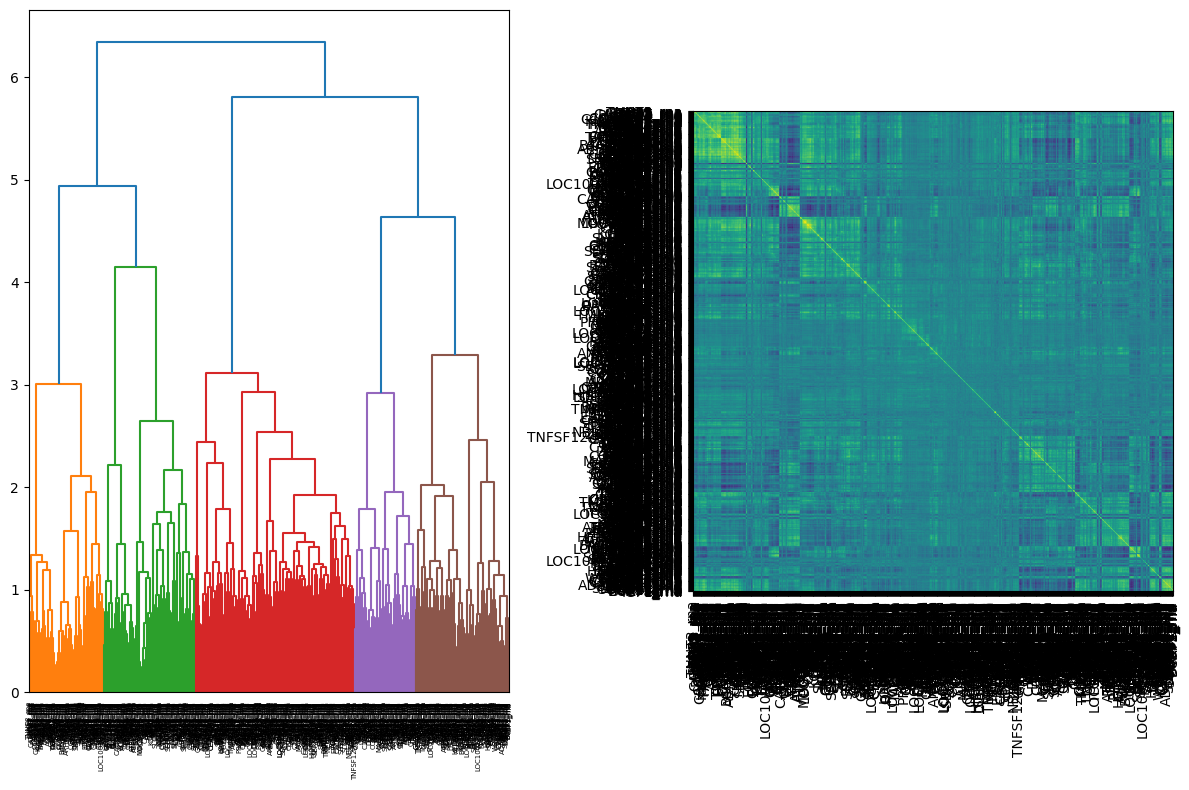

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X['rna']).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X['rna'].columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()

In [ ]:
cluster_ids = hierarchy.fcluster(dist_linkage, 0.5, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

selected_dictionary = {}

for v in cluster_id_to_feature_ids.values():
  selected_dictionary[X['rna'].columns[v[0]]] = X['rna'].columns[v[1:]]

selected_features_names = X['rna'].columns[selected_features]

In [ ]:
X_new_2 = X['rna'][selected_features_names]

In [ ]:
selected_dictionary

{'A2ML1_rna': Index([], dtype='object'),
 'ABCB11_rna': Index([], dtype='object'),
 'ABCB5_rna': Index([], dtype='object'),
 'ABCC2_rna': Index(['CACNA1E_rna', 'FAM151A_rna', 'KHK_rna', 'UGT1A8_rna'], dtype='object'),
 'ACAN_rna': Index(['ACTG2_rna', 'C6orf223_rna', 'CD248_rna', 'FAM101B_rna', 'FRZB_rna',
        'LGI4_rna', 'NPTX2_rna', 'PGF_rna', 'PLAC9_rna', 'PTHLH_rna'],
       dtype='object'),
 'ACPP_rna': Index(['C12orf59_rna'], dtype='object'),
 'ACSBG1_rna': Index([], dtype='object'),
 'ACTL6B_rna': Index([], dtype='object'),
 'ADAM30_rna': Index([], dtype='object'),
 'ADAM33_rna': Index(['HSPB6_rna', 'MFAP4_rna', 'PTGIS_rna'], dtype='object'),
 'ADAM6_rna': Index(['CD79A_rna', 'DERL3_rna', 'IGJ_rna', 'LOC96610_rna', 'MGC29506_rna',
        'PIM2_rna', 'PNOC_rna', 'POU2AF1_rna'],
       dtype='object'),
 'ADAMTSL1_rna': Index(['ADCY1_rna', 'BDKRB2_rna', 'CHST2_rna', 'KCNQ1_rna', 'NEURL_rna',
        'PLCG2_rna', 'RGS16_rna', 'SLC43A1_rna'],
       dtype='object'),
 'ADCYAP1_rna

In [ ]:
selected_features_names

Index(['A2ML1_rna', 'ABCB11_rna', 'ABCB5_rna', 'ABCC2_rna', 'ACAN_rna',
       'ACPP_rna', 'ACSBG1_rna', 'ACTL6B_rna', 'ADAM30_rna', 'ADAM33_rna',
       ...
       'VWA3A_rna', 'WFDC1_rna', 'WNK2_rna', 'WWOX_rna', 'XAGE1D_rna',
       'XPNPEP2_rna', 'ZDHHC22_rna', 'ZNF114_rna', 'ZP4_rna', 'ZPLD1_rna'],
      dtype='object', length=677)

In [ ]:
stages = pd.read_csv(labels, index_col=0)['pathologic_stage']
stages.value_counts()

stagei      280
stageiii    129
stageiv      79
stageii      70
Name: pathologic_stage, dtype: int64

In [ ]:
enc = LabelEncoder()
y = enc.fit_transform(stages)
enc.inverse_transform([0, 1, 2, 3])

array(['stagei', 'stageii', 'stageiii', 'stageiv'], dtype=object)

In [ ]:
# Assuming your array is named 'arr'
y = np.where(np.logical_or(y == 0, y == 1), 0, 1)

In [ ]:
unique, counts = np.unique(y, return_counts=True)
np.asarray((unique, counts)).T

array([[  0, 350],
       [  1, 208]])

## Base Learners

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

estimators = [
    ("logistic", make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=1000, n_jobs=-1))),
    ("balanced_random_forest", BalancedRandomForestClassifier(random_state=0, n_jobs=-1, sampling_strategy='all', replacement=True)),
    ("deep_nn", make_pipeline(StandardScaler(), MLPClassifier(random_state=0))),
    ("svc", make_pipeline(StandardScaler(), SVC(random_state=0, kernel='linear', max_iter=1000)))
]

estimator_names = [estimator[0] for estimator in estimators]

In [ ]:
kipan_stage_scoring = {"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (early)': make_scorer(recall_multiclass, label=0), 'recall (late)': make_scorer(recall_multiclass, label=1)}

In [ ]:
base_scores = {}
base_metrics_df = {}
base_metrics_df_train = {}

for modality in datasets:
    base_scores[modality], base_metrics_df[modality] = get_individual_scores(X[modality], y, estimators, scoring=kipan_stage_scoring)

 25%|██▌       | 1/4 [00:05<00:15,  5.20s/it]

logistic                  accuracy balanced_accuracy               f1   recall (early)  \
logistic  0.740 +/- 0.049   0.717 +/- 0.047  0.739 +/- 0.048  0.809 +/- 0.058   

            recall (late)  
logistic  0.625 +/- 0.047  


 50%|█████     | 2/4 [00:09<00:09,  4.81s/it]

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.760 +/- 0.023   0.737 +/- 0.019  0.758 +/- 0.022   

                         recall (early)    recall (late)  
balanced_random_forest  0.826 +/- 0.043  0.649 +/- 0.030  


 75%|███████▌  | 3/4 [00:16<00:05,  5.52s/it]

deep_nn                 accuracy balanced_accuracy               f1   recall (early)  \
deep_nn  0.735 +/- 0.039   0.710 +/- 0.036  0.733 +/- 0.038  0.809 +/- 0.055   

           recall (late)  
deep_nn  0.611 +/- 0.046  


100%|██████████| 4/4 [00:16<00:00,  4.18s/it]


svc             accuracy balanced_accuracy               f1   recall (early)  \
svc  0.721 +/- 0.049   0.700 +/- 0.043  0.720 +/- 0.047  0.780 +/- 0.070   

       recall (late)  
svc  0.620 +/- 0.037  


 25%|██▌       | 1/4 [00:00<00:01,  1.70it/s]

logistic                  accuracy balanced_accuracy               f1   recall (early)  \
logistic  0.729 +/- 0.019   0.707 +/- 0.018  0.728 +/- 0.018  0.794 +/- 0.037   

            recall (late)  
logistic  0.620 +/- 0.037  


 50%|█████     | 2/4 [00:04<00:05,  2.65s/it]

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.742 +/- 0.022   0.725 +/- 0.027  0.742 +/- 0.023   

                         recall (early)    recall (late)  
balanced_random_forest  0.791 +/- 0.015  0.659 +/- 0.051  


 75%|███████▌  | 3/4 [00:14<00:05,  5.91s/it]

deep_nn                 accuracy balanced_accuracy               f1   recall (early)  \
deep_nn  0.785 +/- 0.022   0.766 +/- 0.021  0.784 +/- 0.021  0.840 +/- 0.040   

           recall (late)  
deep_nn  0.692 +/- 0.042  


100%|██████████| 4/4 [00:15<00:00,  3.82s/it]


svc             accuracy balanced_accuracy               f1   recall (early)  \
svc  0.719 +/- 0.009   0.702 +/- 0.009  0.719 +/- 0.008  0.769 +/- 0.031   

       recall (late)  
svc  0.635 +/- 0.038  


 25%|██▌       | 1/4 [00:00<00:01,  2.38it/s]

logistic                  accuracy balanced_accuracy               f1   recall (early)  \
logistic  0.679 +/- 0.037   0.651 +/- 0.045  0.676 +/- 0.039  0.763 +/- 0.033   

            recall (late)  
logistic  0.539 +/- 0.087  


 50%|█████     | 2/4 [00:05<00:06,  3.14s/it]

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.724 +/- 0.032   0.695 +/- 0.024  0.720 +/- 0.027   

                         recall (early)    recall (late)  
balanced_random_forest  0.809 +/- 0.066  0.582 +/- 0.048  


 75%|███████▌  | 3/4 [00:13<00:05,  5.19s/it]

deep_nn                 accuracy balanced_accuracy               f1   recall (early)  \
deep_nn  0.717 +/- 0.033   0.686 +/- 0.031  0.713 +/- 0.032  0.809 +/- 0.051   

           recall (late)  
deep_nn  0.563 +/- 0.047  


100%|██████████| 4/4 [00:13<00:00,  3.35s/it]

svc             accuracy balanced_accuracy               f1   recall (early)  \
svc  0.624 +/- 0.050   0.601 +/- 0.057  0.623 +/- 0.053  0.691 +/- 0.059   

       recall (late)  
svc  0.510 +/- 0.106  


In [ ]:
display(base_metrics_df['rna']), display(base_metrics_df['meth']), display(base_metrics_df['rppa'])

accuracy balanced_accuracy               f1  \
logistic                0.740 +/- 0.049   0.717 +/- 0.047  0.739 +/- 0.048   
balanced_random_forest  0.760 +/- 0.023   0.737 +/- 0.019  0.758 +/- 0.022   
deep_nn                 0.735 +/- 0.039   0.710 +/- 0.036  0.733 +/- 0.038   
svc                     0.721 +/- 0.049   0.700 +/- 0.043  0.720 +/- 0.047   

                         recall (early)    recall (late)  
logistic                0.809 +/- 0.058  0.625 +/- 0.047  
balanced_random_forest  0.826 +/- 0.043  0.649 +/- 0.030  
deep_nn                 0.809 +/- 0.055  0.611 +/- 0.046  
svc                     0.780 +/- 0.070  0.620 +/- 0.037

accuracy balanced_accuracy               f1  \
logistic                0.729 +/- 0.019   0.707 +/- 0.018  0.728 +/- 0.018   
balanced_random_forest  0.742 +/- 0.022   0.725 +/- 0.027  0.742 +/- 0.023   
deep_nn                 0.785 +/- 0.022   0.766 +/- 0.021  0.784 +/- 0.021   
svc                     0.719 +/- 0.009   0.702 +/- 0.009  0.719 +/- 0.008   

                         recall (early)    recall (late)  
logistic                0.794 +/- 0.037  0.620 +/- 0.037  
balanced_random_forest  0.791 +/- 0.015  0.659 +/- 0.051  
deep_nn                 0.840 +/- 0.040  0.692 +/- 0.042  
svc                     0.769 +/- 0.031  0.635 +/- 0.038

accuracy balanced_accuracy               f1  \
logistic                0.679 +/- 0.037   0.651 +/- 0.045  0.676 +/- 0.039   
balanced_random_forest  0.724 +/- 0.032   0.695 +/- 0.024  0.720 +/- 0.027   
deep_nn                 0.717 +/- 0.033   0.686 +/- 0.031  0.713 +/- 0.032   
svc                     0.624 +/- 0.050   0.601 +/- 0.057  0.623 +/- 0.053   

                         recall (early)    recall (late)  
logistic                0.763 +/- 0.033  0.539 +/- 0.087  
balanced_random_forest  0.809 +/- 0.066  0.582 +/- 0.048  
deep_nn                 0.809 +/- 0.051  0.563 +/- 0.047  
svc                     0.691 +/- 0.059  0.510 +/- 0.106

(None, None, None)

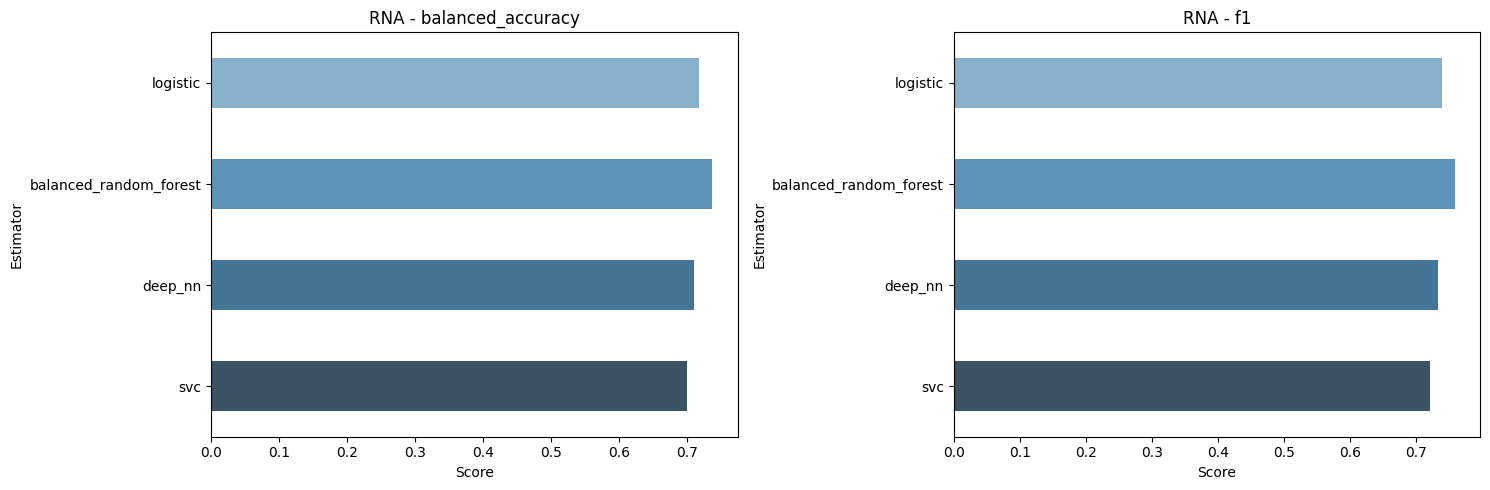

In [ ]:
plot_bar_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

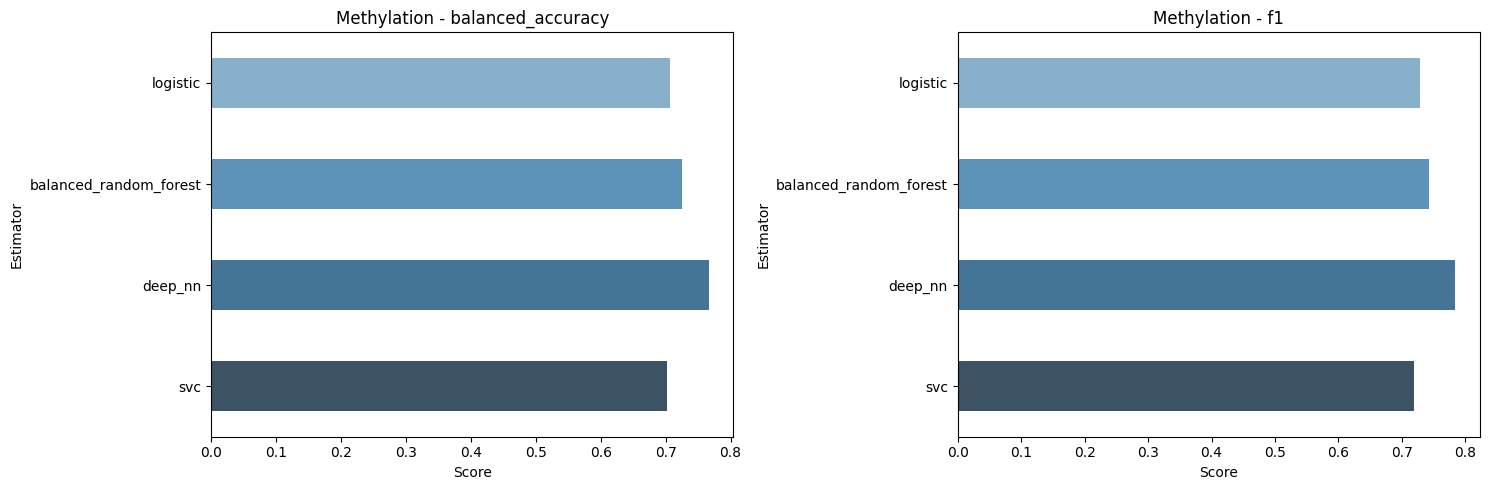

In [ ]:
plot_bar_scores(estimator_names, base_scores['meth'], 'Methylation', metrics=['balanced_accuracy', 'f1'])

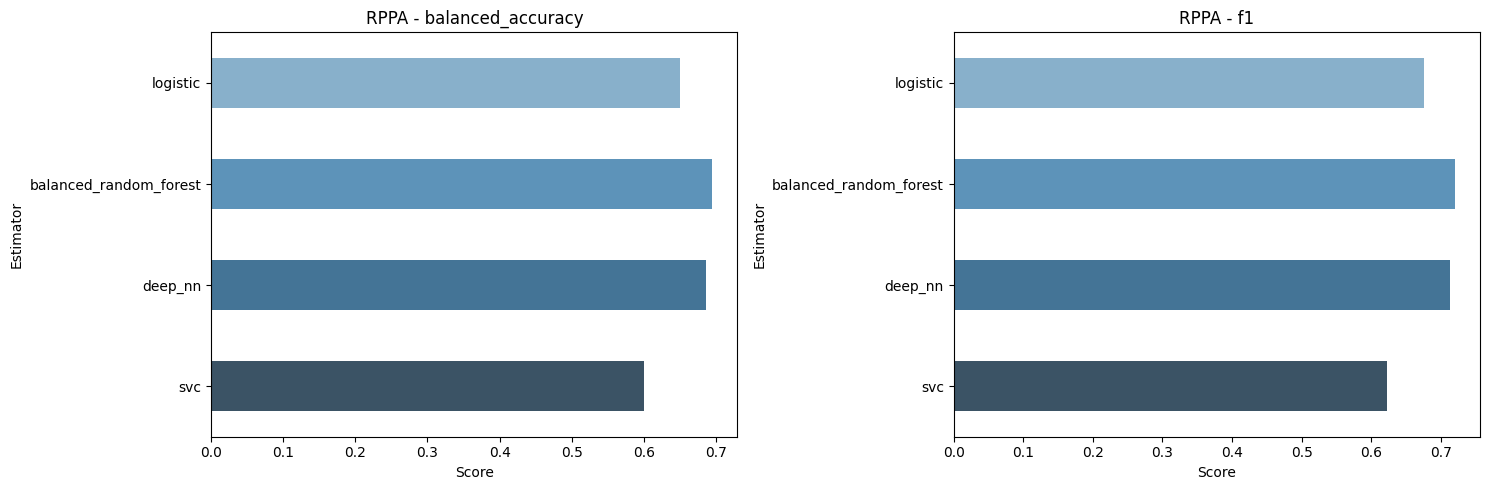

In [ ]:
plot_bar_scores(estimator_names, base_scores['rppa'], 'RPPA', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


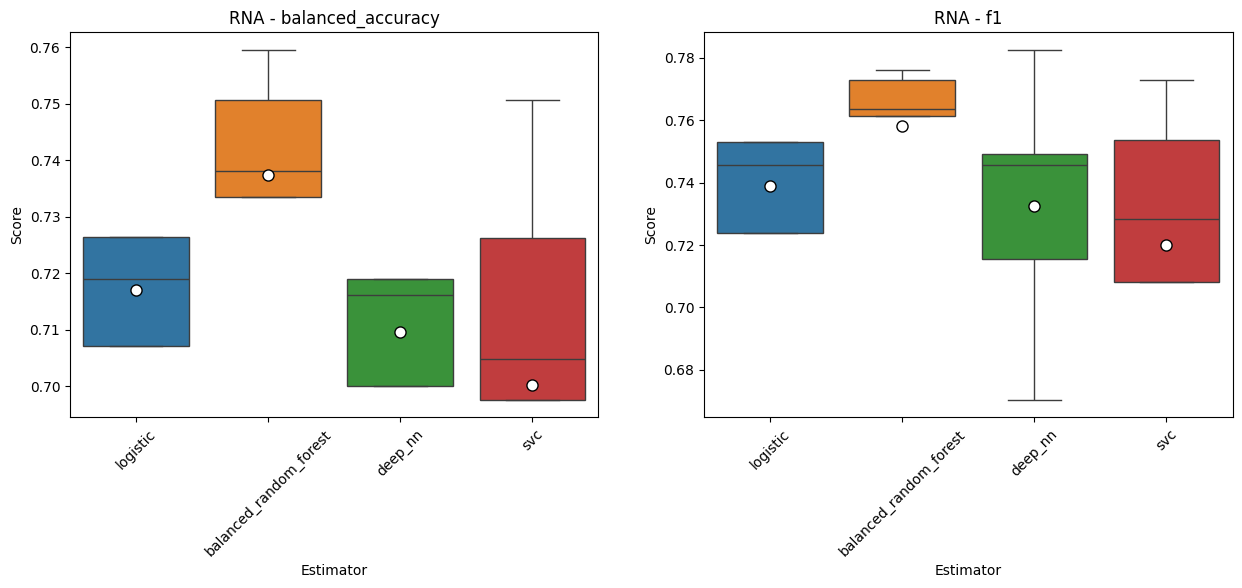

In [ ]:
plot_box_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


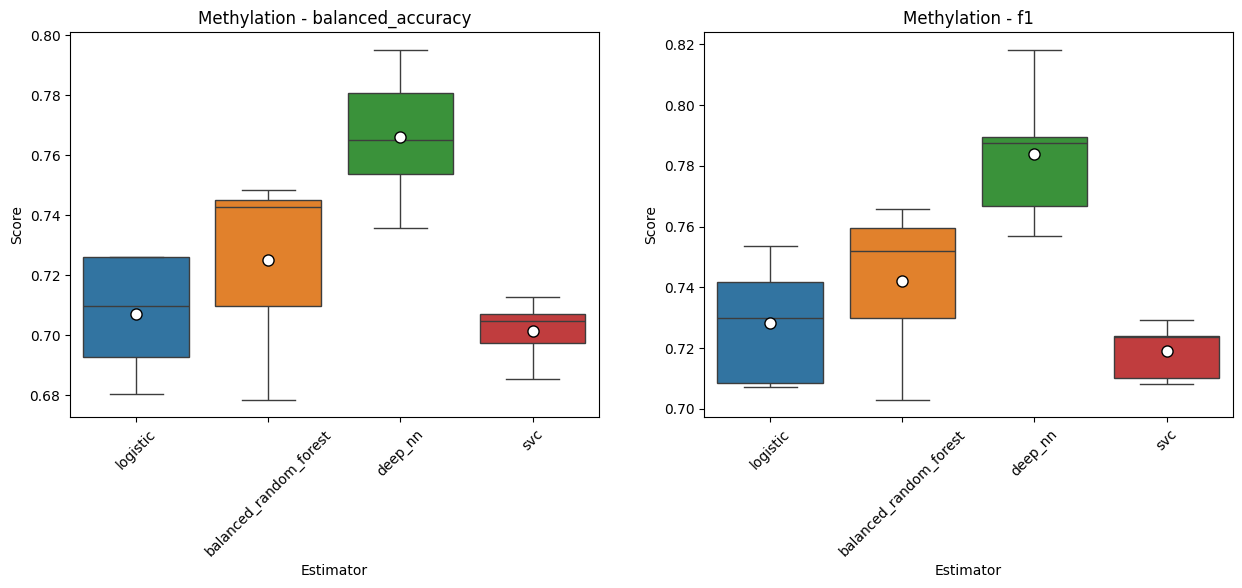

In [ ]:
plot_box_scores(estimator_names, base_scores['meth'], 'Methylation', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


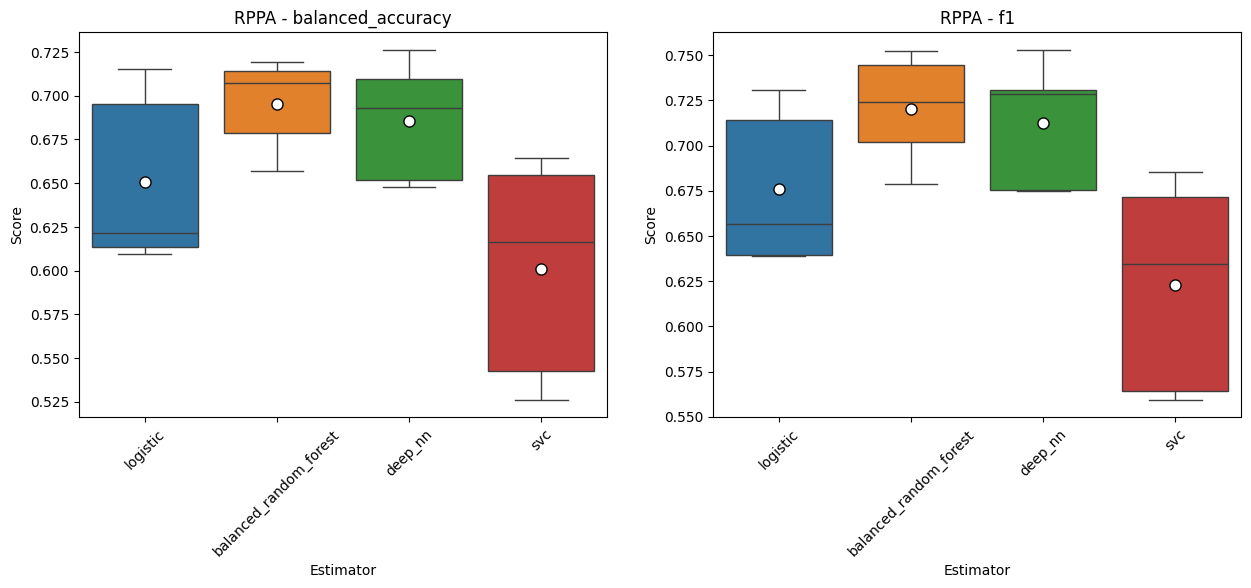

In [ ]:
plot_box_scores(estimator_names, base_scores['rppa'], 'RPPA', metrics=['balanced_accuracy', 'f1'])

## Modality Ensembles

In [ ]:
classifiers = {}

for modality in datasets:
    classifiers[modality] = ModalityPipeline(estimators, cv=3)

In [ ]:
modality_metrics = pd.DataFrame()
modality_scores = {}

for modality in tqdm(datasets):
    modality_scores[modality], df = get_cross_metrics(classifiers[modality], X[modality], y, modality, scoring=kipan_stage_scoring)
    modality_metrics = pd.concat([modality_metrics, df])

100%|██████████| 3/3 [01:35<00:00, 31.80s/it]


In [ ]:
modality_metrics

accuracy balanced_accuracy               f1   recall (early)  \
rna   0.749 +/- 0.043   0.715 +/- 0.041  0.744 +/- 0.042  0.849 +/- 0.053   
meth  0.763 +/- 0.018   0.737 +/- 0.021  0.760 +/- 0.019  0.840 +/- 0.032   
rppa  0.724 +/- 0.026   0.678 +/- 0.026  0.712 +/- 0.025  0.860 +/- 0.048   

        recall (late)  
rna   0.582 +/- 0.043  
meth  0.635 +/- 0.050  
rppa  0.496 +/- 0.058

In [ ]:
modality_metrics

accuracy balanced_accuracy               f1   recall (early)  \
rna   0.763 +/- 0.028   0.730 +/- 0.031  0.758 +/- 0.029  0.860 +/- 0.039   
meth  0.767 +/- 0.012   0.740 +/- 0.016  0.764 +/- 0.012  0.846 +/- 0.025   
rppa  0.737 +/- 0.021   0.688 +/- 0.020  0.724 +/- 0.021  0.880 +/- 0.037   

        recall (late)  
rna   0.601 +/- 0.060  
meth  0.634 +/- 0.044  
rppa  0.496 +/- 0.041

In [ ]:
# Convert and write JSON object to file
with open("results/kipan/staging/kipan_modality_results_3.json", "w") as outfile:
    json.dump(modality_scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)


In [ ]:
estimator_names = [
    "logistic",
    "balanced_random_forest",
    "deep_nn",
    "svc",
    "stacking"
]
all_scores = {}

for modality in base_scores:
    all_scores[modality] = {}
    for i in range(len(base_scores[modality])):
        all_scores[modality][estimator_names[i]] = base_scores[modality][i]

    all_scores[modality]['stacking'] = modality_scores[modality]


In [ ]:
# Convert and write JSON object to file
with open("results/kipan_base_learner_modality_results_3.json", "w") as outfile:
    json.dump(all_scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

In [ ]:
# Run this if continuing an already saved run:
with open("results/kipan/staging/kipan_modality_results_3.json",'r+') as file:
    modality_scores = json.load(file)
    modality_metrics = pd.DataFrame()

    for model in modality_scores:
      metrics = {}

      for scorer in kipan_stage_scoring:
        metrics[scorer] = []

      for scorer in kipan_stage_scoring:
          metrics[scorer].append(
              "%0.3f +/- %0.3f"
              % (np.mean(modality_scores[model]["test_%s" % scorer]), np.std(modality_scores[model]["test_%s" % scorer]))
      )
      modality_metrics = pd.concat([modality_metrics, pd.DataFrame(metrics, index=[model])])

### Scoring

In [ ]:
all_metrics = {}

for modality in datasets:
    all_metrics[modality] = pd.concat([base_metrics_df[modality], modality_metrics.loc[[modality]]])
    all_metrics[modality].rename_axis(index={modality: 'stacking'}, inplace=True)

In [ ]:
display(all_metrics['rna'], all_metrics['meth'], all_metrics['rppa'])

accuracy balanced_accuracy               f1  \
logistic                0.740 +/- 0.049   0.717 +/- 0.047  0.739 +/- 0.048   
balanced_random_forest  0.760 +/- 0.023   0.737 +/- 0.019  0.758 +/- 0.022   
deep_nn                 0.735 +/- 0.039   0.710 +/- 0.036  0.733 +/- 0.038   
svc                     0.721 +/- 0.049   0.700 +/- 0.043  0.720 +/- 0.047   
rna                     0.749 +/- 0.043   0.715 +/- 0.041  0.744 +/- 0.042   

                         recall (early)    recall (late)  
logistic                0.809 +/- 0.058  0.625 +/- 0.047  
balanced_random_forest  0.826 +/- 0.043  0.649 +/- 0.030  
deep_nn                 0.809 +/- 0.055  0.611 +/- 0.046  
svc                     0.780 +/- 0.070  0.620 +/- 0.037  
rna                     0.849 +/- 0.053  0.582 +/- 0.043

accuracy balanced_accuracy               f1  \
logistic                0.729 +/- 0.019   0.707 +/- 0.018  0.728 +/- 0.018   
balanced_random_forest  0.742 +/- 0.022   0.725 +/- 0.027  0.742 +/- 0.023   
deep_nn                 0.785 +/- 0.022   0.766 +/- 0.021  0.784 +/- 0.021   
svc                     0.719 +/- 0.009   0.702 +/- 0.009  0.719 +/- 0.008   
meth                    0.763 +/- 0.018   0.737 +/- 0.021  0.760 +/- 0.019   

                         recall (early)    recall (late)  
logistic                0.794 +/- 0.037  0.620 +/- 0.037  
balanced_random_forest  0.791 +/- 0.015  0.659 +/- 0.051  
deep_nn                 0.840 +/- 0.040  0.692 +/- 0.042  
svc                     0.769 +/- 0.031  0.635 +/- 0.038  
meth                    0.840 +/- 0.032  0.635 +/- 0.050

accuracy balanced_accuracy               f1  \
logistic                0.679 +/- 0.037   0.651 +/- 0.045  0.676 +/- 0.039   
balanced_random_forest  0.724 +/- 0.032   0.695 +/- 0.024  0.720 +/- 0.027   
deep_nn                 0.717 +/- 0.033   0.686 +/- 0.031  0.713 +/- 0.032   
svc                     0.624 +/- 0.050   0.601 +/- 0.057  0.623 +/- 0.053   
rppa                    0.724 +/- 0.026   0.678 +/- 0.026  0.712 +/- 0.025   

                         recall (early)    recall (late)  
logistic                0.763 +/- 0.033  0.539 +/- 0.087  
balanced_random_forest  0.809 +/- 0.066  0.582 +/- 0.048  
deep_nn                 0.809 +/- 0.051  0.563 +/- 0.047  
svc                     0.691 +/- 0.059  0.510 +/- 0.106  
rppa                    0.860 +/- 0.048  0.496 +/- 0.058

In [ ]:
display(all_metrics['rna'], all_metrics['meth'], all_metrics['rppa'])

accuracy balanced_accuracy               f1  \
logistic                0.733 +/- 0.043   0.709 +/- 0.040  0.731 +/- 0.041   
balanced_random_forest  0.737 +/- 0.014   0.716 +/- 0.019  0.735 +/- 0.014   
deep_nn                 0.738 +/- 0.022   0.710 +/- 0.029  0.735 +/- 0.024   
svc                     0.728 +/- 0.046   0.705 +/- 0.044  0.726 +/- 0.045   
rna                     0.763 +/- 0.028   0.730 +/- 0.031  0.758 +/- 0.029   

                         recall (early)    recall (late)  
logistic                0.803 +/- 0.053  0.616 +/- 0.041  
balanced_random_forest  0.797 +/- 0.050  0.635 +/- 0.077  
deep_nn                 0.820 +/- 0.017  0.601 +/- 0.061  
svc                     0.794 +/- 0.058  0.615 +/- 0.050  
rna                     0.860 +/- 0.039  0.601 +/- 0.060

accuracy balanced_accuracy               f1  \
logistic                0.738 +/- 0.019   0.713 +/- 0.021  0.736 +/- 0.018   
balanced_random_forest  0.758 +/- 0.017   0.745 +/- 0.026  0.758 +/- 0.019   
deep_nn                 0.769 +/- 0.015   0.745 +/- 0.021  0.767 +/- 0.016   
svc                     0.728 +/- 0.023   0.708 +/- 0.031  0.726 +/- 0.025   
meth                    0.767 +/- 0.012   0.740 +/- 0.016  0.764 +/- 0.012   

                         recall (early)    recall (late)  
logistic                0.811 +/- 0.038  0.615 +/- 0.055  
balanced_random_forest  0.797 +/- 0.025  0.692 +/- 0.066  
deep_nn                 0.837 +/- 0.019  0.653 +/- 0.047  
svc                     0.786 +/- 0.042  0.630 +/- 0.080  
meth                    0.846 +/- 0.025  0.634 +/- 0.044

accuracy balanced_accuracy               f1  \
logistic                0.681 +/- 0.037   0.650 +/- 0.044  0.677 +/- 0.039   
balanced_random_forest  0.681 +/- 0.031   0.654 +/- 0.021  0.678 +/- 0.025   
deep_nn                 0.728 +/- 0.032   0.692 +/- 0.026  0.722 +/- 0.029   
svc                     0.640 +/- 0.027   0.625 +/- 0.033  0.642 +/- 0.027   
rppa                    0.737 +/- 0.021   0.688 +/- 0.020  0.724 +/- 0.021   

                         recall (early)    recall (late)  
logistic                0.771 +/- 0.033  0.529 +/- 0.083  
balanced_random_forest  0.760 +/- 0.076  0.548 +/- 0.065  
deep_nn                 0.831 +/- 0.051  0.553 +/- 0.020  
svc                     0.683 +/- 0.051  0.567 +/- 0.083  
rppa                    0.880 +/- 0.037  0.496 +/- 0.041

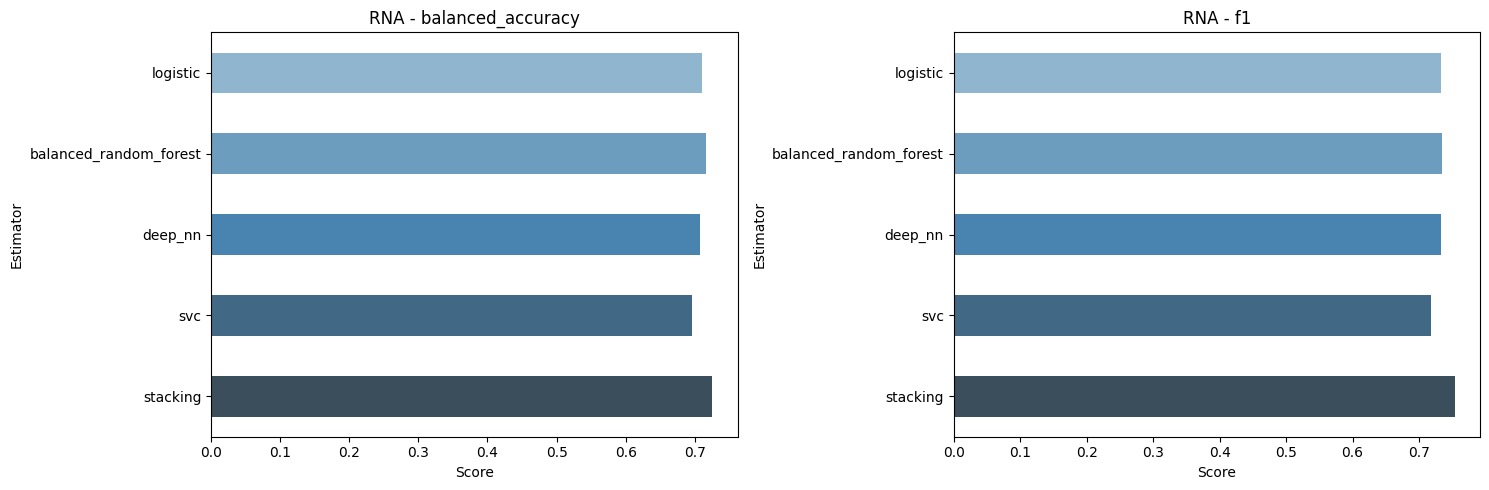

In [ ]:
plot_bar_scores(estimator_names, all_scores['rna'].values(), 'RNA', metrics=['balanced_accuracy', 'f1'])

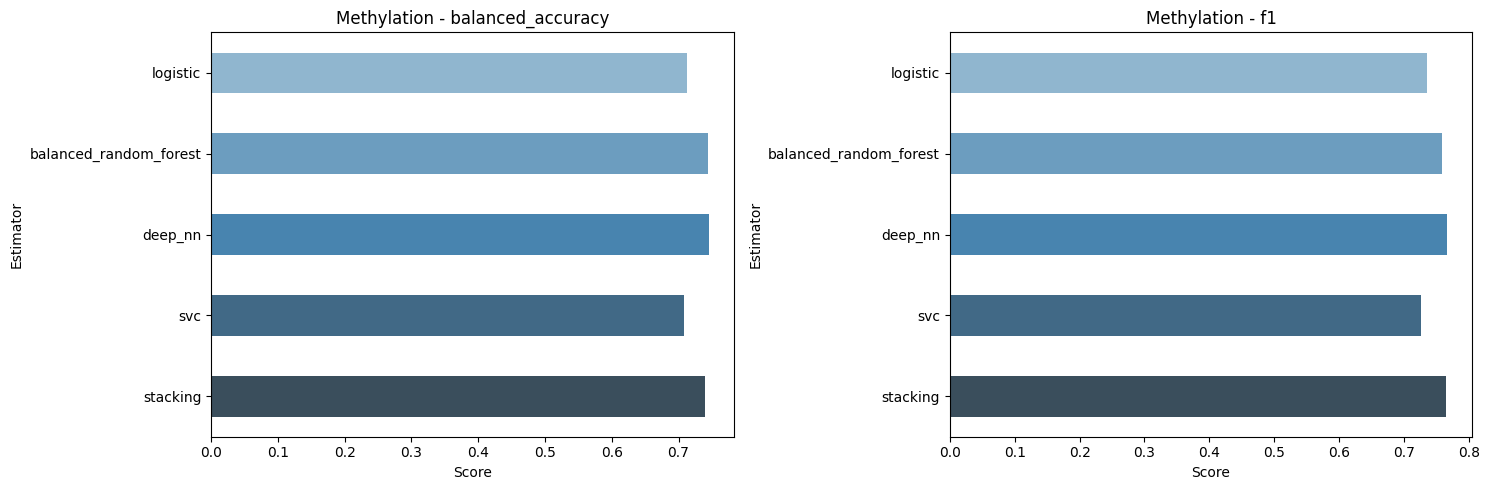

In [ ]:
plot_bar_scores(estimator_names, all_scores['meth'].values(), 'Methylation', metrics=['balanced_accuracy', 'f1'])

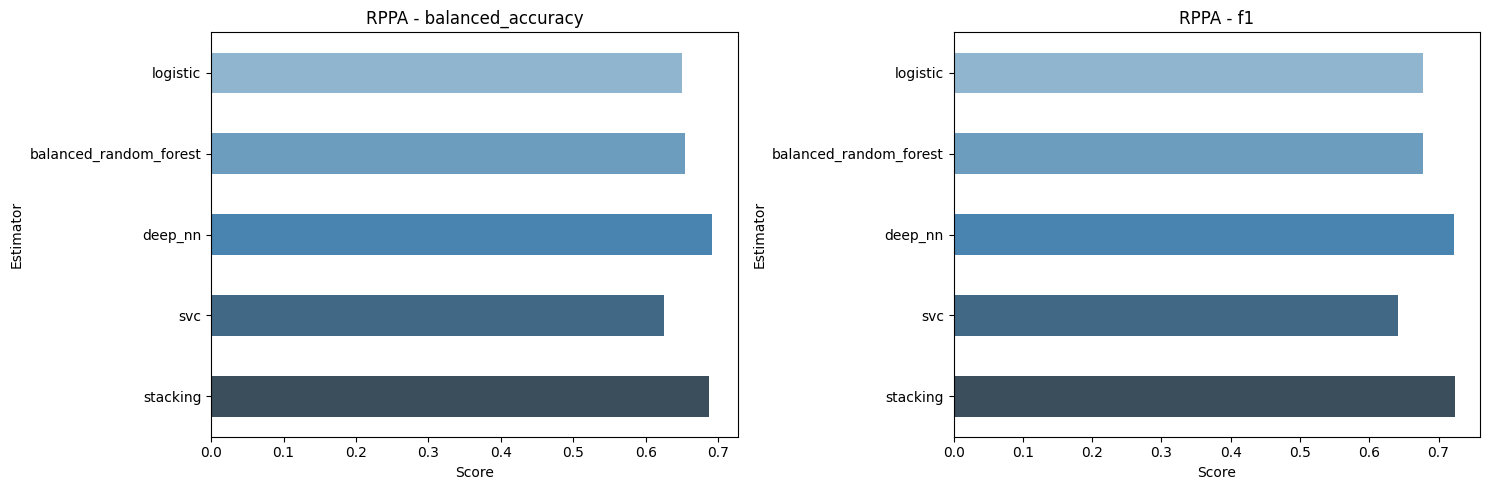

In [ ]:
plot_bar_scores(estimator_names, all_scores['rppa'].values(), 'RPPA', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


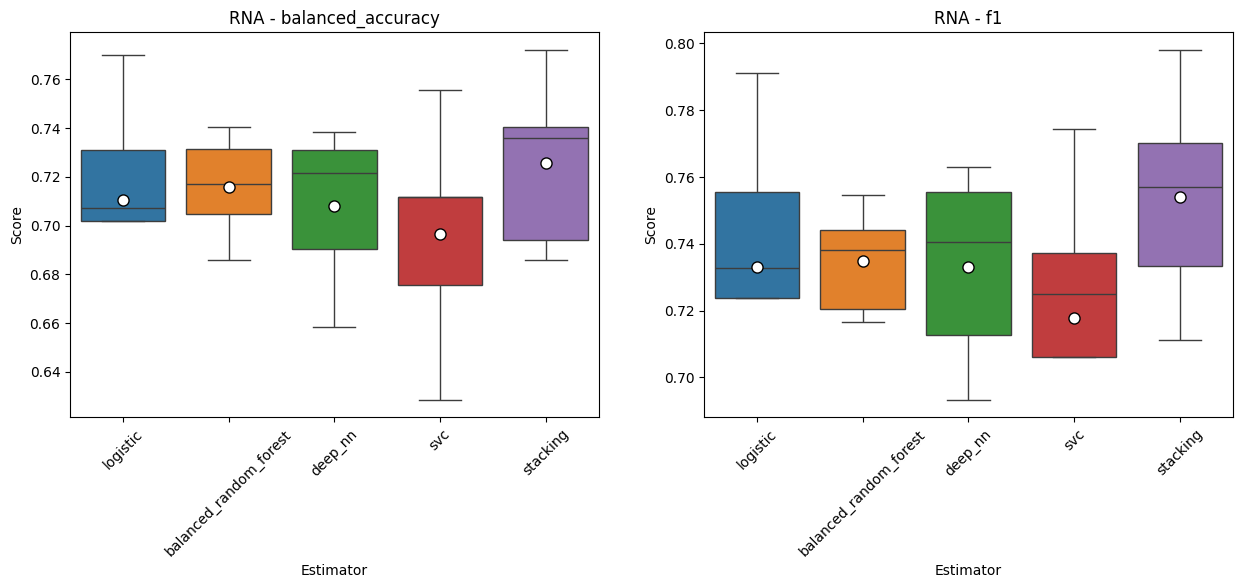

In [ ]:
plot_box_scores(estimator_names, all_scores['rna'].values(), 'RNA', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


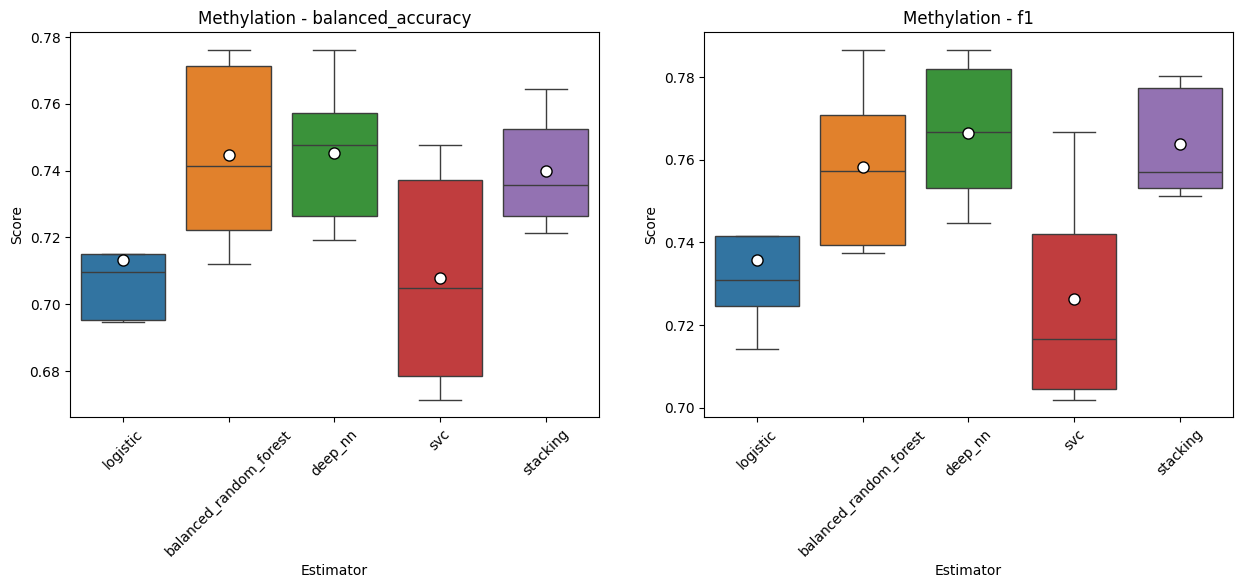

In [ ]:
plot_box_scores(estimator_names, all_scores['meth'].values(), 'Methylation', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


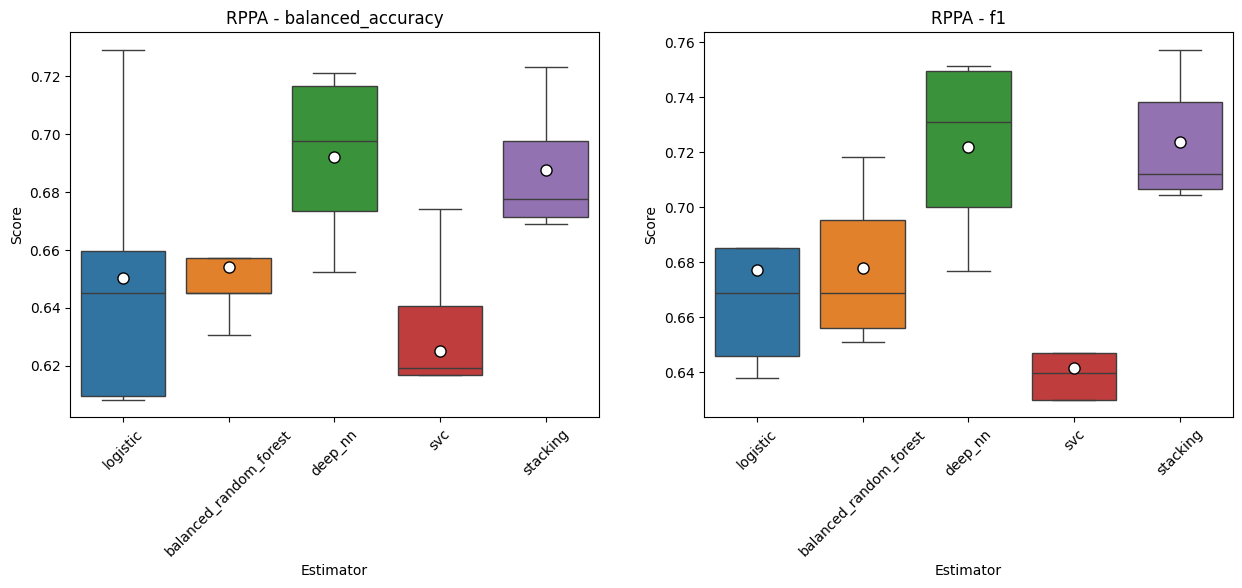

In [ ]:
plot_box_scores(estimator_names, all_scores['rppa'].values(), 'RPPA', metrics=['balanced_accuracy', 'f1'])

## Multi Omics Integration Ensemble

In [ ]:
column_names = {}

for key in X.keys():
    column_names[key] = X[key].columns

In [ ]:
meta_ensembles = {}
meta_ensembles['rna + meth + rppa'] = MultiOmicsIntegrationClassifier(classifiers, cv=3)
meta_ensembles['meth + rppa'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['meth', 'rppa']}, cv=3)
meta_ensembles['rna + meth'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['rna', 'meth']}, cv=3)
meta_ensembles['rna + rppa'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['rna', 'rppa']}, cv=3)

In [ ]:
X_merged = {}
X_merged['rna + meth + rppa'] = pd.concat([X['rna'], X['meth'], X['rppa']], axis=1, join='inner')
X_merged['meth + rppa'] = pd.concat([X['meth'], X['rppa']], axis=1, join='inner')
X_merged['rna + meth'] = pd.concat([X['rna'], X['meth']], axis=1, join='inner')
X_merged['rna + rppa'] = pd.concat([X['rna'], X['rppa']], axis=1, join='inner')


In [ ]:
integration_scores = {}
integration_metrics = {}

In [ ]:
# Run this if continuing an already saved run:
with open("results/kipan/staging/kipan_multi_omics_results_3.json",'r+') as file:
    integration_scores = json.load(file)
    integration_metrics = {}

    for model in integration_scores:
      metrics = {}

      for scorer in kipan_stage_scoring:
        metrics[scorer] = []

      for scorer in kipan_stage_scoring:
          metrics[scorer].append(
              "%0.3f +/- %0.3f"
              % (np.mean(integration_scores[model]["test_%s" % scorer]), np.std(integration_scores[model]["test_%s" % scorer]))
      )
      integration_metrics[model] = pd.DataFrame(metrics, index=[model])

In [ ]:
integration_scores['rna + meth + rppa'], integration_metrics['rna + meth + rppa'] = get_cross_metrics(meta_ensembles['rna + meth + rppa'], X_merged['rna + meth + rppa'], y, name='rna + meth + rppa', cv=5, verbose=2, scoring=kipan_stage_scoring, fit_params={'column_names': column_names})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.7min finished


In [ ]:
integration_scores['meth + rppa'], integration_metrics['meth + rppa'] = get_cross_metrics(meta_ensembles['meth + rppa'], X_merged['meth + rppa'], y, name='meth + rppa', cv=5, verbose=2, scoring=kipan_stage_scoring, fit_params={'column_names': {key: column_names[key] for key in ['meth', 'rppa']}})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.9min finished


In [ ]:
integration_scores['rna + rppa'], integration_metrics['rna + rppa'] = get_cross_metrics(meta_ensembles['rna + rppa'], X_merged['rna + rppa'], y, name='rna + rppa', cv=5, verbose=2, scoring=kipan_stage_scoring, fit_params={'column_names': {key: column_names[key] for key in ['rna', 'rppa']}})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished


In [ ]:
integration_scores['rna + meth'], integration_metrics['rna + meth'] = get_cross_metrics(meta_ensembles['rna + meth'], X_merged['rna + meth'], y, name='rna + meth', cv=5, verbose=2, scoring=kipan_stage_scoring, fit_params={'column_names': {key: column_names[key] for key in ['rna', 'meth']}})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished


In [ ]:
all_integration_metrics = pd.concat([modality_metrics, pd.concat([x for x in integration_metrics.values()])])
names = ['rna', 'meth', 'rppa', 'rna + meth + rppa', 'meth + rppa', 'rna + rppa', 'rna + meth']

all_integration_scores = modality_scores

# Adding multi-omic ensemble scores
for name, value in integration_scores.items():
    all_integration_scores[name] = value

In [ ]:
all_integration_metrics

accuracy balanced_accuracy               f1  \
rna                0.763 +/- 0.028   0.730 +/- 0.031  0.758 +/- 0.029   
meth               0.767 +/- 0.012   0.740 +/- 0.016  0.764 +/- 0.012   
rppa               0.737 +/- 0.021   0.688 +/- 0.020  0.724 +/- 0.021   
rna + meth + rppa  0.783 +/- 0.015   0.753 +/- 0.013  0.779 +/- 0.014   
meth + rppa        0.778 +/- 0.015   0.749 +/- 0.021  0.774 +/- 0.017   
rna + rppa         0.769 +/- 0.020   0.730 +/- 0.025  0.761 +/- 0.022   
rna + meth         0.783 +/- 0.011   0.755 +/- 0.016  0.779 +/- 0.011   

                    recall (early)    recall (late)  
rna                0.860 +/- 0.039  0.601 +/- 0.060  
meth               0.846 +/- 0.025  0.634 +/- 0.044  
rppa               0.880 +/- 0.037  0.496 +/- 0.041  
rna + meth + rppa  0.871 +/- 0.031  0.635 +/- 0.031  
meth + rppa        0.863 +/- 0.015  0.635 +/- 0.046  
rna + rppa         0.883 +/- 0.017  0.577 +/- 0.049  
rna + meth         0.866 +/- 0.026  0.644 +/- 0.048

In [ ]:
# Convert and write JSON object to file
with open("results/kipan/staging/kipan_multi_omics_results_3.json", "w") as outfile:
    json.dump(integration_scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)


In [ ]:
# Convert and write JSON object to file
with open("results/kipan/staging/kipan_modality_multi_omics_results_3.json", "w") as outfile:
    json.dump(all_integration_scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

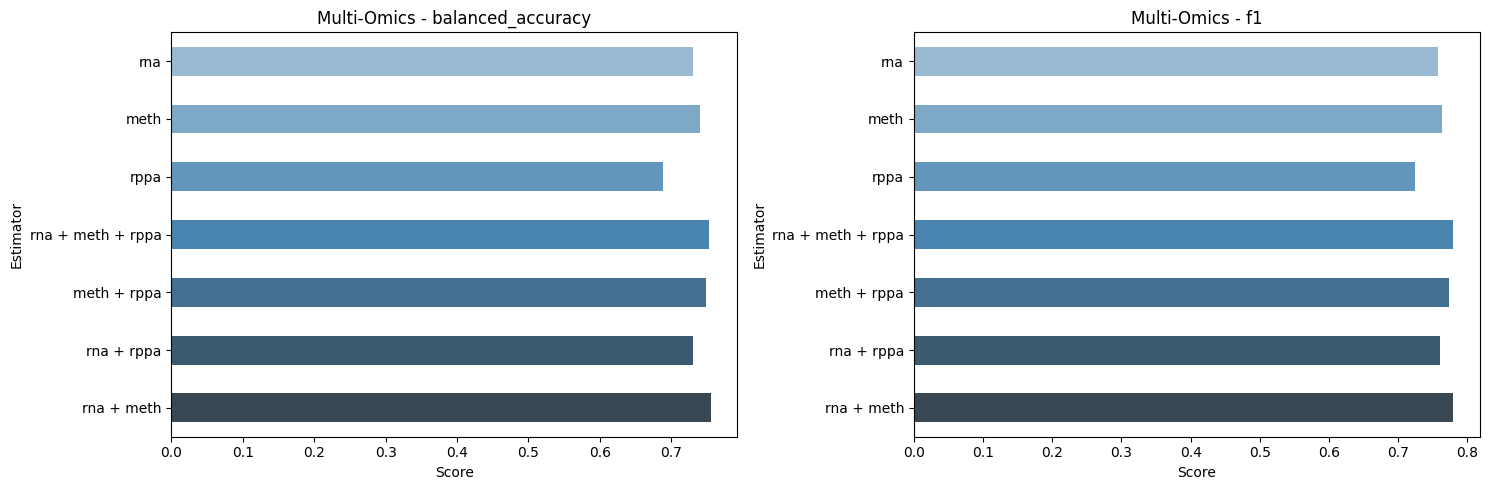

In [ ]:
plot_bar_scores(names, all_integration_scores.values(), 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


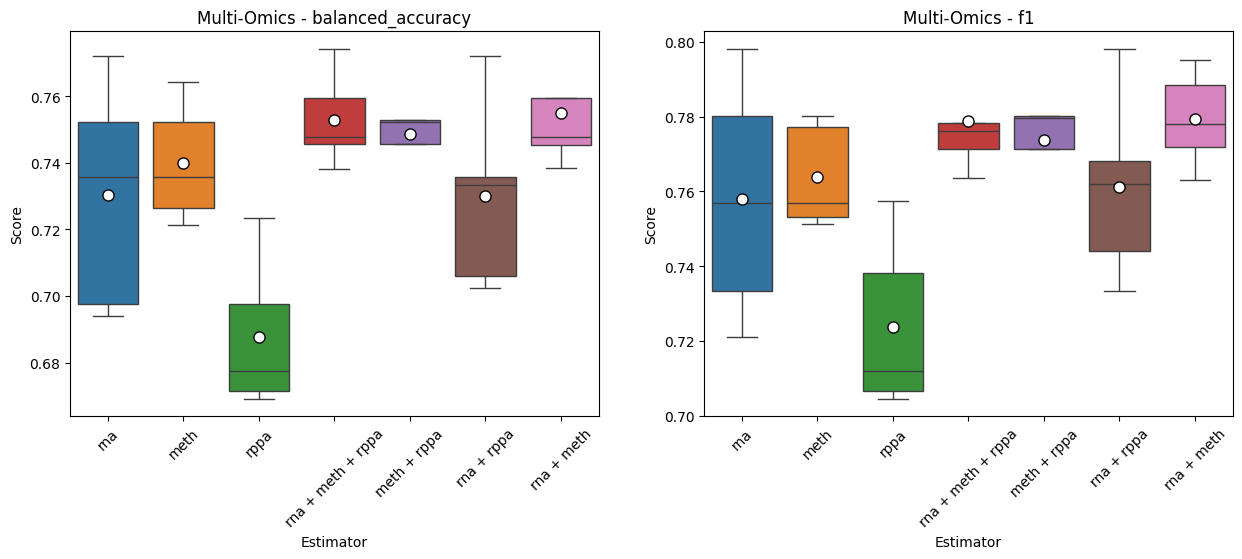

In [ ]:
plot_box_scores(names, all_integration_scores.values(), 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

## Statistical Significance

Now that we see the results, we want to check if the performance differences between our multi-omics ensemble models and the modality ensemble models are significant. We can employ the Wilcoxen test, using multiple replications of cross-validation to get scores.

### Wilcoxen

In [ ]:
ensemble_results = {}
ensemble_metrics = {}

In [ ]:
def wilcoxen_test(name_1, name_2, scores_1, scores_2):

    stat, p = wilcoxon(scores_1, scores_2, alternative='greater')

    df = pd.Series({'estimator_1': name_1, 'estimator_2': name_2, 'statistic': stat, 'p': p, 'significant': p <= 0.05})

    return pd.DataFrame(df).T

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
ensemble_results['meth + rppa'], ensemble_metrics['meth + rppa'] = get_cross_metrics(meta_ensembles['meth + rppa'], X_merged['meth + rppa'], y, name='meth + rppa', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_stage_scoring, fit_params={'column_names': {key: column_names[key] for key in ['meth', 'rppa']}})
ensemble_results['meth'], ensemble_metrics['meth'] = get_cross_metrics(classifiers['meth'], X['meth'], y, name='meth', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_stage_scoring)

In [ ]:
ensemble_results['rna + meth + rppa'], ensemble_metrics['rna + meth + rppa'] = get_cross_metrics(meta_ensembles['rna + meth + rppa'], X_merged['rna + meth + rppa'], y, name='rna + meth + rppa', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_stage_scoring, fit_params={'column_names': column_names})

In [ ]:
ensemble_results['rna + meth'], ensemble_metrics['rna + meth'] = get_cross_metrics(meta_ensembles['rna + meth'], X_merged['rna + meth'], y, name='rna + meth', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_stage_scoring, fit_params={'column_names': {key: column_names[key] for key in ['rna', 'meth']}})

In [ ]:
ensemble_results['rna + rppa'], ensemble_metrics['rna + rppa'] = get_cross_metrics(meta_ensembles['rna + rppa'], X_merged['rna + rppa'], y, name='rna + rppa', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_stage_scoring, fit_params={'column_names': {key: column_names[key] for key in ['rna', 'rppa']}})

In [ ]:
ensemble_results['rna'], ensemble_metrics['rna'] = get_cross_metrics(classifiers['rna'], X['rna'], y, name='rna', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_stage_scoring)

In [ ]:
# Picking models we want to compare performances for
compare = [
    ('rna + meth + rppa', 'meth'),
    ('rna + meth', 'meth'),
    ('meth + rppa', 'meth'),
    ('rna + rppa', 'rna')
]

In [ ]:
from scipy.stats import wilcoxon

wilcoxen_results = {}
metrics = ['balanced_accuracy', 'f1']

for metric in metrics:
    wilcoxen_results[metric] = pd.DataFrame()
    for est1, est2 in compare:
        df = wilcoxen_test(est1, est2, ensemble_results[est1]['test_' + metric], ensemble_results[est2]['test_' + metric])
        wilcoxen_results[metric] = pd.concat([wilcoxen_results[metric], df])


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [ ]:
display(wilcoxen_results['balanced_accuracy'], wilcoxen_results['f1'])

estimator_1 estimator_2 statistic         p significant
0  rna + meth + rppa        meth      98.0  0.015076        True
0         rna + meth        meth      83.5  0.103882       False
0        meth + rppa        meth      62.5  0.264978       False
0         rna + rppa         rna      74.0  0.227142       False

estimator_1 estimator_2 statistic         p significant
0  rna + meth + rppa        meth      99.0  0.012787        True
0         rna + meth        meth      87.0  0.067688       False
0        meth + rppa        meth      62.0  0.275462       False
0         rna + rppa         rna      83.0  0.103882       False

In [ ]:
display(wilcoxen_results['balanced_accuracy'], wilcoxen_results['f1'])

estimator_1 estimator_2 statistic         p significant
0  rna + meth + rppa        meth     110.5  0.001312        True
0         rna + meth        meth      78.0  0.165131       False
0        meth + rppa        meth      54.5  0.450018       False

estimator_1 estimator_2 statistic         p significant
0  rna + meth + rppa        meth     114.0  0.000427        True
0         rna + meth        meth      86.0  0.075714       False
0        meth + rppa        meth      66.0  0.198363       False

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


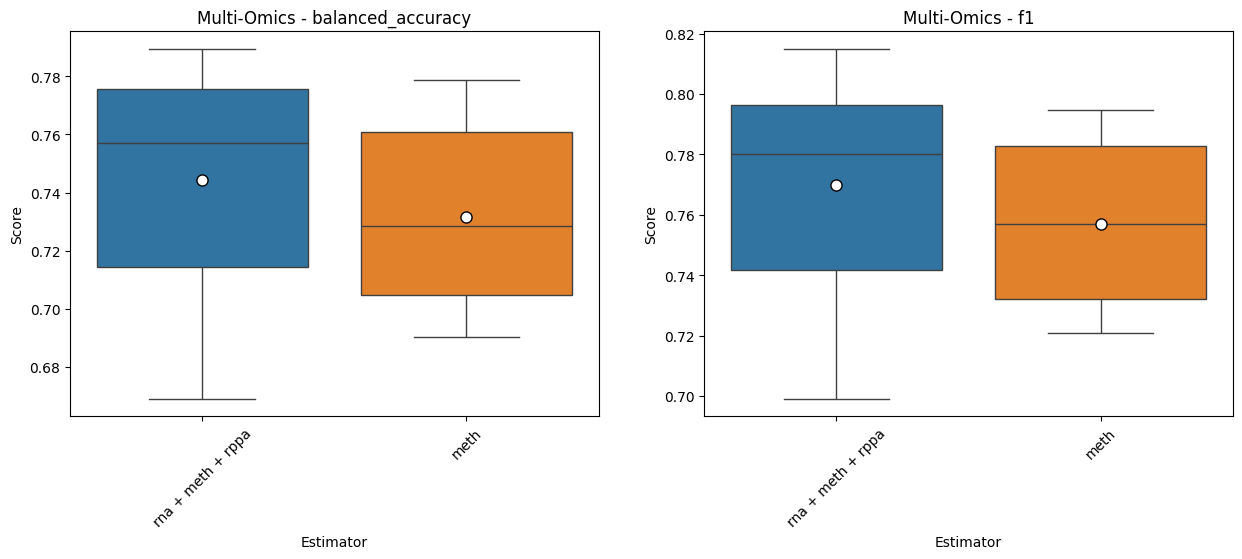

In [ ]:
plot_box_scores(['rna + meth + rppa', 'meth'], [ensemble_results['rna + meth + rppa'], ensemble_results['meth']], 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


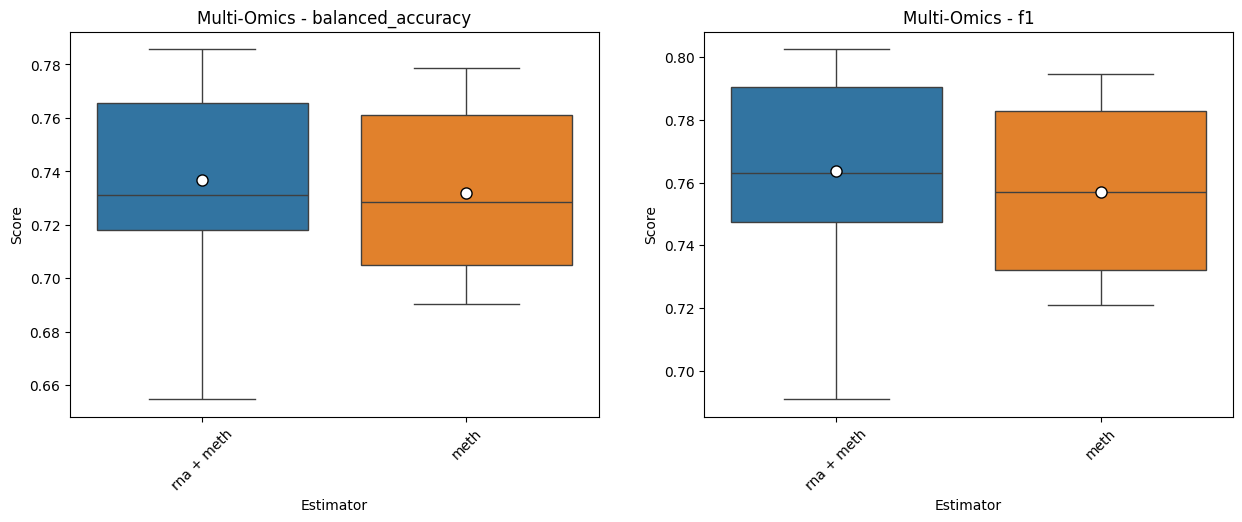

In [ ]:
plot_box_scores(['rna + meth', 'meth'], [ensemble_results['rna + meth'], ensemble_results['meth']], 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


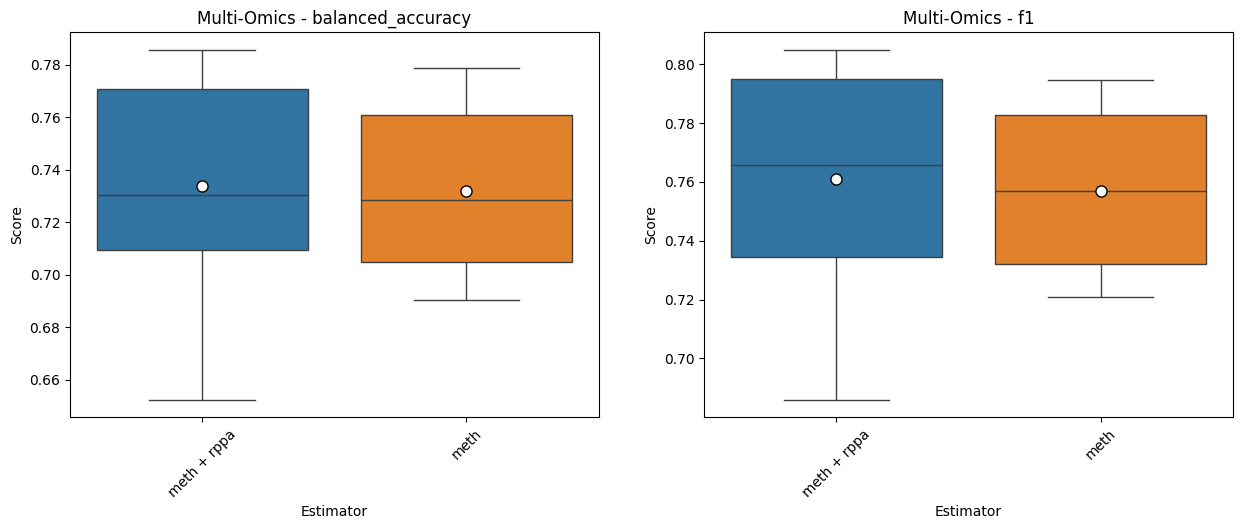

In [ ]:
plot_box_scores(['meth + rppa', 'meth'], [ensemble_results['meth + rppa'], ensemble_results['meth']], 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


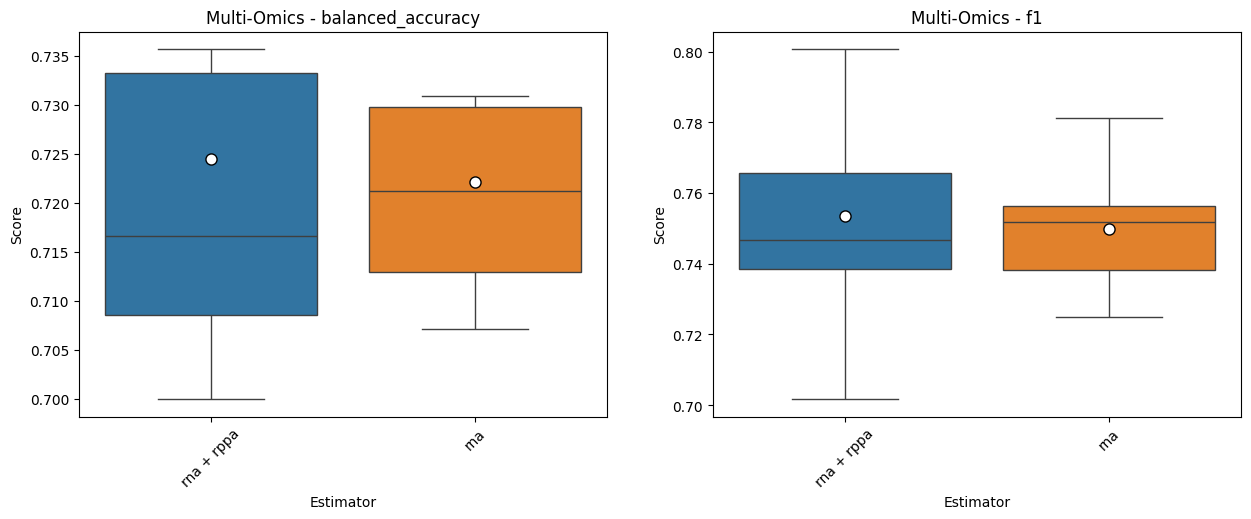

In [ ]:
plot_box_scores(['rna + rppa', 'rna'], [ensemble_results['rna + rppa'], ensemble_results['rna']], 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

In [ ]:
# Convert and write JSON object to file
with open("results/kipan/staging/kipan_5x3_results_3.json", "w") as outfile:
    json.dump(ensemble_results, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

## Feature Importance

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

In [ ]:
# Splitting into training, validation
#X_train, X_test, y_train, y_test = train_test_split(X['rna'], y, random_state=0, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_new_2, y, random_state=0, stratify=y)
#X_train, X_test, y_train, y_test = train_test_split(X_merged['rna + meth + rppa'], y, random_state=0, stratify=y)

In [ ]:
# Fitting on training data
#meta_ensembles['rna + meth + rppa'].fit(X_train, y_train, column_names)
classifiers['rna'].fit(X_train, y_train)

ModalityPipeline(cv=3,
                 estimator_list=[('logistic',
                                  Pipeline(steps=[('standardscaler',
                                                   StandardScaler()),
                                                  ('logisticregression',
                                                   LogisticRegression(max_iter=1000,
                                                                      n_jobs=-1,
                                                                      random_state=0))])),
                                 ('balanced_random_forest',
                                  BalancedRandomForestClassifier(n_jobs=-1,
                                                                 random_state=0,
                                                                 replacement=True,
                                                                 sampling_strategy='all')),
                                 ('deep_nn',
                                  Pipeline(steps=[('standardscaler',
                                                   StandardScaler()),
                                                  ('mlpclassifier',
                                                   MLPClassifier(random_state=0))])),
                                 ('svc',
                                  Pipeline(steps=[('standardscaler',
                                                   StandardScaler()),
                                                  ('svc',
                                                   SVC(kernel='linear',
                                                       max_iter=1000,
                                                       random_state=0))]))])

In [ ]:
# Getting baseline scores
baseline_scores = {}
for name, scorer in kipan_stage_scoring.items():
  #y_preds = meta_ensembles['rna + rppa'].predict(X_test)
  baseline_scores[name] = get_scorer(scorer)(classifiers['rna'], X_test, y_test)

In [ ]:
pd.DataFrame(baseline_scores, index=[""])

accuracy  balanced_accuracy        f1  recall (early)  recall (late)
  0.771429           0.731643  0.763817        0.886364       0.576923

In [ ]:
pd.DataFrame(baseline_scores, index=[""])

accuracy  balanced_accuracy        f1  recall (early)  recall (late)
  0.792857            0.76049  0.788084        0.886364       0.634615

In [ ]:
pd.DataFrame(baseline_scores, index=[""])

accuracy  balanced_accuracy        f1  recall (early)  recall (late)
      0.75           0.710664  0.742568        0.863636       0.557692

In [ ]:
result = permutation_importance(classifiers['rna'], X_test, y_test, n_repeats=3, random_state=0, scoring=kipan_stage_scoring, n_jobs=-1)
#result = permutation_importance(meta_ensembles['rna + meth + rppa'], X_test, y_test, n_repeats=5, random_state=0, scoring=kipan_stage_scoring, n_jobs=-1)

In [ ]:
sorted_importances_idx = result['balanced_accuracy'].importances_mean.argsort()
importances = pd.DataFrame(
    result['balanced_accuracy'].importances[sorted_importances_idx].T,
    #columns=X_merged['rna + meth + rppa'].columns[sorted_importances_idx],
    columns=X_new_2.columns[sorted_importances_idx],
)

importances.head()

CHRDL1_rna  LAD1_rna  FOSB_rna  CPLX1_rna  LUZP2_rna  CELA3A_rna  \
0   -0.009615 -0.011364 -0.024913  -0.019231   0.000000   -0.009615   
1   -0.015297 -0.005682  0.009615  -0.005682  -0.019231    0.000000   
2    0.000000 -0.005682 -0.005682   0.003934   0.000000   -0.009615   

   GSTM3_rna  C17orf77_rna  GABRA3_rna  SLITRK6_rna  ...  HAO2_rna  PAX9_rna  \
0   0.000000     -0.005682   -0.005682     0.003934  ...  0.019231  0.028846   
1  -0.009615     -0.005682   -0.005682    -0.005682  ...  0.019231  0.019231   
2  -0.009615     -0.005682   -0.005682    -0.015297  ...  0.019231  0.009615   

   SILV_rna  UGT1A10_rna  NUPR1_rna  FAT2_rna  SEMA4A_rna  GPNMB_rna  \
0  0.028846     0.019231   0.009615  0.019231    0.019231   0.028846   
1  0.015297     0.024913   0.028846  0.019231    0.019231   0.003934   
2  0.015297     0.015297   0.028846  0.028846    0.028846   0.040210   

   MOCS1_rna  ANXA10_rna  
0   0.028846    0.032780  
1   0.019231    0.034528  
2   0.028846    0.023164  

[3 rows x 677 columns]

In [ ]:
importances.iloc[:, -20:].columns

Index(['GSTM5_rna', 'C8orf84_rna', 'FGA_rna', 'NR0B1_rna', 'PLG_rna',
       'CCL21_rna', 'BCAN_rna', 'CHRDL1_rna', 'TLX3_rna', 'XDH_rna',
       'UCA1_rna', 'NEFM_rna', 'CRABP2_rna', 'ACAN_rna', 'SLC22A7_rna',
       'SLC6A19_rna', 'EYA1_rna', 'SLC6A15_rna', 'HIST1H2BM_rna', 'GRM3_rna'],
      dtype='object')

In [ ]:
importances.iloc[:, -20:].columns

Index(['HABP2_rna', 'CRABP2_rna', 'HRG_rna', 'MXRA5_rna', 'FGA_rna', 'H19_rna',
       'LGALS4_rna', 'MT3_rna', 'PTK6_rna', 'MMP2_rna', 'GRM3_rna', 'ACAN_rna',
       'SLC6A15_rna', 'LOC100132354_rna', 'FABP4_rna', 'C10orf81_rna',
       'UGT1A10_rna', 'EYA1_rna', 'BCAN_rna', 'PLG_rna'],
      dtype='object')

In [ ]:
importances.iloc[:, -20:].columns

Index(['SLCO6A1_rna', 'TUBA3D_rna', 'ANK2_rna', 'SEPT3_rna', 'C10orf81_rna',
       'DNER_rna', 'PLEKHH2_rna', 'CASQ1_rna', 'CATSPERG_rna', 'OR4A47_rna',
       'HAO2_rna', 'PAX9_rna', 'SILV_rna', 'UGT1A10_rna', 'NUPR1_rna',
       'FAT2_rna', 'SEMA4A_rna', 'GPNMB_rna', 'MOCS1_rna', 'ANXA10_rna'],
      dtype='object')

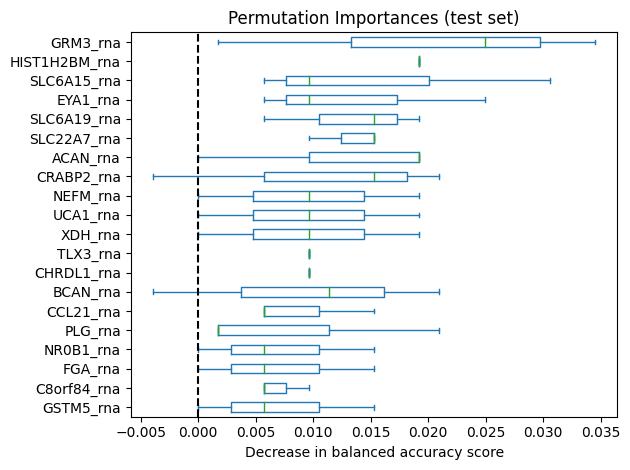

In [ ]:
# Printing top 20 important features
ax = importances.iloc[:, -20:].plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in balanced accuracy score")
ax.figure.tight_layout()

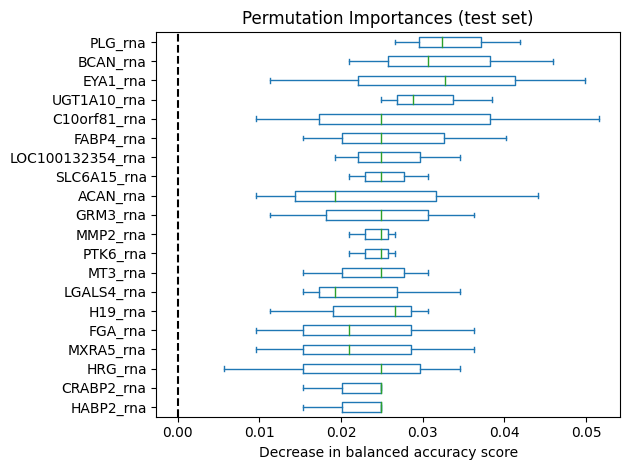

In [ ]:
# Printing top 20 important features
ax = importances.iloc[:, -20:].plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in balanced accuracy score")
ax.figure.tight_layout()

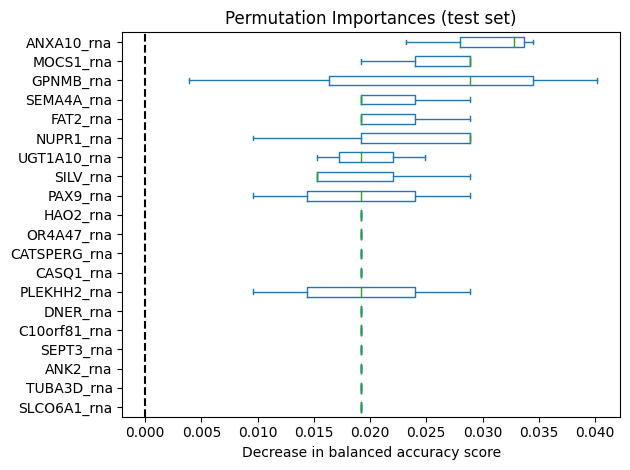

In [ ]:
# Printing top 20 important features
ax = importances.iloc[:, -20:].plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in balanced accuracy score")
ax.figure.tight_layout()

In [ ]:
top_genes = []

for i in result['balanced_accuracy'].importances_mean.argsort()[::-1]:
     if result['balanced_accuracy'].importances_mean[i] > 0:
        top_genes.append(X['rna'].columns[i])
        print(f"{X['rna'].columns[i]:<8}  "
               f"{result['balanced_accuracy'].importances_mean[i]:.3f}"
               f" +/- {result['balanced_accuracy'].importances_std[i]:.3f}")
        '''top_genes.append(X_merged['rna + meth + rppa'].columns[i])
        print(f"{X_merged['rna + meth + rppa'].columns[i]:<8}  "
               f"{result['balanced_accuracy'].importances_mean[i]:.3f}"
               f" +/- {result['balanced_accuracy'].importances_std[i]:.3f}")'''

GRM3_rna  0.020 +/- 0.014
HIST1H2BM_rna  0.019 +/- 0.000
SLC6A15_rna  0.015 +/- 0.011
EYA1_rna  0.013 +/- 0.008
SLC6A19_rna  0.013 +/- 0.006
SLC22A7_rna  0.013 +/- 0.003
ACAN_rna  0.013 +/- 0.009
CRABP2_rna  0.011 +/- 0.011
NEFM_rna  0.010 +/- 0.008
UCA1_rna  0.010 +/- 0.008
XDH_rna   0.010 +/- 0.008
TLX3_rna  0.010 +/- 0.000
CHRDL1_rna  0.010 +/- 0.000
BCAN_rna  0.009 +/- 0.010
CCL21_rna  0.009 +/- 0.005
PLG_rna   0.008 +/- 0.009
NR0B1_rna  0.007 +/- 0.006
FGA_rna   0.007 +/- 0.006
C8orf84_rna  0.007 +/- 0.002
GSTM5_rna  0.007 +/- 0.006
MSC_rna   0.007 +/- 0.006
UMOD_rna  0.006 +/- 0.009
SLC13A2_rna  0.006 +/- 0.005
COL12A1_rna  0.006 +/- 0.005
LOC400940_rna  0.006 +/- 0.005
TMEM45A_rna  0.006 +/- 0.005
HRG_rna   0.006 +/- 0.005
CXCL13_rna  0.006 +/- 0.005
DAZL_rna  0.006 +/- 0.005
LGALS4_rna  0.006 +/- 0.005
CTAG1B_rna  0.006 +/- 0.005
HABP2_rna  0.006 +/- 0.005
COL11A1_rna  0.006 +/- 0.005
SLC1A6_rna  0.006 +/- 0.005
GBP1_rna  0.006 +/- 0.005
VWA3A_rna  0.006 +/- 0.005
PRSS54_rna  0

In [ ]:
top_genes = []

for i in result['balanced_accuracy'].importances_mean.argsort()[::-1]:
     if result['balanced_accuracy'].importances_mean[i] > 0:
        top_genes.append(X_new['rna'].columns[i])
        print(f"{X_new['rna'].columns[i]:<8}  "
               f"{result['balanced_accuracy'].importances_mean[i]:.3f}"
               f" +/- {result['balanced_accuracy'].importances_std[i]:.3f}")
        '''top_genes.append(X_merged['rna + meth + rppa'].columns[i])
        print(f"{X_merged['rna + meth + rppa'].columns[i]:<8}  "
               f"{result['balanced_accuracy'].importances_mean[i]:.3f}"
               f" +/- {result['balanced_accuracy'].importances_std[i]:.3f}")'''

PLG_rna   0.034 +/- 0.006
BCAN_rna  0.032 +/- 0.010
EYA1_rna  0.031 +/- 0.016
UGT1A10_rna  0.031 +/- 0.006
C10orf81_rna  0.029 +/- 0.017
FABP4_rna  0.027 +/- 0.010
LOC100132354_rna  0.026 +/- 0.006
SLC6A15_rna  0.025 +/- 0.004
ACAN_rna  0.024 +/- 0.015
GRM3_rna  0.024 +/- 0.010
MMP2_rna  0.024 +/- 0.002
PTK6_rna  0.024 +/- 0.002
MT3_rna   0.024 +/- 0.006
LGALS4_rna  0.023 +/- 0.008
H19_rna   0.023 +/- 0.008
FGA_rna   0.022 +/- 0.011
MXRA5_rna  0.022 +/- 0.011
HRG_rna   0.022 +/- 0.012
CRABP2_rna  0.022 +/- 0.005
HABP2_rna  0.022 +/- 0.005
KLF5_rna  0.021 +/- 0.010
SLC22A7_rna  0.020 +/- 0.021
LEFTY2_rna  0.020 +/- 0.004
CTRB1_rna  0.020 +/- 0.007
MAP2_rna  0.019 +/- 0.007
CTAG1B_rna  0.019 +/- 0.000
LUZP2_rna  0.019 +/- 0.000
TNFSF12-TNFSF13_rna  0.019 +/- 0.009
NCAM1_rna  0.019 +/- 0.009
SNCB_rna  0.019 +/- 0.005
FAM40B_rna  0.019 +/- 0.009
S100A4_rna  0.019 +/- 0.002
ISG15_rna  0.018 +/- 0.013
SCNN1G_rna  0.018 +/- 0.002
CXCL13_rna  0.018 +/- 0.002
CHRDL1_rna  0.018 +/- 0.005
SLC6A18

In [ ]:
top_genes = []

for i in result['balanced_accuracy'].importances_mean.argsort()[::-1]:
     if result['balanced_accuracy'].importances_mean[i] > 0:
        top_genes.append(X_new['rna'].columns[i])
        print(f"{X_new['rna'].columns[i]:<8}  "
               f"{result['balanced_accuracy'].importances_mean[i]:.3f}"
               f" +/- {result['balanced_accuracy'].importances_std[i]:.3f}")
        '''top_genes.append(X_merged['rna + meth + rppa'].columns[i])
        print(f"{X_merged['rna + meth + rppa'].columns[i]:<8}  "
               f"{result['balanced_accuracy'].importances_mean[i]:.3f}"
               f" +/- {result['balanced_accuracy'].importances_std[i]:.3f}")'''

ANKRD34B_rna  0.030 +/- 0.005
KLF5_rna  0.026 +/- 0.005
FGFR3_rna  0.024 +/- 0.015
OLAH_rna  0.022 +/- 0.005
DUSP5_rna  0.022 +/- 0.005
LGI3_rna  0.022 +/- 0.009
RARRES1_rna  0.020 +/- 0.004
OSGIN1_rna  0.020 +/- 0.006
MAGEC2_rna  0.019 +/- 0.008
FZD7_rna  0.019 +/- 0.000
LOC100188947_rna  0.019 +/- 0.000
CAPN3_rna  0.019 +/- 0.000
CAPN13_rna  0.019 +/- 0.000
MMP11_rna  0.019 +/- 0.008
CYP26A1_rna  0.019 +/- 0.000
BLID_rna  0.019 +/- 0.000
OR11G2_rna  0.019 +/- 0.000
AMBP_rna  0.019 +/- 0.000
R3HDML_rna  0.019 +/- 0.000
PCOLCE_rna  0.019 +/- 0.000
FAM20A_rna  0.019 +/- 0.000
IGFL1_rna  0.019 +/- 0.006
CFHR2_rna  0.019 +/- 0.004
LCN15_rna  0.018 +/- 0.006
GPR149_rna  0.017 +/- 0.003
LGR5_rna  0.017 +/- 0.003
CHGA_rna  0.017 +/- 0.003
CACNG7_rna  0.017 +/- 0.003
BDKRB2_rna  0.017 +/- 0.009
C6orf126_rna  0.017 +/- 0.013
IL6_rna   0.017 +/- 0.013
G6PC_rna  0.017 +/- 0.010
COL1A1_rna  0.017 +/- 0.006
MMP12_rna  0.017 +/- 0.010
NET1_rna  0.016 +/- 0.005
NID2_rna  0.016 +/- 0.005
LCN1_rna  0.

In [ ]:
top_genes_modality = {}

for modality in datasets:
  top_genes_modality[modality] = []

for gene in top_genes:
  for modality in datasets:
    if ("_" + modality) in gene:
      top_genes_modality[modality].append(gene.removesuffix('_'+modality))
      break

In [ ]:
# Printing to copy-paste into top-gene for enrichment analysis
for modality in top_genes_modality:
  print(f"{modality}: " + ','.join(top_genes_modality[modality]))
  print("")

rna: GRM3,HIST1H2BM,SLC6A15,EYA1,SLC6A19,SLC22A7,ACAN,CRABP2,NEFM,UCA1,XDH,TLX3,CHRDL1,BCAN,CCL21,PLG,NR0B1,FGA,C8orf84,GSTM5,MSC,UMOD,SLC13A2,COL12A1,LOC400940,TMEM45A,HRG,CXCL13,DAZL,LGALS4,CTAG1B,HABP2,COL11A1,SLC1A6,GBP1,VWA3A,PRSS54,LHX9,AQP10,CRABP1,HBG1,SLC22A8,BMPR1B,C10orf81,PDPN,ADCYAP1,CHGA,FGB,WBSCR17,UNC93B1,VIPR1,CFHR2,TM4SF4,SGCZ,REG3A,C12orf59,FRZB,CLCA4,RPL39,SHISA3,GJB6,COL5A1,CPA4,COL1A1,OR7E156P,NR4A2,SFN,KLF5,PAH,WNK2,PLAT,AQP2,LAMC2,LGI4,LAD1,DNAH8,VGF,ISLR,LOC283867,RAPGEFL1,TNFSF12-TNFSF13,EMILIN1,KIF1A,ANKRD34B,NET1,KERA,G0S2,KLK6,MIOX,CKMT2,CAMK1G,AMBP,SPACA3,GRIA2,SERPINB4,ALDOB,CPN2,ECEL1,VSTM2A,NUPR1,GPR110,MT3,GPC3,NCAM1,SLC7A7,IVL,MYO16,SLC6A18,PLA1A,FXYD4,OR11G2,CAPS,FAM101A,CTSE,ATP6V1C2,STEAP3,FAM40B,RDH8,LOC100132354,HTR3A,REN,PTPRO,TAS2R1,MAP7D2,RPLP0P2,C4orf7,TMPRSS11F,CHST2,IL1A,CD70

meth: 

rppa: 



In [ ]:
# Printing to copy-paste into kmplot for survival analysis
for modality in top_genes_modality:
  print(f"{modality}:")
  for gene in top_genes_modality[modality]:
    print(gene)
  print("")

rna:
GRM3
HIST1H2BM
SLC6A15
EYA1
SLC6A19
SLC22A7
ACAN
CRABP2
NEFM
UCA1
XDH
TLX3
CHRDL1
BCAN
CCL21
PLG
NR0B1
FGA
C8orf84
GSTM5
MSC
UMOD
SLC13A2
COL12A1
LOC400940
TMEM45A
HRG
CXCL13
DAZL
LGALS4
CTAG1B
HABP2
COL11A1
SLC1A6
GBP1
VWA3A
PRSS54
LHX9
AQP10
CRABP1
HBG1
SLC22A8
BMPR1B
C10orf81
PDPN
ADCYAP1
CHGA
FGB
WBSCR17
UNC93B1
VIPR1
CFHR2
TM4SF4
SGCZ
REG3A
C12orf59
FRZB
CLCA4
RPL39
SHISA3
GJB6
COL5A1
CPA4
COL1A1
OR7E156P
NR4A2
SFN
KLF5
PAH
WNK2
PLAT
AQP2
LAMC2
LGI4
LAD1
DNAH8
VGF
ISLR
LOC283867
RAPGEFL1
TNFSF12-TNFSF13
EMILIN1
KIF1A
ANKRD34B
NET1
KERA
G0S2
KLK6
MIOX
CKMT2
CAMK1G
AMBP
SPACA3
GRIA2
SERPINB4
ALDOB
CPN2
ECEL1
VSTM2A
NUPR1
GPR110
MT3
GPC3
NCAM1
SLC7A7
IVL
MYO16
SLC6A18
PLA1A
FXYD4
OR11G2
CAPS
FAM101A
CTSE
ATP6V1C2
STEAP3
FAM40B
RDH8
LOC100132354
HTR3A
REN
PTPRO
TAS2R1
MAP7D2
RPLP0P2
C4orf7
TMPRSS11F
CHST2
IL1A
CD70

meth:

rppa:



In [ ]:
# Convert and write csv object to file
with open("results/kipan/staging/permutation_results_3.csv", "w") as outfile:
    importances.to_csv(outfile)